## Configure Enviorment

In [1]:
!pip uninstall jax jaxlib -y

Found existing installation: jax 0.7.2
Uninstalling jax-0.7.2:
  Successfully uninstalled jax-0.7.2
Found existing installation: jaxlib 0.7.2
Uninstalling jaxlib-0.7.2:
  Successfully uninstalled jaxlib-0.7.2


In [2]:
!pip install --upgrade "jax[cuda12_pip]" -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html

Looking in links: https://storage.googleapis.com/jax-releases/jax_cuda_releases.html
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.7/79.7 MB 33.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 116.2 MB/s eta 0:00:00


In [3]:
!pip install --upgrade pymc numpyro jax jaxlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 370.9/370.9 kB 18.1 MB/s eta 0:00:00


In [4]:
from google.colab import drive
drive.mount('/content/drive')
print("✅ Google Drive mounted successfully.")

import os
import pandas as pd
import numpy as np

import jax
import pymc.sampling.jax
import numpyro
import arviz as az
import pymc as pm

import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator, PercentFormatter
import seaborn as sns
from typing import List, Dict, Any, Tuple
from collections import defaultdict
from scipy.stats import norm, beta
from scipy.special import expit, logit

numpyro.set_host_device_count(8)
jax.config.update("jax_platform_name", "cpu")
numpyro.set_platform("cpu")

print("--- JAX Configuration Verification ---")
print(f"JAX default platform: {jax.default_backend()}")
print(f"Total JAX devices (for PyMC): {jax.local_device_count()}")
print(f"Simulated CPU devices: {jax.local_device_count('cpu')}")
print(f"Physical GPU devices: {jax.local_device_count('gpu')}")
print("--------------------------------------")



pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

scm_plots_folder = '/content/drive/MyDrive/AirlineData/scm_plots'
os.makedirs(scm_plots_folder, exist_ok=True)

scm_models_folder = '/content/drive/MyDrive/AirlineData/scm_models'
os.makedirs(scm_models_folder, exist_ok=True)


Mounted at /content/drive
✅ Google Drive mounted successfully.


/usr/local/lib/python3.12/dist-packages/jaxlib/plugin_support.py:71: RuntimeWarning: JAX plugin jax_cuda12_plugin version 0.7.2 is installed, but it is not compatible with the installed jaxlib version 0.8.0, so it will not be used.
  warnings.warn(


--- JAX Configuration Verification ---
JAX default platform: cpu
Total JAX devices (for PyMC): 8
Simulated CPU devices: 8
Physical GPU devices: 1
--------------------------------------


In [5]:
FINAL_DATAFRAMES_DIR = '/content/drive/My Drive/AirlineData/processed_tables'
clean_market_path = os.path.join(FINAL_DATAFRAMES_DIR, 'clean_market_df.parquet')

try:
    clean_market_df = pd.read_parquet(clean_market_path)
    print(f"✅ clean_market_df sourced from: {clean_market_path}")
except Exception as e:
    print(f"❌ Error could not find clean_market_df: {e}")

display(clean_market_df.info())
display(clean_market_df.head())


✅ clean_market_df sourced from: /content/drive/My Drive/AirlineData/processed_tables/clean_market_df.parquet
<class 'pandas.core.frame.DataFrame'>
Index: 31872220 entries, 11191112 to 139586128
Data columns (total 21 columns):
 #   Column              Dtype        
---  ------              -----        
 0   ItinID              uint32       
 1   MktID               uint32       
 2   MktCoupons          uint8        
 3   Year                uint16       
 4   Quarter             uint8        
 5   Origin              object       
 6   OriginState         object       
 7   Dest                object       
 8   DestState           object       
 9   OpCarrierChange     uint8        
 10  RPCarrier           category     
 11  OpCarrier           object       
 12  Passengers          uint16       
 13  MktFare             float32      
 14  MktMilesFlown       uint16       
 15  QuarterPeriod       period[Q-DEC]
 16  QuarterID           uint16       
 17  ind_post_treatment  int64  

None

ItinID       MktID  MktCoupons  Year  Quarter Origin  \
11191112  3275081218  3277952443           1  2008        4    LAS   
11192821  3275082226  3277954152           1  2008        4    PHX   
11192823  3275082227  3277954154           1  2008        4    PHX   
11192825  3275082228  3277954156           1  2008        4    PHX   
11193576  3275082664  3277954907           1  2008        4    PHX   

         OriginState Dest DestState  OpCarrierChange RPCarrier OpCarrier  \
11191112          NV  TPA        FL                0        WN        WN   
11192821          AZ  DEN        CO                0        WN        WN   
11192823          AZ  DEN        CO                0        WN        WN   
11192825          AZ  DEN        CO                0        WN        WN   
11193576          AZ  TPA        FL                0        WN        WN   

          Passengers     MktFare  MktMilesFlown QuarterPeriod  QuarterID  \
11191112           1  564.650024           1984        2008Q4          4   
11192821           1  246.759995            602        2008Q4          4   
11192823           1  184.449997            602        2008Q4          4   
11192825           1   85.000000            602        2008Q4          4   
11193576           1  390.679993           1788        2008Q4          4   

          ind_post_treatment  ind_study_period    Route     Yield  
11191112                   0                 1  LAS-TPA  0.284602  
11192821                   0                 1  DEN-PHX  0.409900  
11192823                   0                 1  DEN-PHX  0.306395  
11192825                   0                 1  DEN-PHX  0.141196  
11193576                   0                 1  PHX-TPA  0.218501

### Variable Definitions

In [6]:
# Data will be filtered to include only these airports.
DELTA_HUBS = [
    'ATL',  # Atlanta Hartsfield-Jackson
    'DTW',  # Detroit Metropolitan
    'MSP',  # Minneapolis-Saint Paul 'LGA' 'MSP' 'JFK' 'CLT'
    'SLC',  # Salt Lake City
    'JFK',  # New York - JFK
    'LGA',  # New York - LaGuardia
    #'MEM',  # Memphis (De-hubbed September 3, 2013 )
]
AMERICAN_HUBS = [
    'DFW',  # Dallas/Fort Worth
    'ORD',  # Chicago O'Hare
    'MIA',  # Miami
    'LAX',  # Los Angeles International
    'JFK',  # New York - JFK
]
US_AIRLINES_HUBS = [
    'CLT',  # Charlotte Douglas
    'PHL',  # Philadelphia
    'DCA',  # Washington Reagan
    'PHX',  # Phoenix Sky Harbor
]
UNITED_HUBS = [
    'ORD',  # Chicago O'Hare
    'DEN',  # Denver
    'SFO',  # San Francisco
    'IAD',  # Washington Dulles
    'LAX',  # Los Angeles International
    'CLE',  # Cleveland (De-hubbed April 2014 - June 2014 )
]
CONTINENTAL_HUBS = [
    'EWR',  # Newark
    'IAH',  # Houston Intercontinental
    'CLE',  # Cleveland
]
LLC_BASES = [
    'ACY',  # Atlantic City
    'LAS',  # Las Vegas
    'BOS',  # Boston Logan
    'JFK',  # New York - JFK
    'IAD',  # Washington Dulles
    'ORD',  # Chicago O'Hare
    'DFW',  # Dallas/Fort Worth
    'DEN',  # Denver
    'FLL',  # Fort Lauderdale
    'MCO',  # Orlando International
]
TREATMENT_AIRPORTS = [
    'DTW',  # Detroit Metropolitan
    'FLL',  # Fort Lauderdale
    'MCO',  # Orlando International
    'TPA',  # Tampa
    'RSW',  # Fort Myers
]
NON_FLORIDA_LEISURE = [
    'ACY',  # Atlantic City
    'LAS',  # Las Vegas
    'PHX',  # Phoenix Sky Harbor
    'MSY',  # New Orleans
]
NON_LEISURE = [
    'LGA',  # New York - LaGuardia
    'DCA',  # Washington Reagan
    'MSP',  # Minneapolis-Saint Paul
    'ORD',  # Chicago O'Hare
    'ATL',  # Atlanta Hartsfield-Jackson
]
FLORIDA_LEISURE = [
    'PBI',  # West Palm Beach
    'EYW',  # Key West
    'SFB',  # Orlando Sanford
    'PIE',  # St. Pete-Clearwater
    'ECP',  # Panama City
]
FLORIDA_NON_LEISURE = [
    'MIA',  # Miami
    'JAX',  # Jacksonville
    'DAB',  # Daytona Beach
    'PNS',  # Pensacola
    'TLH',  # Tallahassee
    'MLB',  # Melbourne/Orlando
]
CARIBBEAN_BAHAMAS = [
    'CUN',  # Mexico
    'NAS',  # Bahamas
    'PUJ',  # Dominican Republic
    'MBJ',  # Puerto Rico
    'SJU',  # Dominican Republic
    'GCM',  # Cayman Islands
    'AUA',  # Aruba
]
LATIN_AMERICAN = [
    'BOG',  # Colombia
    'PTY',  # Panama
    'GRU',  # Brazil
    'LIM',  # Peru
    'MDE',  # Colombia
    'SJO',  # Costa Rica
]


ALL_HUBS = [str(hub) for hub in np.unique(DELTA_HUBS
                                          + AMERICAN_HUBS
                                          + US_AIRLINES_HUBS
                                          + UNITED_HUBS
                                          + CONTINENTAL_HUBS
                                          + LLC_BASES
                                          + TREATMENT_AIRPORTS
                                          + NON_FLORIDA_LEISURE
                                          + NON_LEISURE
                                          + FLORIDA_LEISURE
                                          + FLORIDA_NON_LEISURE
                                          + CARIBBEAN_BAHAMAS
                                          + LATIN_AMERICAN
)]

LEGACY_CARRIERS = ['DL', 'AA', 'UA',]
MERGED_CARRIERS = ['NW', 'US', 'CO', 'CS', 'FL']
LCC_CARRIERS = ['WN', 'B6']
ULCC_CARRIERS = ['NK', 'G4', 'F9']

ALL_CARRIERS = LEGACY_CARRIERS + MERGED_CARRIERS + LCC_CARRIERS + ULCC_CARRIERS
print("✅ Environment setup complete. All libraries are installed and imported.")

✅ Environment setup complete. All libraries are installed and imported.


## Helper Functions

### Functions for data processing and modeling

In [7]:
# --- aggregate_quarterly_route_data ---
def aggregate_quarterly_route_data(df: pd.DataFrame) -> pd.DataFrame:
    """
    Aggregates transaction-level data.
    """
    epsilon = 1e-6
    clean_market_df['Log_Yield'] = np.log(clean_market_df['Yield'] + epsilon)

    aggregation_dict = {
        'Yield': 'mean',
        'Log_Yield': ['mean', 'std'],
        'Passengers': 'sum',
    }
    groupby_cols = ['RPCarrier', 'Route', 'Year', 'Quarter']

    missing_cols = [c for c in groupby_cols + ['Yield'] if c not in df.columns]
    if missing_cols:
        print(f"Error: Missing required columns: {missing_cols}. Aborting aggregation.")
        return pd.DataFrame()

    agg_df = df.groupby(groupby_cols, observed=True).agg(aggregation_dict)
    agg_df.columns = ['_'.join(col) for col in agg_df.columns]
    agg_df = agg_df.reset_index()

    market_share_groupby_cols = ['Route', 'Year', 'Quarter']
    total_passengers_by_route = agg_df.groupby(
        market_share_groupby_cols, observed=True
    )['Passengers_sum'].transform('sum')

    agg_df['Market_Share'] = 0.0
    valid_mask = total_passengers_by_route > 0
    agg_df.loc[valid_mask, 'Market_Share'] = (
        agg_df.loc[valid_mask, 'Passengers_sum'] /
        total_passengers_by_route[valid_mask]
    )

    epsilon = 1e-4
    agg_df['Market_Share_Clean'] = np.clip(
        agg_df['Market_Share'], epsilon, 1.0 - epsilon
    )

    agg_df['Logit_Market_Share'] = logit(agg_df['Market_Share_Clean'])

    return agg_df

# --- add_time_index ---
def add_time_index(df: pd.DataFrame) -> pd.DataFrame:
    """Adds usefull time columns """
    df_copy = df.copy()
    df_copy['QuarterPeriod'] = pd.PeriodIndex.from_fields(
        year=df_copy['Year'],
        quarter=df_copy['Quarter'],
        freq='Q'
    )
    min_year = df_copy['Year'].min()
    df_copy['QuarterID'] = (df_copy['Year'] - min_year) * 4 + df_copy['Quarter']
    return df_copy

# --- carrier_route_filter ---
def carrier_route_filter(df: pd.DataFrame,
                        treated_carrier: list,
                        treated_carrier_routes: list,
                        control_carrier_1: list,
                        control_carrier_2: list,
                        control_carriers_1_routes: list,
                        control_carriers_2_routes: list,
                        max_quarter_id: int) -> pd.DataFrame:
    """Filters for specific carrier-route combinations within the study period."""
    is_treated = ((df['RPCarrier'].isin(treated_carrier)) &
                  (df['Route'].isin(treated_carrier_routes)))
    is_control_1 = ((df['RPCarrier'].isin(control_carrier_1)) &
                  (df['Route'].isin(control_carriers_1_routes)))
    is_control_2 = ((df['RPCarrier'].isin(control_carrier_2)) &
                  (df['Route'].isin(control_carriers_2_routes)))

    is_in_study_period = (df['QuarterID'] <= max_quarter_id)

    final_mask = ((is_treated | is_control_1 | is_control_2) & is_in_study_period)
    return df.loc[final_mask]


# --- Prepare Multivariate Data ---
def prepare_data_for_generative_scm(
    units_df,
    treated_carrier_routes,
    all_control_routes,
    treatment_time,
    treated_carrier
):
    """
    Prepares data for the MULTIVARIATE Generative SCM.
    """
    yield_df = (
        units_df
        .pivot_table(
            index='QuarterID',
            columns=['RPCarrier', 'Route'],
            values='Log_Yield_mean',
            observed=False
        )
    )
    logit_share_df = (
        units_df
        .pivot_table(
            index='QuarterID',
            columns=['RPCarrier', 'Route'],
            values='Logit_Market_Share',
            observed=False
        )
    )

    #yield_df = yield_df.interpolate(
    #    method='linear', limit=1, limit_direction='both'
    #).bfill(limit=1).ffill(limit=1)
    #logit_share_df = logit_share_df.interpolate(
    #    method='linear', limit=1, limit_direction='both'
    #).bfill(limit=1).ffill(limit=1)

    # 3. Helper function
    def slice_data(df, treated_routes, control_routes, treat_time, carrier):
        treated_cols = [
            col for col in df.columns
            if col[1] in treated_routes and col[0] in carrier
        ]
        control_cols = [
            col for col in df.columns
            if col[1] in control_routes and col[0] not in carrier
        ]
        Y_treated_full = df[treated_cols].mean(axis=1)
        Y_control_full = df[control_cols]
        Y_pre_treated = Y_treated_full[Y_treated_full.index < treat_time]
        Y_post_treated = Y_treated_full[Y_treated_full.index >= treat_time]
        Y_pre_control = Y_control_full[Y_control_full.index < treat_time]
        Y_post_control = Y_control_full[Y_control_full.index >= treat_time]
        return Y_pre_treated, Y_post_treated, Y_pre_control, Y_post_control

    # 4. Slice both datasets
    (
        Y_pre_treated_yield, Y_post_treated_yield,
        Y_pre_control_yield, Y_post_control_yield
    ) = slice_data(
        yield_df, treated_carrier_routes, all_control_routes,
        treatment_time, treated_carrier
    )
    (
        Y_pre_treated_logit_share, Y_post_treated_logit_share,
        Y_pre_control_logit_share, Y_post_control_logit_share
    ) = slice_data(
        logit_share_df, treated_carrier_routes, all_control_routes,
        treatment_time, treated_carrier
    )

    # 5. Clean data: Find common set of "good controls"
    original_control_count = len(Y_pre_control_yield.columns)
    good_yield_controls = Y_pre_control_yield.dropna(axis=1).columns
    good_share_controls = Y_pre_control_logit_share.dropna(axis=1).columns
    good_controls = good_yield_controls.intersection(good_share_controls)

    Y_pre_control_yield = Y_pre_control_yield[good_controls]
    Y_post_control_yield = Y_post_control_yield[good_controls]
    Y_pre_control_logit_share = Y_pre_control_logit_share[good_controls]
    Y_post_control_logit_share = Y_post_control_logit_share[good_controls]

    print(f"Kept {len(good_controls)} of {original_control_count} control units with complete data for *both* KPIs.")

    if len(good_controls) == 0:
        raise ValueError("No control units remaining.")
    if Y_pre_treated_yield.isna().any() or Y_pre_treated_logit_share.isna().any():
        raise ValueError("Treated unit still contains NaNs.")

    # 6. Create model_data dictionary
    model_data = {}

    # --- Treated Data (y) ---
    model_data['y_data_yield'] = Y_pre_treated_yield.values
    model_data['y_data_logit_share'] = Y_pre_treated_logit_share.values

    model_data['T'] = len(Y_pre_treated_yield)
    model_data['Q'] = 4
    model_data['y_quarter_idx'] = np.arange(model_data['T'])
    pre_quarters = Y_pre_treated_yield.index.values
    model_data['y_season_idx'] = (pre_quarters - 1) % model_data['Q']
    model_data['quarter_to_season_map'] = (pre_quarters - 1) % model_data['Q']
    model_data['t_vec'] = pre_quarters - 1
    model_data['t_mean_pre'] = model_data['t_vec'].mean()

    # 7. Helper function
    def melt_control_data(df, name):
        df_long = df.melt(
            value_name=name,
            ignore_index=False
        ).reset_index()
        df_long['control_idx'] = df_long.groupby(
            ['RPCarrier', 'Route'], observed=True
        ).ngroup()
        df_long['quarter_idx'] = df_long.groupby(
            'QuarterID', observed=True
        ).ngroup()
        return df_long.sort_values(['control_idx', 'quarter_idx'])

    x_long_yield = melt_control_data(Y_pre_control_yield, 'yield')
    x_long_logit_share = melt_control_data(Y_pre_control_logit_share, 'logit_share')

    model_data['x_data_yield'] = x_long_yield['yield'].values
    model_data['x_data_logit_share'] = x_long_logit_share['logit_share'].values

    model_data['x_control_idx'] = x_long_yield['control_idx'].values
    model_data['x_quarter_idx'] = x_long_yield['quarter_idx'].values
    model_data['K'] = len(good_controls)

    id_to_period_map = (
        units_df[['QuarterID', 'QuarterPeriod']]
        .drop_duplicates()
        .set_index('QuarterID')['QuarterPeriod']
        .apply(str)
        .to_dict()
    )

    # 8. Store data needed for plotting
    plot_data = {
        "Y_pre_treated_yield": Y_pre_treated_yield,
        "Y_post_treated_yield": Y_post_treated_yield,
        "Y_post_control_yield": Y_post_control_yield,
        "Y_pre_treated_logit_share": Y_pre_treated_logit_share,
        "Y_post_treated_logit_share": Y_post_treated_logit_share,
        "Y_post_control_logit_share": Y_post_control_logit_share,
        "control_names": good_controls,
        "t_mean_pre": model_data['t_mean_pre'],
        "id_to_period_map": id_to_period_map
    }

    return model_data, plot_data

def build_generative_scm_model(
    x_data_yield, y_data_yield,
    x_data_logit_share, y_data_logit_share,
    x_control_idx, x_quarter_idx,
    y_quarter_idx, y_season_idx,
    quarter_to_season_map, K, T, Q,
    t_vec,
    t_mean_pre
):
    """
    Builds the MULTIVARIATE Hierarchical Generative SCM.

    *** REFACTORED ***
    - (FIX 1) Replaced pm.Dirichlet with a pm.Normal + pm.math.softmax
      transformation for stable sampling of weights.
    - (FIX 2) Implemented NON-CENTERED reparameterization for ALL
      hierarchical priors (mu_base, mu_season, trend, sigma)
      to eliminate divergences and max_treedepth warnings.
    """
    with pm.Model() as multivariate_scm:

        t_data = pm.Data("t_data", t_vec)
        t_data_centered = t_data - t_mean_pre

        # === 1. DECOUPLED Synthetic Control Weights (Hierarchical) ===

        # Shared prior (captures commonalities)
        # We use a Laplace prior for sparsity.
        beta_raw_base = pm.Laplace("beta_raw_base", mu=0.0, b=1.0, shape=K)

        # KPI-specific offsets (captures differences)
        # We use a smaller scale (b=0.5) to regularize these more
        # strongly, i.e., "only be different if the data insists."
        beta_raw_offset_y = pm.Laplace("beta_raw_offset_y", mu=0.0, b=0.5, shape=K)
        beta_raw_offset_s = pm.Laplace("beta_raw_offset_s", mu=0.0, b=0.5, shape=K)

        # Final weights are the sum, transformed by softmax
        beta_y = pm.Deterministic(
            "beta_y", pm.math.softmax(beta_raw_base + beta_raw_offset_y)
        )
        beta_s = pm.Deterministic(
            "beta_s", pm.math.softmax(beta_raw_base + beta_raw_offset_s)
        )


        # === 2. Sub-Model for LOG-YIELD (NON-CENTERED) ===

        # --- Non-Centered Priors ---
        # Define priors as standard normal offsets
        mu_base_y_offset = pm.Normal("mu_base_y_offset", 0.0, 1.0, shape=K)
        mu_season_y_offset = pm.Normal("mu_season_y_offset", 0.0, 1.0, shape=(K, Q))
        trend_slope_y_offset = pm.Normal("trend_slope_y_offset", 0.0, 1.0, shape=K)
        sigma_base_log_y_offset = pm.Normal("sigma_base_log_y_offset", 0.0, 1.0, shape=K)
        sigma_season_log_y_offset = pm.Normal("sigma_season_log_y_offset", 0.0, 1.0, shape=(K, Q))

        # Scale offsets to create final (deterministic) parameters
        mu_base_y = pm.Deterministic("mu_base_y", 0.0 + 2.0 * mu_base_y_offset)
        mu_season_y = pm.Deterministic("mu_season_y", 0.0 + 1.0 * mu_season_y_offset)
        trend_slope_y = pm.Deterministic("trend_slope_y", 0.0 + 0.05 * trend_slope_y_offset)
        sigma_base_log_y = pm.Deterministic("sigma_base_log_y", -1.0 + 1.0 * sigma_base_log_y_offset)
        sigma_season_log_y = pm.Deterministic("sigma_season_log_y", 0.0 + 0.5 * sigma_season_log_y_offset)
        # --- End Non-Centered ---

        mu_season_mapped_y = mu_season_y[:, quarter_to_season_map]
        trend_term_y = trend_slope_y[:, None] * t_data_centered[None, :]
        mu_control_y = pm.Deterministic(
            "mu_control_y",
            mu_base_y[:, None] + trend_term_y + mu_season_mapped_y
        )
        sigma_season_mapped_y = sigma_season_log_y[:, quarter_to_season_map]
        sigma_control_y = pm.Deterministic(
            "sigma_control_y",
            pm.math.exp(sigma_base_log_y[:, None] + sigma_season_mapped_y)
        )
        mu_synth_y = pm.Deterministic("mu_synth_y", pm.math.dot(mu_control_y.T, beta_y))
        var_control_y = pm.Deterministic("var_control_y", sigma_control_y**2)
        var_synth_y = pm.Deterministic("var_synth_y", pm.math.dot(var_control_y.T, beta_y**2))
        sigma_synth_y = pm.Deterministic("sigma_synth_y", pm.math.sqrt(var_synth_y))

        pm.Normal(
            "x_likelihood_yield",
            mu=mu_control_y[x_control_idx, x_quarter_idx],
            sigma=sigma_control_y[x_control_idx, x_quarter_idx],
            observed=x_data_yield
        )
        pm.Normal(
            "y_likelihood_yield",
            mu=mu_synth_y[y_quarter_idx],
            sigma=sigma_synth_y[y_quarter_idx],
            observed=y_data_yield
        )

        # === 3. Sub-Model for LOGIT-MARKET-SHARE (NON-CENTERED) ===

        # --- Non-Centered Priors ---
        mu_base_s_offset = pm.Normal("mu_base_s_offset", 0.0, 1.0, shape=K)
        mu_season_s_offset = pm.Normal("mu_season_s_offset", 0.0, 1.0, shape=(K, Q))
        trend_slope_s_offset = pm.Normal("trend_slope_s_offset", 0.0, 1.0, shape=K)
        sigma_base_log_s_offset = pm.Normal("sigma_base_log_s_offset", 0.0, 1.0, shape=K)
        sigma_season_log_s_offset = pm.Normal("sigma_season_log_s_offset", 0.0, 1.0, shape=(K, Q))

        mu_base_s = pm.Deterministic("mu_base_s", 0.0 + 2.0 * mu_base_s_offset)
        mu_season_s = pm.Deterministic("mu_season_s", 0.0 + 1.0 * mu_season_s_offset)
        trend_slope_s = pm.Deterministic("trend_slope_s", 0.0 + 0.05 * trend_slope_s_offset)
        sigma_base_log_s = pm.Deterministic("sigma_base_log_s", -1.0 + 1.0 * sigma_base_log_s_offset)
        sigma_season_log_s = pm.Deterministic("sigma_season_log_s", 0.0 + 0.5 * sigma_season_log_s_offset)
        # --- End Non-Centered ---

        mu_season_mapped_s = mu_season_s[:, quarter_to_season_map]
        trend_term_s = trend_slope_s[:, None] * t_data_centered[None, :]
        mu_control_s = pm.Deterministic(
            "mu_control_s",
            mu_base_s[:, None] + trend_term_s + mu_season_mapped_s
        )

        sigma_season_mapped_s = sigma_season_log_s[:, quarter_to_season_map]
        sigma_control_s = pm.Deterministic(
            "sigma_control_s",
            pm.math.exp(sigma_base_log_s[:, None] + sigma_season_mapped_s)
        )

        mu_synth_s = pm.Deterministic("mu_synth_s", pm.math.dot(mu_control_s.T, beta_s))
        var_control_s = pm.Deterministic("var_control_s", sigma_control_s**2)
        var_synth_s = pm.Deterministic("var_synth_s", pm.math.dot(var_control_s.T, beta_s**2))
        sigma_synth_s = pm.Deterministic("sigma_synth_s", pm.math.sqrt(var_synth_s))

        pm.Normal(
            "x_likelihood_share",
            mu=mu_control_s[x_control_idx, x_quarter_idx],
            sigma=sigma_control_s[x_control_idx, x_quarter_idx],
            observed=x_data_logit_share
        )
        pm.Normal(
            "y_likelihood_share",
            mu=mu_synth_s[y_quarter_idx],
            sigma=sigma_synth_s[y_quarter_idx],
            observed=y_data_logit_share
        )

    return multivariate_scm

In [8]:
def plot_generative_scm_results(model_data, plot_data, idata, model, save_path=None):
    """
    Plots the results of the MULTIVARIATE Generative SCM.
    - Uses 'beta_y' and 'beta_s' separately.
    - Uses 'id_to_period_map' for human-readable x-axis labels.
    - SAVES plot if save_path is provided.
    """

    print("--- Generating Multivariate Counterfactuals ---")

    posterior = idata.posterior.stack(samples=("chain", "draw"))
    id_to_period_map = plot_data['id_to_period_map']

    # --- 1. Re-calculate YIELD Counterfactual ---
    beta_samps_y = posterior['beta_y'].transpose("beta_y_dim_0", "samples").values
    t_mean_pre = plot_data['t_mean_pre']
    Q = model_data['Q']

    post_quarters_y = plot_data['Y_post_treated_yield'].index.values
    t_vec_post_y = post_quarters_y - 1
    post_season_map_y = (post_quarters_y - 1) % Q
    mu_base_samps_y = posterior['mu_base_y'].transpose("mu_base_y_dim_0", "samples")
    mu_season_samps_y = posterior['mu_season_y'].transpose("mu_season_y_dim_0", "mu_season_y_dim_1", "samples")
    sigma_base_log_samps_y = posterior['sigma_base_log_y'].transpose("sigma_base_log_y_dim_0", "samples")
    sigma_season_log_samps_y = posterior['sigma_season_log_y'].transpose("sigma_season_log_y_dim_0", "sigma_season_log_y_dim_1", "samples")
    trend_samps_y = posterior['trend_slope_y'].transpose("trend_slope_y_dim_0", "samples")
    mu_season_mapped_post_y = mu_season_samps_y.values[:, post_season_map_y, :]
    sigma_season_mapped_post_y = sigma_season_log_samps_y.values[:, post_season_map_y, :]
    trend_term_post_y = trend_samps_y.values[:, None, :] * (t_vec_post_y[None, :, None] - t_mean_pre)
    mu_control_post_y = (mu_base_samps_y.values[:, None, :] + trend_term_post_y + mu_season_mapped_post_y)
    sigma_control_post_y = np.exp(sigma_base_log_samps_y.values[:, None, :] + sigma_season_mapped_post_y)
    mu_synth_post_y = np.einsum('kts,ks->ts', mu_control_post_y, beta_samps_y)
    var_control_post_y = sigma_control_post_y**2
    var_synth_post_y = np.einsum('kts,ks->ts', var_control_post_y, beta_samps_y**2)
    sigma_synth_post_y = np.sqrt(var_synth_post_y)
    post_counterfactual_dist_y = norm.rvs(loc=mu_synth_post_y, scale=sigma_synth_post_y).T

    with model:
        ppc_y = pm.sample_posterior_predictive(idata, var_names=["y_likelihood_yield"], random_seed=42)
    pre_fit_dist_y = ppc_y.posterior_predictive['y_likelihood_yield'].stack(samples=("chain", "draw")).values.T

    # --- 2. Re-calculate SHARE Counterfactual ---
    beta_samps_s = posterior['beta_s'].transpose("beta_s_dim_0", "samples").values
    post_quarters_s = plot_data['Y_post_treated_logit_share'].index.values
    t_vec_post_s = post_quarters_s - 1
    post_season_map_s = (post_quarters_s - 1) % Q
    mu_base_samps_s = posterior['mu_base_s'].transpose("mu_base_s_dim_0", "samples")
    mu_season_samps_s = posterior['mu_season_s'].transpose("mu_season_s_dim_0", "mu_season_s_dim_1", "samples")
    sigma_base_log_samps_s = posterior['sigma_base_log_s'].transpose("sigma_base_log_s_dim_0", "samples")
    sigma_season_log_samps_s = posterior['sigma_season_log_s'].transpose("sigma_season_log_s_dim_0", "sigma_season_log_s_dim_1", "samples")
    trend_samps_s = posterior['trend_slope_s'].transpose("trend_slope_s_dim_0", "samples")
    mu_season_mapped_post_s = mu_season_samps_s.values[:, post_season_map_s, :]
    sigma_season_mapped_post_s = sigma_season_log_samps_s.values[:, post_season_map_s, :]
    trend_term_post_s = trend_samps_s.values[:, None, :] * (t_vec_post_s[None, :, None] - t_mean_pre)
    mu_control_post_s = (mu_base_samps_s.values[:, None, :] + trend_term_post_s + mu_season_mapped_post_s)
    sigma_control_post_s = np.exp(sigma_base_log_samps_s.values[:, None, :] + sigma_season_mapped_post_s)
    mu_synth_post_s = np.einsum('kts,ks->ts', mu_control_post_s, beta_samps_s)
    var_control_post_s = sigma_control_post_s**2
    var_synth_post_s = np.einsum('kts,ks->ts', var_control_post_s, beta_samps_s**2)
    sigma_synth_post_s = np.sqrt(var_synth_post_s)
    post_counterfactual_dist_s_logit = norm.rvs(loc=mu_synth_post_s, scale=sigma_synth_post_s).T

    with model:
        ppc_s = pm.sample_posterior_predictive(idata, var_names=["y_likelihood_share"], random_seed=42)
    pre_fit_dist_s = ppc_s.posterior_predictive['y_likelihood_share'].stack(samples=("chain", "draw")).values.T

    # --- 3. PLOTTING ---
    fig, (ax_y, ax_s) = plt.subplots(nrows=2, ncols=1, figsize=(15, 14), sharex=True)
    sns.set_style("whitegrid")

    # --- Yield Plot ---
    pre_time_y = plot_data['Y_pre_treated_yield'].index
    post_time_y = plot_data['Y_post_treated_yield'].index
    Y_actual_full_y = pd.concat([plot_data['Y_pre_treated_yield'], plot_data['Y_post_treated_yield']])
    treatment_time_val = pre_time_y.max() + 1

    ax_y.plot(Y_actual_full_y.index, Y_actual_full_y, color="black", label="Treated Unit (Actual)")
    ax_y.plot(pre_time_y, pre_fit_dist_y.mean(axis=0), color="C1", ls="--", label="Counterfactual (Mean Fit)")
    ax_y.plot(post_time_y, post_counterfactual_dist_y.mean(axis=0), color="C2", ls="--", label="Counterfactual (Mean Prediction)")
    az.plot_hdi(pre_time_y.values, pre_fit_dist_y, color="C1", fill_kwargs={"alpha": 0.25, "label": "94% HDI (HPD)"}, ax=ax_y)
    az.plot_hdi(post_time_y.values, post_counterfactual_dist_y, color="C2", fill_kwargs={"alpha": 0.25, "label": "94% HDI (HPD)"}, ax=ax_y)

    ax_y.set_title("Multivariate SCM: Log Yield (Mean)", fontsize=16)
    ax_y.set_ylabel("Log Yield (Mean)")
    ax_y.axvline(treatment_time_val - 0.5, ls=":", color="black", label="Treatment")
    ax_y.legend(loc="best")

    # --- Share Plot ---
    pre_time_s = plot_data['Y_pre_treated_logit_share'].index
    post_time_s = plot_data['Y_post_treated_logit_share'].index
    Y_actual_full_s = pd.concat([plot_data['Y_pre_treated_logit_share'], plot_data['Y_post_treated_logit_share']])

    ax_s.plot(Y_actual_full_s.index, Y_actual_full_s, color="black", label="Treated Unit (Actual)")
    ax_s.plot(pre_time_s, pre_fit_dist_s.mean(axis=0), color="C1", ls="--", label="Counterfactual (Mean Fit)")
    ax_s.plot(post_time_s, post_counterfactual_dist_s_logit.mean(axis=0), color="C2", ls="--", label="Counterfactual (Mean Prediction)")
    az.plot_hdi(pre_time_s.values, pre_fit_dist_s, color="C1", fill_kwargs={"alpha": 0.25, "label": "94% HDI (HPD)"}, ax=ax_s)
    az.plot_hdi(post_time_s.values, post_counterfactual_dist_s_logit, color="C2", fill_kwargs={"alpha": 0.25, "label": "94% HDI (HPD)"}, ax=ax_s)

    ax_s.set_title("Multivariate SCM: Market Share (on Logit Scale)", fontsize=16)
    ax_s.set_ylabel("Logit(Market Share)")
    ax_s.axvline(treatment_time_val - 0.5, ls=":", color="black", label="Treatment")
    ax_s.legend(loc="best")

    # --- Final Touches (Secondary Axis & X-AXIS LABELS) ---
    ax_s_prob = ax_s.twinx()
    ax_s_prob.set_ylabel("Market Share (Probability Scale)")
    logit_ticks = ax_s.get_yticks()
    prob_ticks = expit(logit_ticks)
    ax_s_prob.set_yticks(logit_ticks)
    ax_s_prob.set_yticklabels([f"{p:.1%}" for p in prob_ticks])
    ax_s_prob.set_ylim(ax_s.get_ylim())

    all_time_idx = Y_actual_full_s.index
    all_time_labels = all_time_idx.map(id_to_period_map)

    ax_s.set_xticks(all_time_idx)
    ax_s.set_xticklabels(all_time_labels, rotation=45, ha='right')
    ax_s.xaxis.set_major_locator(MaxNLocator(nbins=12, integer=True))
    ax_s.set_xlabel("Quarter")

    plt.tight_layout()

    # --- SAVE LOGIC ---
    if save_path:
        fig.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Saved plot to: {save_path}")

    plt.show()


def plot_control_weights(
    idata: az.InferenceData,
    plot_data: dict,
    beta_var_name: str,
    title_suffix: str,
    hdi_prob: float = 0.94,
    min_weight: float = 0.001,
    save_path: str = None # <--- NEW ARGUMENT
):
    """
    Analyzes and plots the posterior distribution of a specific
    synthetic control weights vector ('beta_y' or 'beta_s').
    """
    print(f"--- Analyzing Control Unit Weights ({title_suffix}) ---")

    try:
        beta_samps = idata.posterior[beta_var_name].stack(samples=("chain", "draw"))
    except KeyError:
        print(f"Error: '{beta_var_name}' variable not found in idata.posterior.")
        return

    control_names = plot_data.get('control_names')
    if control_names is None:
        print("Error: 'control_names' not found in plot_data.")
        return

    labels = [f"{c[0]}: {c[1]}" for c in control_names]

    mean_weights = beta_samps.mean(axis=1)
    # Note: Ignore FutureWarning from arviz.hdi here.
    hdi_weights = az.hdi(beta_samps.T.values, hdi_prob=hdi_prob)

    df = pd.DataFrame({
        'control_unit': labels,
        'weight_mean': mean_weights.values,
        'hdi_low': hdi_weights[:, 0],
        'hdi_high': hdi_weights[:, 1]
    })

    # Filter and sort for plotting
    df = df[df['weight_mean'] > min_weight].sort_values(
        by='weight_mean', ascending=True
    )

    if df.empty:
        print(f"No control units had a mean weight greater than {min_weight}.")
        return

    # Plotting
    fig, ax = plt.subplots(figsize=(10, len(df) * 0.5 + 1))
    y_pos = np.arange(len(df))

    ax.hlines(
        y=y_pos,
        xmin=df['hdi_low'],
        xmax=df['hdi_high'],
        color='C1',
        alpha=0.6,
        linewidth=2,
        label=f"{hdi_prob*100:.0f}% HDI"
    )

    ax.plot(
        df['weight_mean'],
        y_pos,
        'o',
        color='C0',
        markersize=6,
        label="Posterior Mean"
    )

    ax.set_yticks(y_pos)
    ax.set_yticklabels(df['control_unit'])
    ax.set_xlabel("Weight")
    ax.set_ylabel("Control Unit (Carrier: Route)")
    ax.set_title(f"Synthetic Control Unit Weights ({title_suffix})")
    ax.axvline(0, color='black', linestyle='--', linewidth=0.7)
    ax.legend()
    plt.tight_layout()

    # --- SAVE LOGIC ---
    if save_path:
        fig.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Saved plot to: {save_path}")

    plt.show()


def calculate_and_plot_impact(model_data, plot_data, idata, save_path=None):
    """
    Calculates and plots the posterior distribution of the causal impact
    (Actual - Counterfactual). Prints ATT summary.
    SAVES plot if save_path is provided.
    """

    print("--- Calculating Causal Impact Distributions ---")

    posterior = idata.posterior.stack(samples=("chain", "draw"))
    id_to_period_map = plot_data['id_to_period_map']

    # --- 1. Re-calculate YIELD Counterfactual ---
    beta_samps_y = posterior['beta_y'].transpose("beta_y_dim_0", "samples").values
    t_mean_pre = plot_data['t_mean_pre']
    Q = model_data['Q']
    post_quarters_y = plot_data['Y_post_treated_yield'].index.values
    t_vec_post_y = post_quarters_y - 1
    post_season_map_y = (post_quarters_y - 1) % Q
    mu_base_samps_y = posterior['mu_base_y'].transpose("mu_base_y_dim_0", "samples")
    mu_season_samps_y = posterior['mu_season_y'].transpose("mu_season_y_dim_0", "mu_season_y_dim_1", "samples")
    sigma_base_log_samps_y = posterior['sigma_base_log_y'].transpose("sigma_base_log_y_dim_0", "samples")
    sigma_season_log_samps_y = posterior['sigma_season_log_y'].transpose("sigma_season_log_y_dim_0", "sigma_season_log_y_dim_1", "samples")
    trend_samps_y = posterior['trend_slope_y'].transpose("trend_slope_y_dim_0", "samples")
    mu_season_mapped_post_y = mu_season_samps_y.values[:, post_season_map_y, :]
    sigma_season_mapped_post_y = sigma_season_log_samps_y.values[:, post_season_map_y, :]
    trend_term_post_y = trend_samps_y.values[:, None, :] * (t_vec_post_y[None, :, None] - t_mean_pre)
    mu_control_post_y = (mu_base_samps_y.values[:, None, :] + trend_term_post_y + mu_season_mapped_post_y)
    sigma_control_post_y = np.exp(sigma_base_log_samps_y.values[:, None, :] + sigma_season_mapped_post_y)
    mu_synth_post_y = np.einsum('kts,ks->ts', mu_control_post_y, beta_samps_y)
    var_control_post_y = sigma_control_post_y**2
    var_synth_post_y = np.einsum('kts,ks->ts', var_control_post_y, beta_samps_y**2)
    sigma_synth_post_y = np.sqrt(var_synth_post_y)
    post_counterfactual_dist_y = norm.rvs(loc=mu_synth_post_y, scale=sigma_synth_post_y).T

    # --- 2. Re-calculate SHARE Counterfactual ---
    beta_samps_s = posterior['beta_s'].transpose("beta_s_dim_0", "samples").values
    post_quarters_s = plot_data['Y_post_treated_logit_share'].index.values
    t_vec_post_s = post_quarters_s - 1
    post_season_map_s = (post_quarters_s - 1) % Q
    mu_base_samps_s = posterior['mu_base_s'].transpose("mu_base_s_dim_0", "samples")
    mu_season_samps_s = posterior['mu_season_s'].transpose("mu_season_s_dim_0", "mu_season_s_dim_1", "samples")
    sigma_base_log_samps_s = posterior['sigma_base_log_s'].transpose("sigma_base_log_s_dim_0", "samples")
    sigma_season_log_samps_s = posterior['sigma_season_log_s'].transpose("sigma_season_log_s_dim_0", "sigma_season_log_s_dim_1", "samples")
    trend_samps_s = posterior['trend_slope_s'].transpose("trend_slope_s_dim_0", "samples")
    mu_season_mapped_post_s = mu_season_samps_s.values[:, post_season_map_s, :]
    sigma_season_mapped_post_s = sigma_season_log_samps_s.values[:, post_season_map_s, :]
    trend_term_post_s = trend_samps_s.values[:, None, :] * (t_vec_post_s[None, :, None] - t_mean_pre)
    mu_control_post_s = (mu_base_samps_s.values[:, None, :] + trend_term_post_s + mu_season_mapped_post_s)
    sigma_control_post_s = np.exp(sigma_base_log_samps_s.values[:, None, :] + sigma_season_mapped_post_s)
    mu_synth_post_s = np.einsum('kts,ks->ts', mu_control_post_s, beta_samps_s)
    var_control_post_s = sigma_control_post_s**2
    var_synth_post_s = np.einsum('kts,ks->ts', var_control_post_s, beta_samps_s**2)
    sigma_synth_post_s = np.sqrt(var_synth_post_s)
    post_counterfactual_dist_s_logit = norm.rvs(loc=mu_synth_post_s, scale=sigma_synth_post_s).T

    # --- 3. Calculate Causal Impact Distributions ---
    # Yield Impact
    Y_actual_post_y = plot_data['Y_post_treated_yield'].values
    post_time_idx = plot_data['Y_post_treated_yield'].index # QuarterIDs
    impact_dist_y = Y_actual_post_y[None, :] - post_counterfactual_dist_y

    # Share Impact (in Percentage Points)
    Y_actual_post_s_logit = plot_data['Y_post_treated_logit_share'].values
    actual_prob_s = expit(Y_actual_post_s_logit)
    cf_prob_s = expit(post_counterfactual_dist_s_logit)
    impact_dist_s = actual_prob_s[None, :] - cf_prob_s

    # --- 4. Calculate Average Treatment Effect (ATT) ---
    att_dist_y = impact_dist_y.mean(axis=1)
    att_dist_s = impact_dist_s.mean(axis=1)

    print("\n--- Average Treatment Effect (ATT) Summary ---")
    print(f"  Log Yield:")
    print(f"    Mean Effect: {att_dist_y.mean():.4f}")
    print(f"    94% HDI:     {az.hdi(att_dist_y, hdi_prob=0.94)}")
    print(f"\n  Market Share (Percentage Points):")
    print(f"    Mean Effect: {att_dist_s.mean():.2%}")
    print(f"    94% HDI:     {az.hdi(att_dist_s, hdi_prob=0.94)}")
    print("------------------------------------------------\n")

    # --- 5. Plot Pointwise Causal Impact ---
    fig, (ax_y, ax_s) = plt.subplots(
        nrows=2, ncols=1, figsize=(15, 10), sharex=True
    )
    sns.set_style("whitegrid")

    # --- Yield Impact Plot ---
    az.plot_hdi(post_time_idx.values, impact_dist_y, color="C2",
                fill_kwargs={"alpha": 0.25, "label": "94% HDI (HPD)"},
                ax=ax_y)
    ax_y.plot(post_time_idx, impact_dist_y.mean(axis=0),
              color="C2", ls="--", label="Posterior Mean Impact")
    ax_y.axhline(0, color="black", linestyle=":", label="No Effect")
    ax_y.set_title("Pointwise Causal Impact: Log Yield (Mean)", fontsize=16)
    ax_y.set_ylabel("Causal Effect\n(Actual - Counterfactual)")
    ax_y.legend()

    # --- Share Impact Plot ---
    az.plot_hdi(post_time_idx.values, impact_dist_s, color="C2",
                fill_kwargs={"alpha": 0.25, "label": "94% HDI (HPD)"},
                ax=ax_s)
    ax_s.plot(post_time_idx, impact_dist_s.mean(axis=0),
              color="C2", ls="--", label="Posterior Mean Impact")
    ax_s.axhline(0, color="black", linestyle=":", label="No Effect")
    ax_s.set_title("Pointwise Causal Impact: Market Share", fontsize=16)
    ax_s.set_ylabel("Causal Effect\n(Percentage Point Difference)")
    ax_s.legend()

    # Apply PercentFormatter to the y-axis
    ax_s.yaxis.set_major_formatter(PercentFormatter(xmax=1.0))

    # Apply QuarterPeriod labels to the x-axis
    post_time_labels = post_time_idx.map(id_to_period_map)
    ax_s.set_xticks(post_time_idx)
    ax_s.set_xticklabels(post_time_labels, rotation=45, ha='right')
    ax_s.xaxis.set_major_locator(MaxNLocator(nbins=10, integer=True))
    ax_s.set_xlabel("Quarter")

    plt.tight_layout()

    # --- SAVE LOGIC ---
    if save_path:
        fig.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Saved plot to: {save_path}")

    plt.show()

### Functions for identifying synthetic control units




In [9]:
def get_carrier_route_comparison(df: pd.DataFrame,
                                 target: str = 'DL',
                                 carriers: list = ['DL', 'AA', 'US'],
                                 origin_list: list = ['DTW', 'DFW', 'PHL',
                                                      'DCA', 'ORD'],
                                 dest_list: list = ['FLL', 'MCO', 'TPA', 'RSW'],
                                 agg_dict: dict = {
                                     'Passengers': 'sum',
                                     'Yield': ['mean', 'median'],
                                     'MktMilesFlown': 'mean'
                                 }) -> pd.DataFrame:
    """
    Filters market data for specific routes and carriers, then aggregates
    key metrics, pivoting the carriers into columns for comparison.
    """

    origin_mask = df['Origin'].isin(origin_list)
    dest_mask = df['Dest'].isin(dest_list)
    carrier_mask = df['RPCarrier'].isin(carriers)

    filtered_df = df.loc[origin_mask & dest_mask & carrier_mask].copy()
    if filtered_df.empty:
        print("Warning: No data found for the specified filters.")
        return pd.DataFrame()

    try:
        analysis_df = (
            filtered_df.groupby(['Route', 'RPCarrier'], observed=True)
            .agg(agg_dict)
            .unstack(level='RPCarrier')
        )
    except KeyError as e:
        print(f"Error: Aggregation failed. Check if {e} are in the DataFrame columns.")
        return pd.DataFrame()

    sort_key = ('Passengers', 'sum', target)

    if sort_key in analysis_df.columns:
        analysis_df = analysis_df.sort_values(by=sort_key, ascending=False)
    else:
        analysis_df = analysis_df.sort_index()
        print(f"Warning: Default sort key {sort_key} not in columns. Sorting by Route.")
    return analysis_df

def _create_unit_lookup_table(analysis_df: pd.DataFrame) -> pd.DataFrame:
    """
    Helper function to un-pivot the wide, carrier-comparison DataFrame
    into a "tidy" or "long" lookup table.

    Each row will represent a single "unit" (e.g., DL on DTW-FLL).
    """
    try:
        # 1. Slice the 'Passengers', 'sum' level
        pass_df = (
            analysis_df['Passengers']['sum']
            .stack() # Stacks the 'Carrier' level from columns to index
            .rename('Passengers_sum')
        )

        # 2. Slice the 'MktMilesFlown', 'mean' level
        miles_df = (
            analysis_df['MktMilesFlown']['mean']
            .stack()
            .rename('MktMilesFlown_mean')
        )

    except KeyError as e:
        print(f"Error: Missing required metric {e} in DataFrame. "
              "Ensure 'Passengers' (sum) and 'MktMilesFlown' (mean) "
              "are in the input.")
        return pd.DataFrame()
    except TypeError:
        print("Error: Input DataFrame does not appear to be the "
              "MultiIndex output from get_carrier_route_comparison.")
        return pd.DataFrame()

    # 3. Join the series into a single DataFrame
    # The index is now a MultiIndex: (Route, Carrier)
    unit_lookup_df = pd.concat([pass_df, miles_df], axis=1)

    # Reset index to make 'Route' and 'Carrier' searchable columns
    return unit_lookup_df.reset_index()


def find_similar_control_units(
    analysis_df: pd.DataFrame,
    target_carrier: str,
    target_routes: list[str]
) -> dict[tuple, pd.DataFrame]:
    """
    Finds the most structurally similar "control units" (Carrier, Route)
    for a "treated carrier" on a set of target routes.

    This is designed to build a "donor pool" for synthetic controls.

    Args:
        analysis_df: The DataFrame output from get_carrier_route_comparison().
        target_carrier: The carrier to be treated (e.g., 'DL').
        target_routes: A list of routes (e.g., ['DTW-FLL', 'DFW-MCO']).

    Returns:
        A dictionary where each key is a (Route, Carrier) tuple
        and each value is a DataFrame of potential control units,
        ranked from most to least similar.
    """

    unit_lookup_df = _create_unit_lookup_table(analysis_df)

    if unit_lookup_df.empty:
        print("Could not generate unit lookup table. Aborting similarity search.")
        return {}

    # Create the "donor pool" by EXCLUDING ALL units from the target_carrier
    donor_pool = unit_lookup_df[
        unit_lookup_df['RPCarrier'] != target_carrier
    ].copy()

    if donor_pool.empty:
        print(f"No control units found (all data may be for '{target_carrier}').")
        return {}

    results = {}

    for route in target_routes:
        target_unit_key = (route, target_carrier)

        try:
            target_metrics = unit_lookup_df.query(
                "Route == @route & RPCarrier == @target_carrier"
            ).iloc[0]

            target_pass = target_metrics['Passengers_sum']
            target_miles = target_metrics['MktMilesFlown_mean']

        except IndexError:
            print(f"Warning: Target unit {target_unit_key} not found. Skipping.")
            continue

        # Use the pre-filtered donor_pool for comparison
        comparison_df = donor_pool.copy()

        # Calculate Percentage Differences (for display)
        comparison_df['Passengers_%_Diff'] = (
            (comparison_df['Passengers_sum'] - target_pass) / target_pass
        )
        comparison_df['MktMilesFlown_%_Diff'] = (
            (comparison_df['MktMilesFlown_mean'] - target_miles) / target_miles
        )

        # Calculate Absolute Differences (for ranking)
        comparison_df['Passengers_Abs_Diff'] = (
            (comparison_df['Passengers_sum'] - target_pass).abs()
        )
        comparison_df['MktMilesFlown_Abs_Diff'] = (
            (comparison_df['MktMilesFlown_mean'] - target_miles).abs()
        )

        # Sort by ranking criteria
        ranked_df = comparison_df.sort_values(
            by=['Passengers_Abs_Diff', 'MktMilesFlown_Abs_Diff'],
            ascending=True
        )

        # Prepare the final output table
        output_cols = [
            'Route', 'RPCarrier',
            'Passengers_sum', 'MktMilesFlown_mean',
            'Passengers_%_Diff', 'MktMilesFlown_%_Diff'
        ]

        # Set a clear index for the results
        results[target_unit_key] = ranked_df[output_cols].set_index(
            ['Route', 'RPCarrier']
        )

    return results

def filter_controls_by_tolerance(
    similarity_results: Dict[Tuple[str, str], pd.DataFrame],
    passenger_tolerance: float = 0.10,
    miles_tolerance: float = 0.10
) -> Dict[Tuple[str, str], pd.DataFrame]:
    """
    Filters the donor pool from find_similar_control_units to only those
    routes within a specified percentage tolerance for key metrics.

    Args:
        similarity_results: The dictionary output from
                            find_similar_control_units.
        passenger_tolerance: The max allowed absolute % difference for
                             passengers (e.g., 0.10 for +/- 10%).
        miles_tolerance: The max allowed absolute % difference for
                         MktMilesFlown (e.g., 0.10 for +/- 10%).

    Returns:
        A new dictionary with the same structure, but each DataFrame
        is filtered to only the routes meeting the tolerance criteria.
    """

    # Ensure tolerances are positive absolute values
    pass_tol = abs(passenger_tolerance)
    miles_tol = abs(miles_tolerance)

    filtered_results = {}

    for target_unit, ranked_df in similarity_results.items():
        if ranked_df.empty:
            print(f"Skipping {target_unit}: No routes in the original report.")
            filtered_results[target_unit] = ranked_df # Keep the empty df
            continue

        # 1. Create a boolean mask for passenger tolerance
        # We use .abs() to create a symmetrical window (e.g., +/- 10%)
        pass_mask = ranked_df['Passengers_%_Diff'].abs() <= pass_tol

        # 2. Create a boolean mask for miles tolerance
        miles_mask = ranked_df['MktMilesFlown_%_Diff'].abs() <= miles_tol

        # 3. Apply both masks. A route must satisfy BOTH conditions.
        filtered_df = ranked_df[pass_mask & miles_mask]

        filtered_results[target_unit] = filtered_df

    return filtered_results

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import pandas as pd
from typing import Dict, List, Any, Set, Tuple
from collections import defaultdict

def get_control_routes_by_carrier(
    donor_pool_dict: Dict[Any, pd.DataFrame]
) -> Dict[str, List[str]]:
    """
    Extracts a unique list of control routes, grouped by each control carrier.

    This function processes a donor pool, which is a dictionary of
    DataFrames. It iterates through all control units in all DataFrames
    and returns a new dictionary mapping each carrier ('RPCarrier') to a
    unique list of its associated routes.

    Args:
        donor_pool_dict: The dictionary (like 'filtered_donor_pool')
                         containing control unit DataFrames. The DataFrames
                         must have a MultiIndex including 'Route'
                         and 'RPCarrier'.

    Returns:
        A dictionary where keys are carrier codes (str) and
        values are unique lists of route strings (List[str]).
    """

    routes_by_carrier = defaultdict(set)

    # Iterate through each control DataFrame (e.g., one for 'DTW-FLL', etc.)
    for control_df in donor_pool_dict.values():

        routes = control_df.index.get_level_values('Route')
        carriers = control_df.index.get_level_values('RPCarrier')

        for route, carrier in zip(routes, carriers):
            routes_by_carrier[carrier].add(route)

    final_routes_map = {
        carrier: sorted(list(routes))
        for carrier, routes in routes_by_carrier.items()
    }
    return final_routes_map

### Functions for plotting synthetic controll units

In [10]:
def _plot_metric_by_route(analysis_df: pd.DataFrame,
                          metric_name: str,
                          agg_method: str,
                          y_label: str,
                          title: str,
                          sort_ascending: bool = True) -> None:
    """
    Helper function to generate a sorted, grouped bar plot for one metric.

    This function:
    1. Slices the MultiIndex DataFrame to get data for a single metric.
    2. "Melts" the data from wide-form to long-form (tidy data).
    3. Calculates a sort order based on the total value per route.
    4. Generates the plot using seaborn and matplotlib.
    """
    try:
        metric_df = analysis_df[(metric_name, agg_method)]
    except KeyError:
        print(f"Warning: Could not find metric ('{metric_name}', '{agg_method}'). Skipping plot.")
        return

    metric_long = (
        metric_df.reset_index()
        .melt(id_vars='Route', var_name='Carrier', value_name=y_label)
    )

    route_totals = (
        metric_long.groupby('Route')[y_label]
        .sum()
        .sort_values(ascending=sort_ascending)
    )

    sorted_routes = route_totals.index

    palette = ['#862633', '#0D73B1', '#949A9F']
    hue_order = ['DL', 'AA', 'US']

    plt.figure(figsize=(15, 8))
    ax = sns.barplot(
        data=metric_long,
        x='Route',
        y=y_label,
        hue='Carrier',
        hue_order=hue_order,
        palette=palette,
        order=sorted_routes,
    )

    ax.set_title(title, fontsize=16, weight='bold')
    ax.set_xlabel('Market Route', fontsize=12)
    ax.set_ylabel(y_label, fontsize=12)
    ax.tick_params(axis='x', rotation=90)
    ax.legend(title='Carrier')
    sns.despine()
    plt.tight_layout()
    plt.show()


def plot_comparison_dashboard(analysis_df: pd.DataFrame) -> None:
    """
    Generates a dashboard of three plots comparing carrier performance
    on Passengers, Yield, and Market Miles Flown.

    Assumes input_df is the output from get_carrier_route_comparison().
    """
    if not isinstance(analysis_df, pd.DataFrame) or analysis_df.empty:
        print("Input is not a valid or non-empty DataFrame. No plots generated.")
        return

    _plot_metric_by_route(
        analysis_df=analysis_df,
        metric_name='Passengers',
        agg_method='sum',
        y_label='Total Passengers',
        title='Passenger Volume by Route and Carrier',
        sort_ascending=True
    )

    _plot_metric_by_route(
        analysis_df=analysis_df,
        metric_name='Yield',
        agg_method='mean',
        y_label='Mean Yield ($)',
        title='Mean Market Yield by Route and Carrier',
        sort_ascending=True
    )

    _plot_metric_by_route(
        analysis_df=analysis_df,
        metric_name='MktMilesFlown',
        agg_method='mean',
        y_label='Mean Market Miles Flown',
        title='Mean Market Miles Flown by Route and Carrier',
        sort_ascending=True
    )

def _plot_diagnostic_heatmap(
    df_pre_intervention: pd.DataFrame,
    title: str,
    save_path: str = None
):
    """Generates and displays a single correlation heatmap."""

    fig, ax = plt.subplots(
        figsize=(12, 10),
        constrained_layout=True
    )

    corr = df_pre_intervention.corr()
    mask = np.triu(np.ones_like(corr, dtype=bool))

    sns.heatmap(
        corr,
        mask=mask,
        cmap=sns.diverging_palette(230, 20, as_cmap=True),
        vmin=-1.0,
        vmax=1.0,
        center=0,
        square=True,
        linewidths=0.8,
        cbar_kws={"shrink": 0.8},
        ax=ax,
    )
    ax.set(title=title)
    ax.set_xlabel("")
    ax.set_ylabel("")

    if save_path:
        fig.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Saved plot to: {save_path}")

    plt.show()

def _plot_diagnostic_timeseries(
    df_full: pd.DataFrame,
    treatment_time: int,
    treated_carrier: List[str],
    treated_carrier_routes: List[str],
    all_control_routes: List[str],
    title: str,
    qid_to_period_map: pd.Series,
    save_path: str = None
):
    """Generates and displays a single normalized time series plot."""

    fig, ax = plt.subplots(
        figsize=(18, 8),
        constrained_layout=True
    )

    try:
        norm_values = df_full.loc[treatment_time, :]
    except KeyError:
        ax.text(0.5, 0.5, f"ERROR: Cannot normalize.\nQuarterID {treatment_time} not in index.",
                ha='center', va='center', color='red', transform=ax.transAxes)
        plt.show()
        return

    norm_values[norm_values == 0] = 1e-6
    normalised_df = (df_full / norm_values) * 100.0

    control_cols = [
        col for col in normalised_df.columns
        if col[1] in all_control_routes and col[0] not in treated_carrier
    ]
    treated_cols = [
        col for col in normalised_df.columns
        if col[1] in treated_carrier_routes and col[0] in treated_carrier
    ]

    try:
        x_axis_timestamps = normalised_df.index.map(qid_to_period_map).to_timestamp()
    except AttributeError:
        ax.text(0.5, 0.5, f"ERROR: Could not map QuarterID to timestamps.\nIs 'QuarterPeriod' in your data?",
                ha='center', va='center', color='red', transform=ax.transAxes)
        plt.show()
        return

    ax.plot(
        x_axis_timestamps,
        normalised_df[control_cols],
        color="grey",
        alpha=0.6,
        lw=2
    )

    if not treated_cols:
        ax.text(0.5, 0.5, "ERROR: No treated columns found.",
                ha='center', va='center', color='red', transform=ax.transAxes)
        plt.show()
        return

    treated_avg = normalised_df[treated_cols].mean(axis=1)
    ax.plot(
        x_axis_timestamps,
        treated_avg,
        color="red",
        lw=2,
        label="Treated Avg."
    )

    treatment_timestamp = qid_to_period_map.get(treatment_time).to_timestamp()

    ax.set(title=title)
    ax.axvline(
        x=treatment_timestamp,
        color="r",
        ls=":",
        label=f"Treatment (QID {treatment_time})"
    )
    ax.set_ylabel("Value (Normalized at T0=100)")
    ax.set_xlabel("Date")
    ax.legend(loc='upper left')

    if save_path:
        fig.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Saved plot to: {save_path}")

    plt.show()


def plot_donor_pool_diagnostics(
    units_df: pd.DataFrame,
    treatment_time: int,
    treated_carrier: List[str],
    treated_carrier_routes: List[str],
    all_control_routes: List[str]
):
    """
    Generates and displays four individual diagnostic plots.
    """

    pivot_cols = [
        'QuarterID', 'QuarterPeriod', 'RPCarrier', 'Route',
        'Yield_mean', 'Market_Share'
    ]

    if not all(col in units_df.columns for col in pivot_cols):
        print(f"Error: `units_df` is missing one or more required columns for pivoting.")
        return

    try:
        yield_df = (
            units_df
            .pivot_table(
                index='QuarterID',
                columns=['RPCarrier', 'Route'],
                values='Yield_mean',
                observed=False
            )
        )
        market_share_df = (
            units_df
            .pivot_table(
                index='QuarterID',
                columns=['RPCarrier', 'Route'],
                values='Market_Share',
                observed=False
            )
        )
    except Exception as e:
        print(f"Error during pivoting: {e}")
        return
    pre_yield_df = yield_df.loc[yield_df.index < treatment_time]
    pre_market_share_df = market_share_df.loc[market_share_df.index < treatment_time]

    qid_to_period_map = units_df[['QuarterID', 'QuarterPeriod']].drop_duplicates()
    if qid_to_period_map.empty:
        print("Error: Could not create QuarterID-to-Period map.")
        return
    qid_to_period_map = qid_to_period_map.set_index('QuarterID')['QuarterPeriod']

    if treatment_time not in qid_to_period_map:
        print(f"Error: `treatment_time` {treatment_time} not found in QuarterID map.")
        return


    print("--- Plot 1: Yield Correlation Heatmap ---")
    _plot_diagnostic_heatmap(
        pre_yield_df,
        "Pre-Intervention Yield Correlation",
        save_path = os.path.join(scm_plots_folder, 'Pre-Intervention_Yield_Correlation.png')
    )

    print("\n--- Plot 2: Market Share Correlation Heatmap ---")
    _plot_diagnostic_heatmap(
        pre_market_share_df,
        "Pre-Intervention Market Share Correlation",
        save_path = os.path.join(scm_plots_folder, 'Pre-Intervention_Share_Correlation.png')
    )

    print("\n--- Plot 3: Yield Time Series ---")
    _plot_diagnostic_timeseries(
        yield_df,
        treatment_time,
        treated_carrier,
        treated_carrier_routes,
        all_control_routes,
        "Normalized Yield (T0 = 100)",
        qid_to_period_map,
        save_path = os.path.join(scm_plots_folder, 'Normalized_Yield_Time_Series.png')
    )

    print("\n--- Plot 4: Market Share Time Series ---")
    _plot_diagnostic_timeseries(
        market_share_df,
        treatment_time,
        treated_carrier,
        treated_carrier_routes,
        all_control_routes,
        "Normalized Market Share (T0 = 100)",
        qid_to_period_map,
        save_path = os.path.join(scm_plots_folder, 'Normalized_Share_Time_Series.png')
    )

## Finding good controll units

In [11]:
market_comparison_df = get_carrier_route_comparison(
    clean_market_df[clean_market_df['QuarterPeriod'] <= '2012Q1'],
    carriers = ['DL', 'AA', 'US'],
    origin_list = ['DTW'] + AMERICAN_HUBS + US_AIRLINES_HUBS,
    dest_list = ['FLL', 'MCO', 'TPA', 'RSW'],
)

In [12]:
scm_donor_pool_report = find_similar_control_units(
    market_comparison_df,
    target_carrier = 'DL',
    target_routes = ['DTW-FLL', 'DTW-MCO', 'DTW-TPA', 'DTW-RSW']
)

filtered_donor_pool = filter_controls_by_tolerance(
    scm_donor_pool_report,
    passenger_tolerance = .2,
    miles_tolerance = .2
)

display(filtered_donor_pool)

{('DTW-FLL',
  'DL'):                    Passengers_sum  MktMilesFlown_mean  Passengers_%_Diff  \
 Route   RPCarrier                                                          
 DFW-TPA AA                21541.0          945.453407           0.016708   
 PHL-TPA US                21698.0          925.984254           0.024119   
 FLL-PHL US                22228.0         1000.525792           0.049134   
 DFW-FLL AA                19245.0         1123.054486          -0.091660   
 MCO-ORD AA                24204.0         1031.134253           0.142399   
 FLL-ORD AA                17875.0         1199.568690          -0.156322   
 
                    MktMilesFlown_%_Diff  
 Route   RPCarrier                        
 DFW-TPA AA                    -0.174419  
 PHL-TPA US                    -0.191420  
 FLL-PHL US                    -0.126329  
 DFW-FLL AA                    -0.019336  
 MCO-ORD AA                    -0.099601  
 FLL-ORD AA                     0.047478  ,
 ('DTW-MCO',
  '

In [13]:
routes_by_carrier_map = get_control_routes_by_carrier(filtered_donor_pool)

print("Control routes for 'AA':")
print(routes_by_carrier_map.get('AA'))
print("\nControl routes for 'US':")
print(routes_by_carrier_map.get('US'))

Control routes for 'AA':
['DFW-FLL', 'DFW-MCO', 'DFW-TPA', 'FLL-ORD', 'MCO-ORD', 'ORD-RSW', 'ORD-TPA']

Control routes for 'US':
['DCA-FLL', 'DCA-TPA', 'FLL-PHL', 'MCO-PHL', 'PHL-RSW', 'PHL-TPA']


In [14]:
dl_treated_carrier = ['DL']
dl_treated_carrier_routes = ['DTW-FLL', 'DTW-MCO', 'DTW-TPA', 'DTW-RSW']

aa_control_carrier = ['AA']
us_control_carrier = ['US']

aa_control_routes = ['DFW-FLL', 'DFW-MCO', 'DFW-TPA', 'FLL-ORD', 'MCO-ORD', 'ORD-RSW', 'ORD-TPA']
us_control_routes = ['DCA-FLL', 'DCA-TPA', 'FLL-PHL', 'MCO-PHL', 'PHL-RSW', 'PHL-TPA']

all_control_routes_aa_us = aa_control_routes + us_control_routes

treatment_time = 17 # Q1 2012
study_period_end_quarter = 26 # Q2 2014

units_df = (
    clean_market_df
    .pipe(aggregate_quarterly_route_data)
    .pipe(add_time_index)
    .pipe(carrier_route_filter,
          treated_carrier = dl_treated_carrier,
          treated_carrier_routes = dl_treated_carrier_routes,
          control_carrier_1 = aa_control_carrier,
          control_carrier_2 = us_control_carrier,
          control_carriers_1_routes = aa_control_routes,
          control_carriers_2_routes = us_control_routes,
          max_quarter_id = study_period_end_quarter
    )
).copy()

display(units_df.isna().sum())
display(units_df.describe())
display(units_df.groupby('QuarterPeriod')['QuarterID'].value_counts())

RPCarrier             0
Route                 0
Year                  0
Quarter               0
Yield_mean            0
Log_Yield_mean        0
Log_Yield_std         0
Passengers_sum        0
Market_Share          0
Market_Share_Clean    0
Logit_Market_Share    0
QuarterPeriod         0
QuarterID             0
dtype: int64

Year     Quarter  Yield_mean  Log_Yield_mean  Log_Yield_std  \
count   391.000000  391.000000  391.000000      391.000000     391.000000   
mean   2011.130435    2.478261    0.229541       -1.621173       0.490020   
std       1.703953    1.138561    0.041638        0.187067       0.043382   
min    2008.000000    1.000000    0.130685       -2.170622       0.374019   
25%    2010.000000    1.000000    0.199716       -1.742420       0.461674   
50%    2011.000000    2.000000    0.227843       -1.616397       0.485091   
75%    2013.000000    4.000000    0.254866       -1.492112       0.514572   
max    2014.000000    4.000000    0.354277       -1.158730       0.637741   

       Passengers_sum  Market_Share  Market_Share_Clean  Logit_Market_Share  \
count      391.000000    391.000000          391.000000          391.000000   
mean      3007.677749      0.551256            0.551256            0.237749   
std        890.566713      0.133087            0.133087            0.610231   
min        811.000000      0.285399            0.285399           -0.917836   
25%       2362.500000      0.459082            0.459082           -0.164038   
50%       2957.000000      0.538607            0.538607            0.154737   
75%       3598.500000      0.624254            0.624254            0.507647   
max       5881.000000      0.900590            0.900590            2.203794   

        QuarterID  
count  391.000000  
mean    15.000000  
std      6.641748  
min      4.000000  
25%      9.000000  
50%     15.000000  
75%     21.000000  
max     26.000000

QuarterPeriod  QuarterID
2008Q4         4            17
2009Q1         5            17
2009Q2         6            17
2009Q3         7            17
2009Q4         8            17
2010Q1         9            17
2010Q2         10           17
2010Q3         11           17
2010Q4         12           17
2011Q1         13           17
2011Q2         14           17
2011Q3         15           17
2011Q4         16           17
2012Q1         17           17
2012Q2         18           17
2012Q3         19           17
2012Q4         20           17
2013Q1         21           17
2013Q2         22           17
2013Q3         23           17
2013Q4         24           17
2014Q1         25           17
2014Q2         26           17
Name: count, dtype: int64

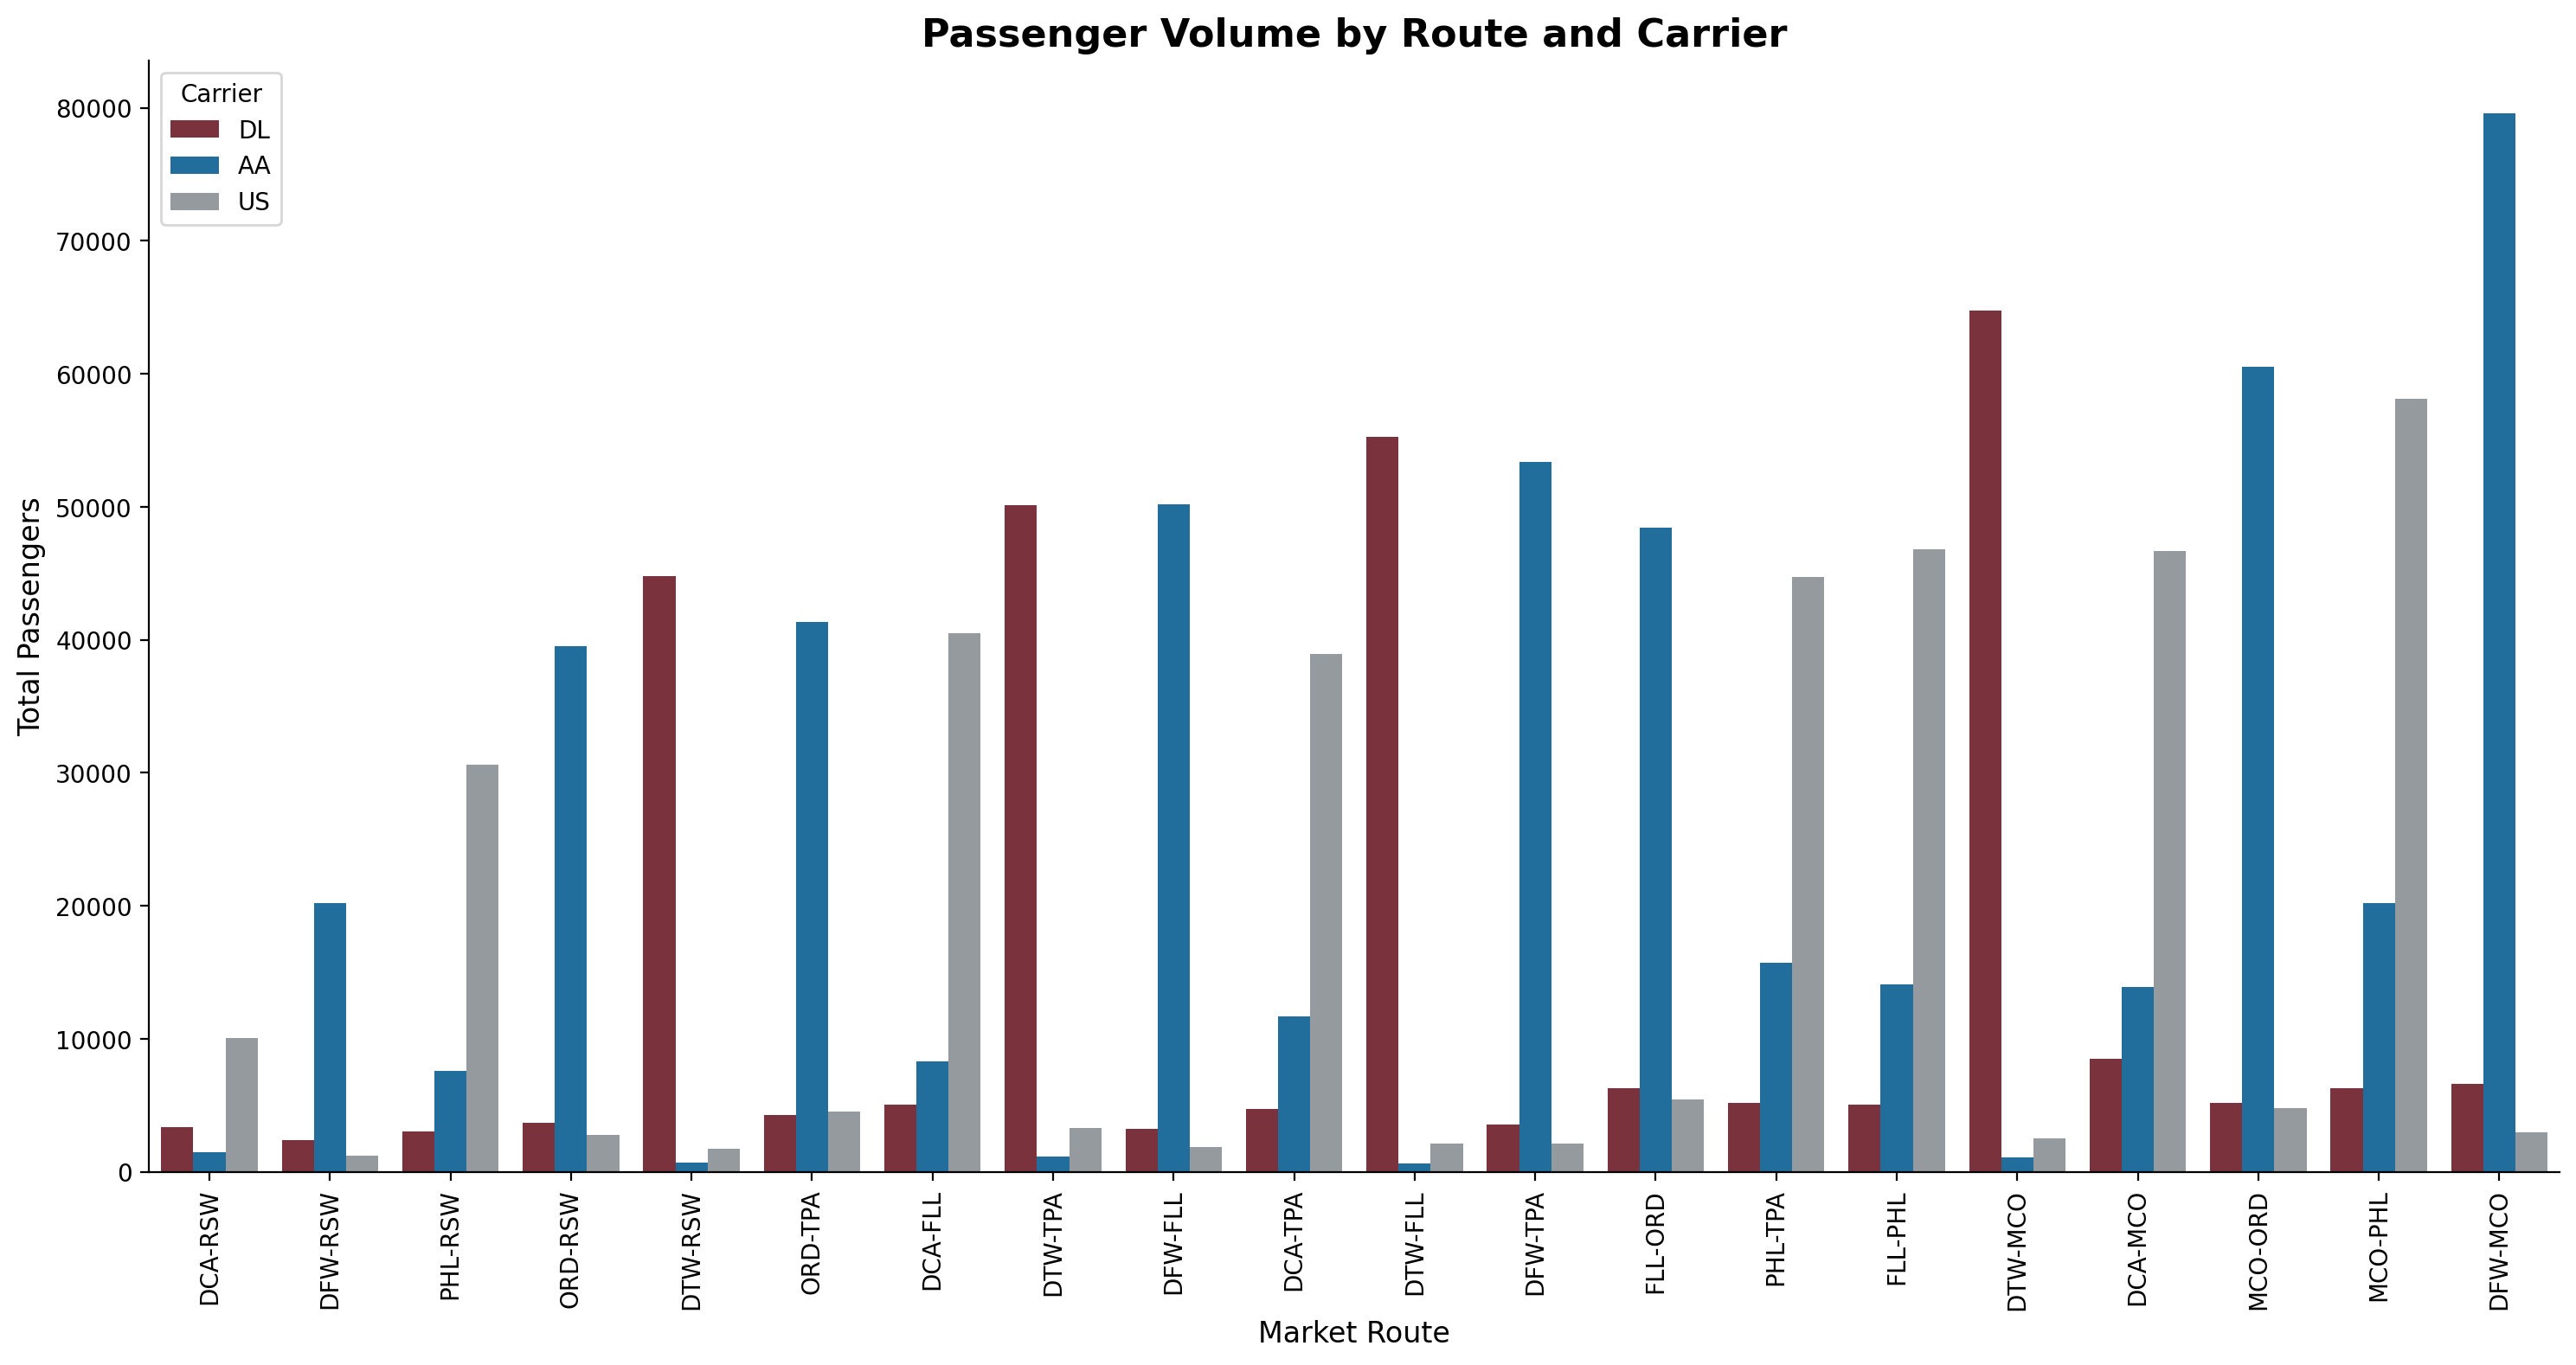

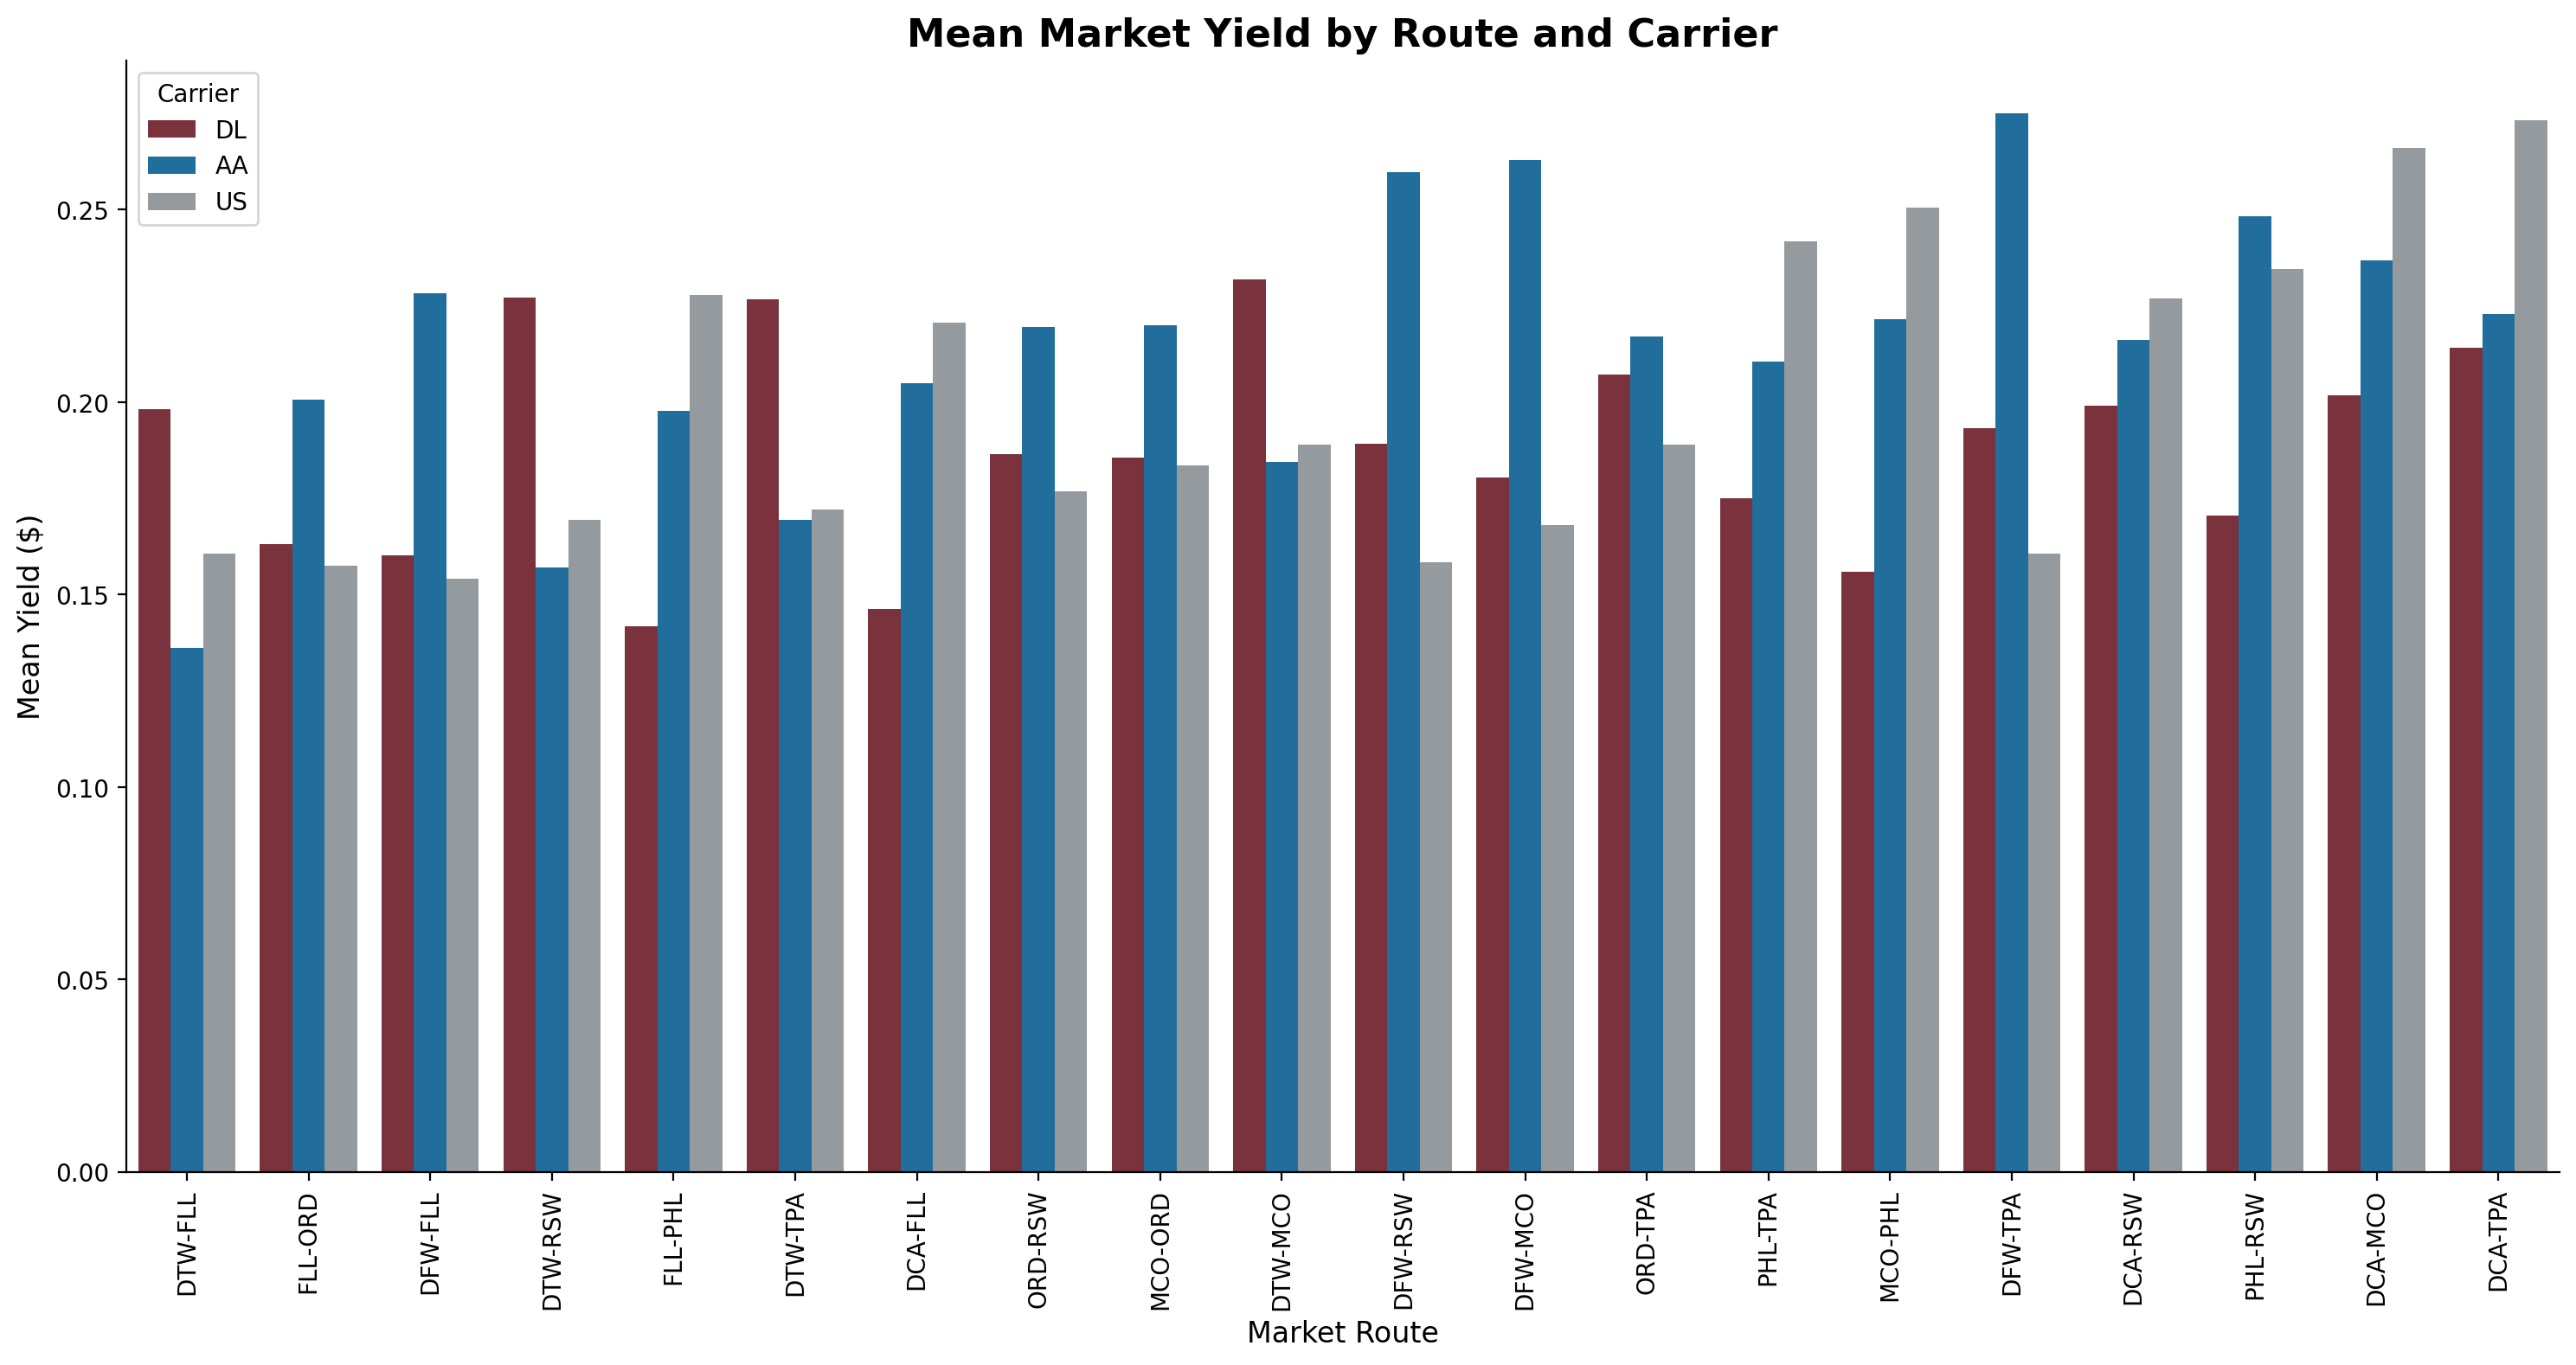

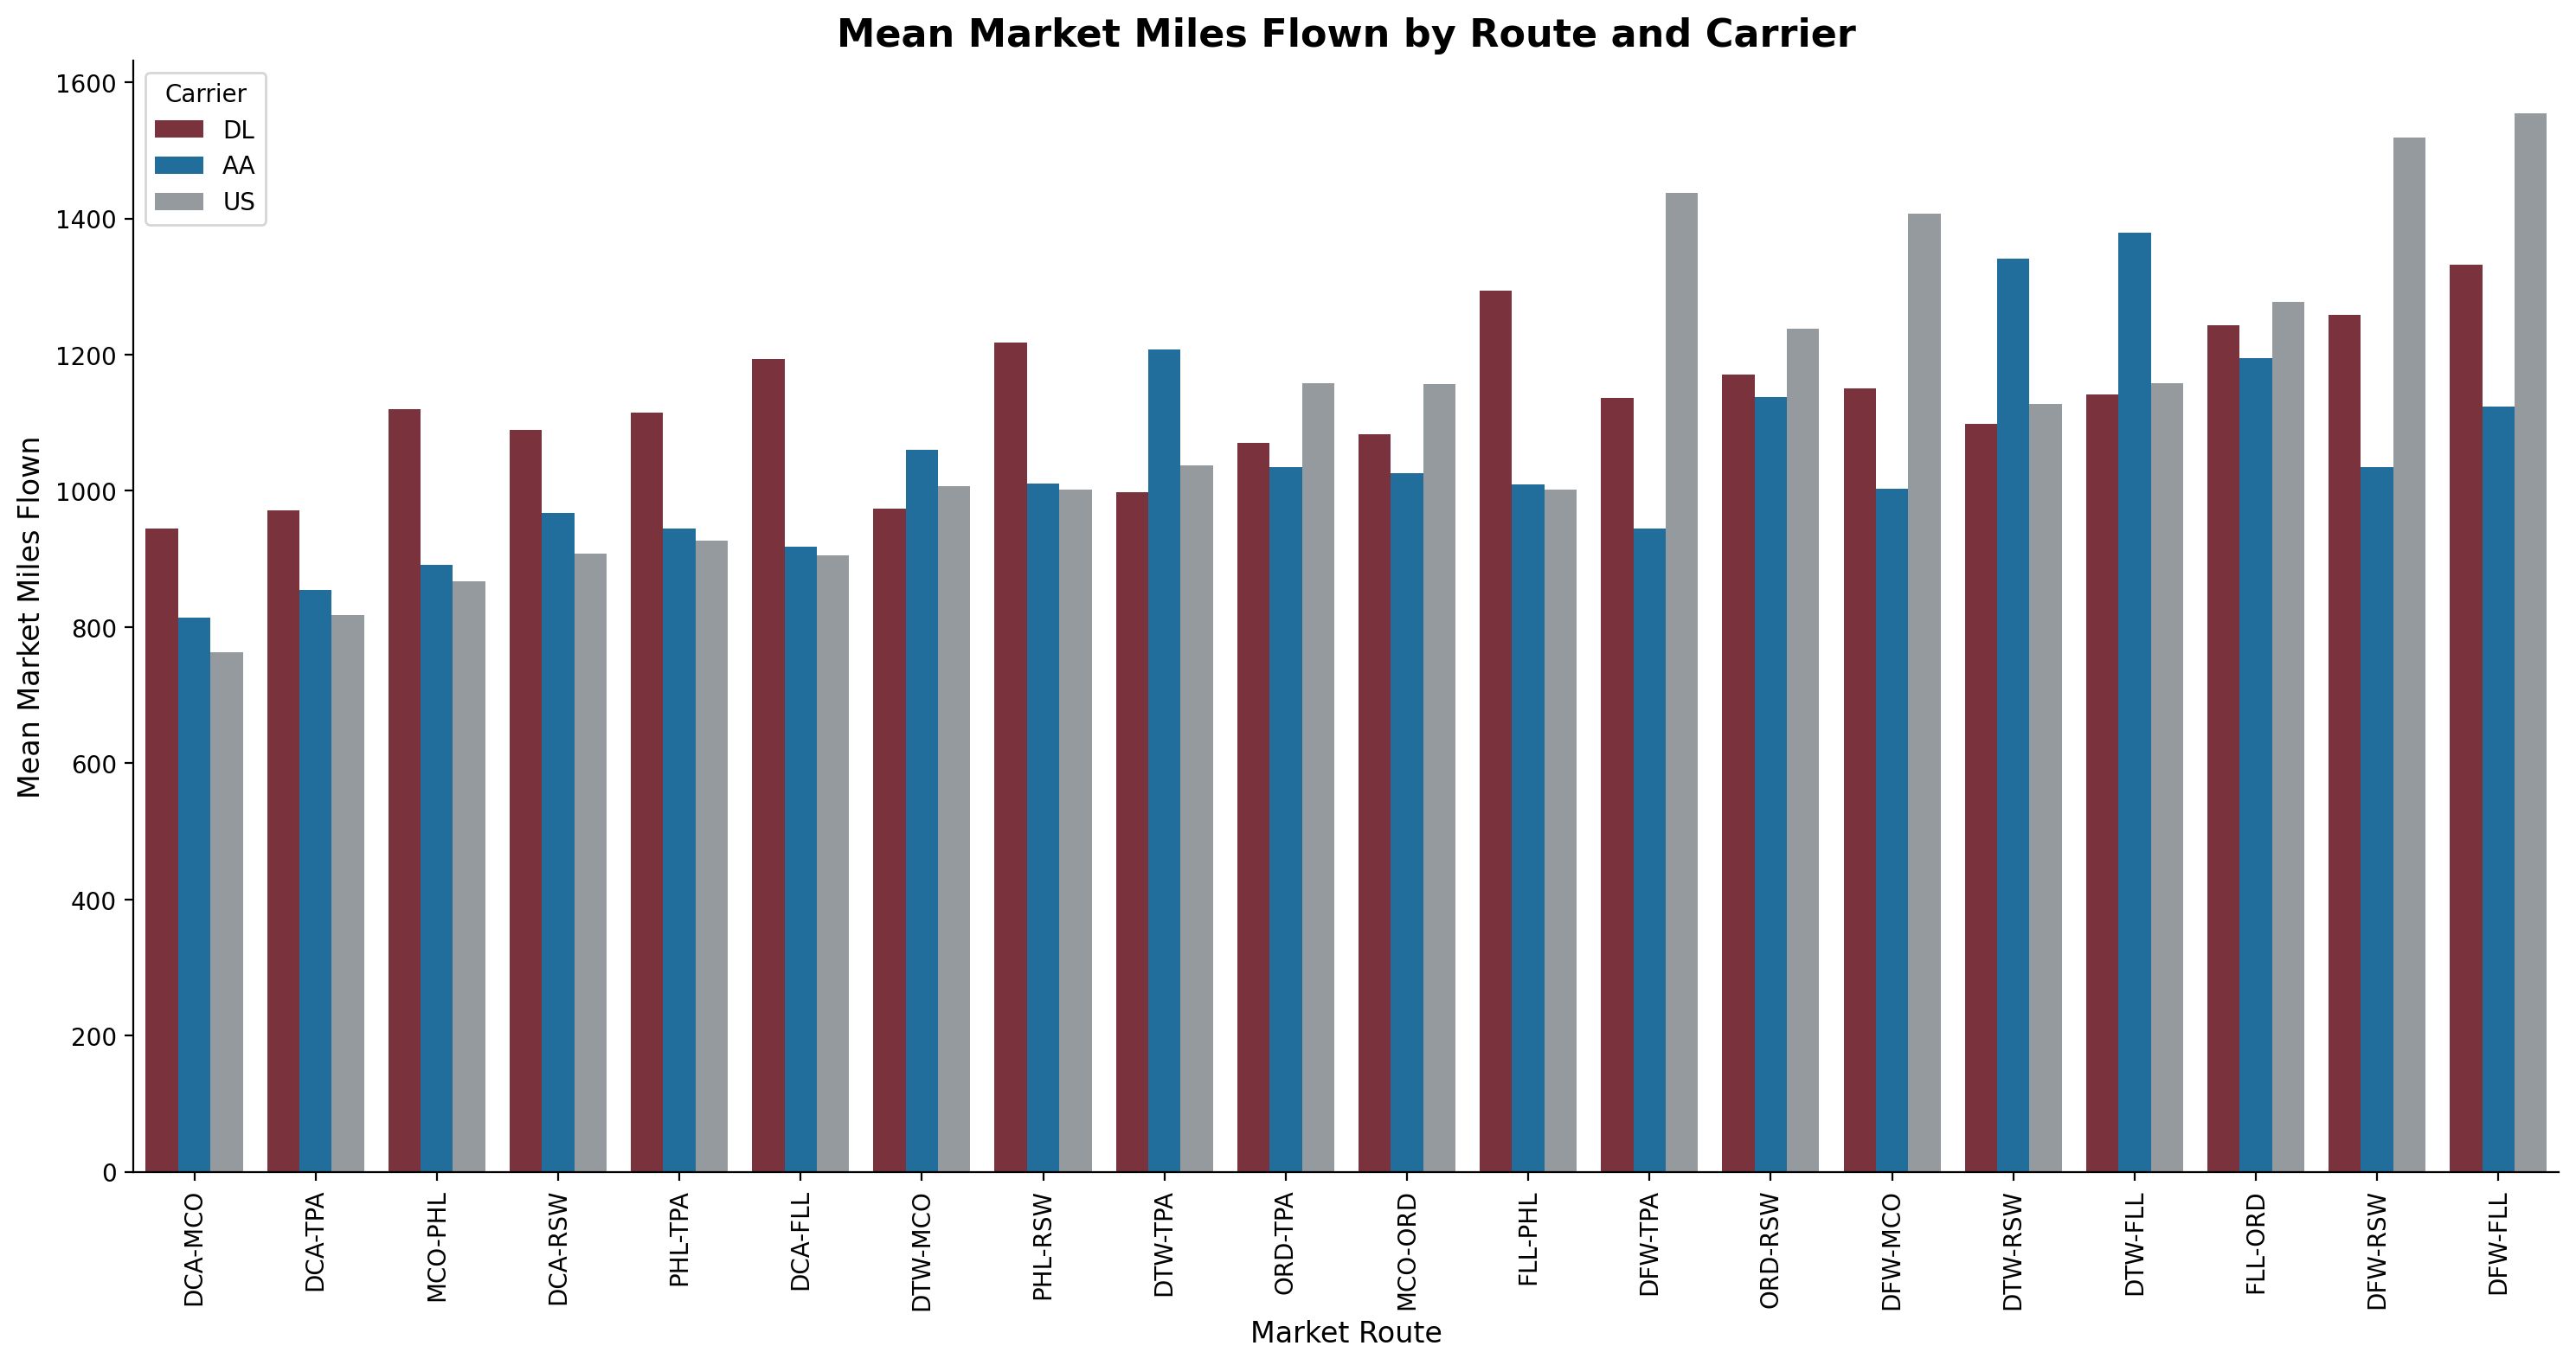

In [15]:
filtered_market_comparison_df = get_carrier_route_comparison(
    clean_market_df,
    carriers = ['DL', 'AA', 'US'],
    origin_list = ['DTW', 'DFW', 'ORD', 'DCA', 'PHL'],
    dest_list = ['FLL', 'MCO', 'TPA', 'RSW'],
)

plot_comparison_dashboard(filtered_market_comparison_df)

--- Plot 1: Yield Correlation Heatmap ---
Saved plot to: /content/drive/MyDrive/AirlineData/scm_plots/Pre-Intervention_Yield_Correlation.png


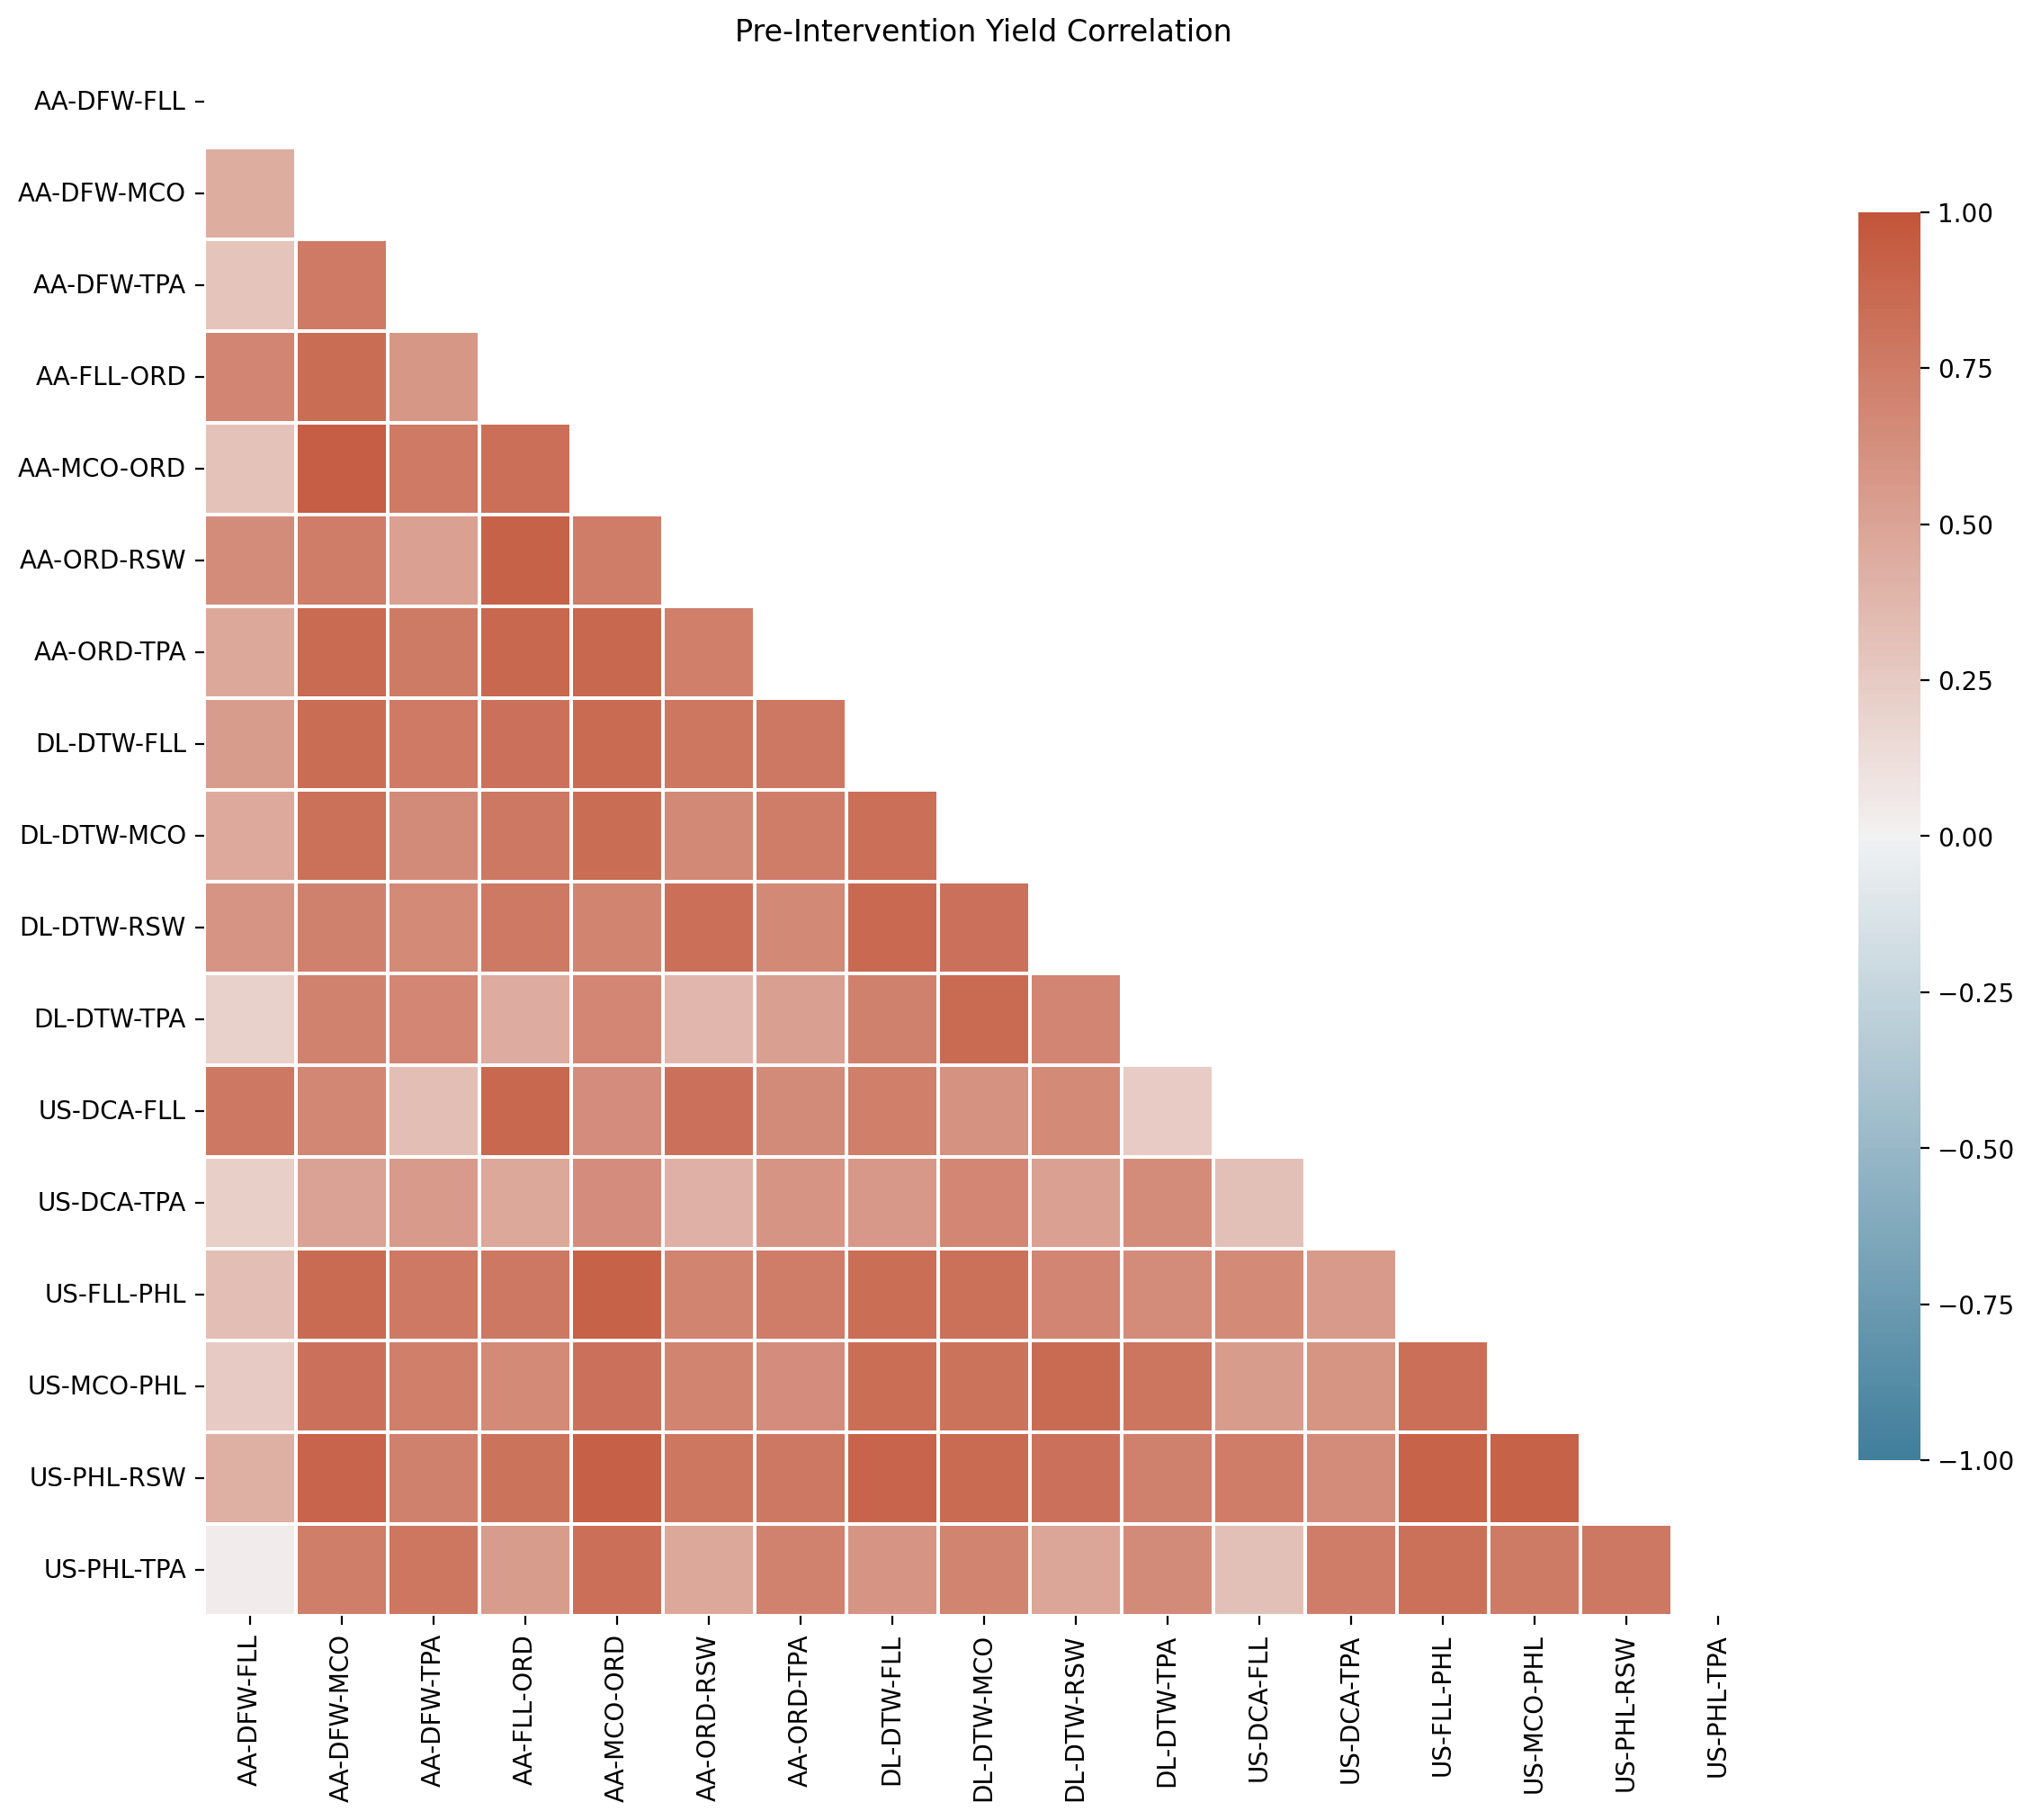


--- Plot 2: Market Share Correlation Heatmap ---
Saved plot to: /content/drive/MyDrive/AirlineData/scm_plots/Pre-Intervention_Share_Correlation.png


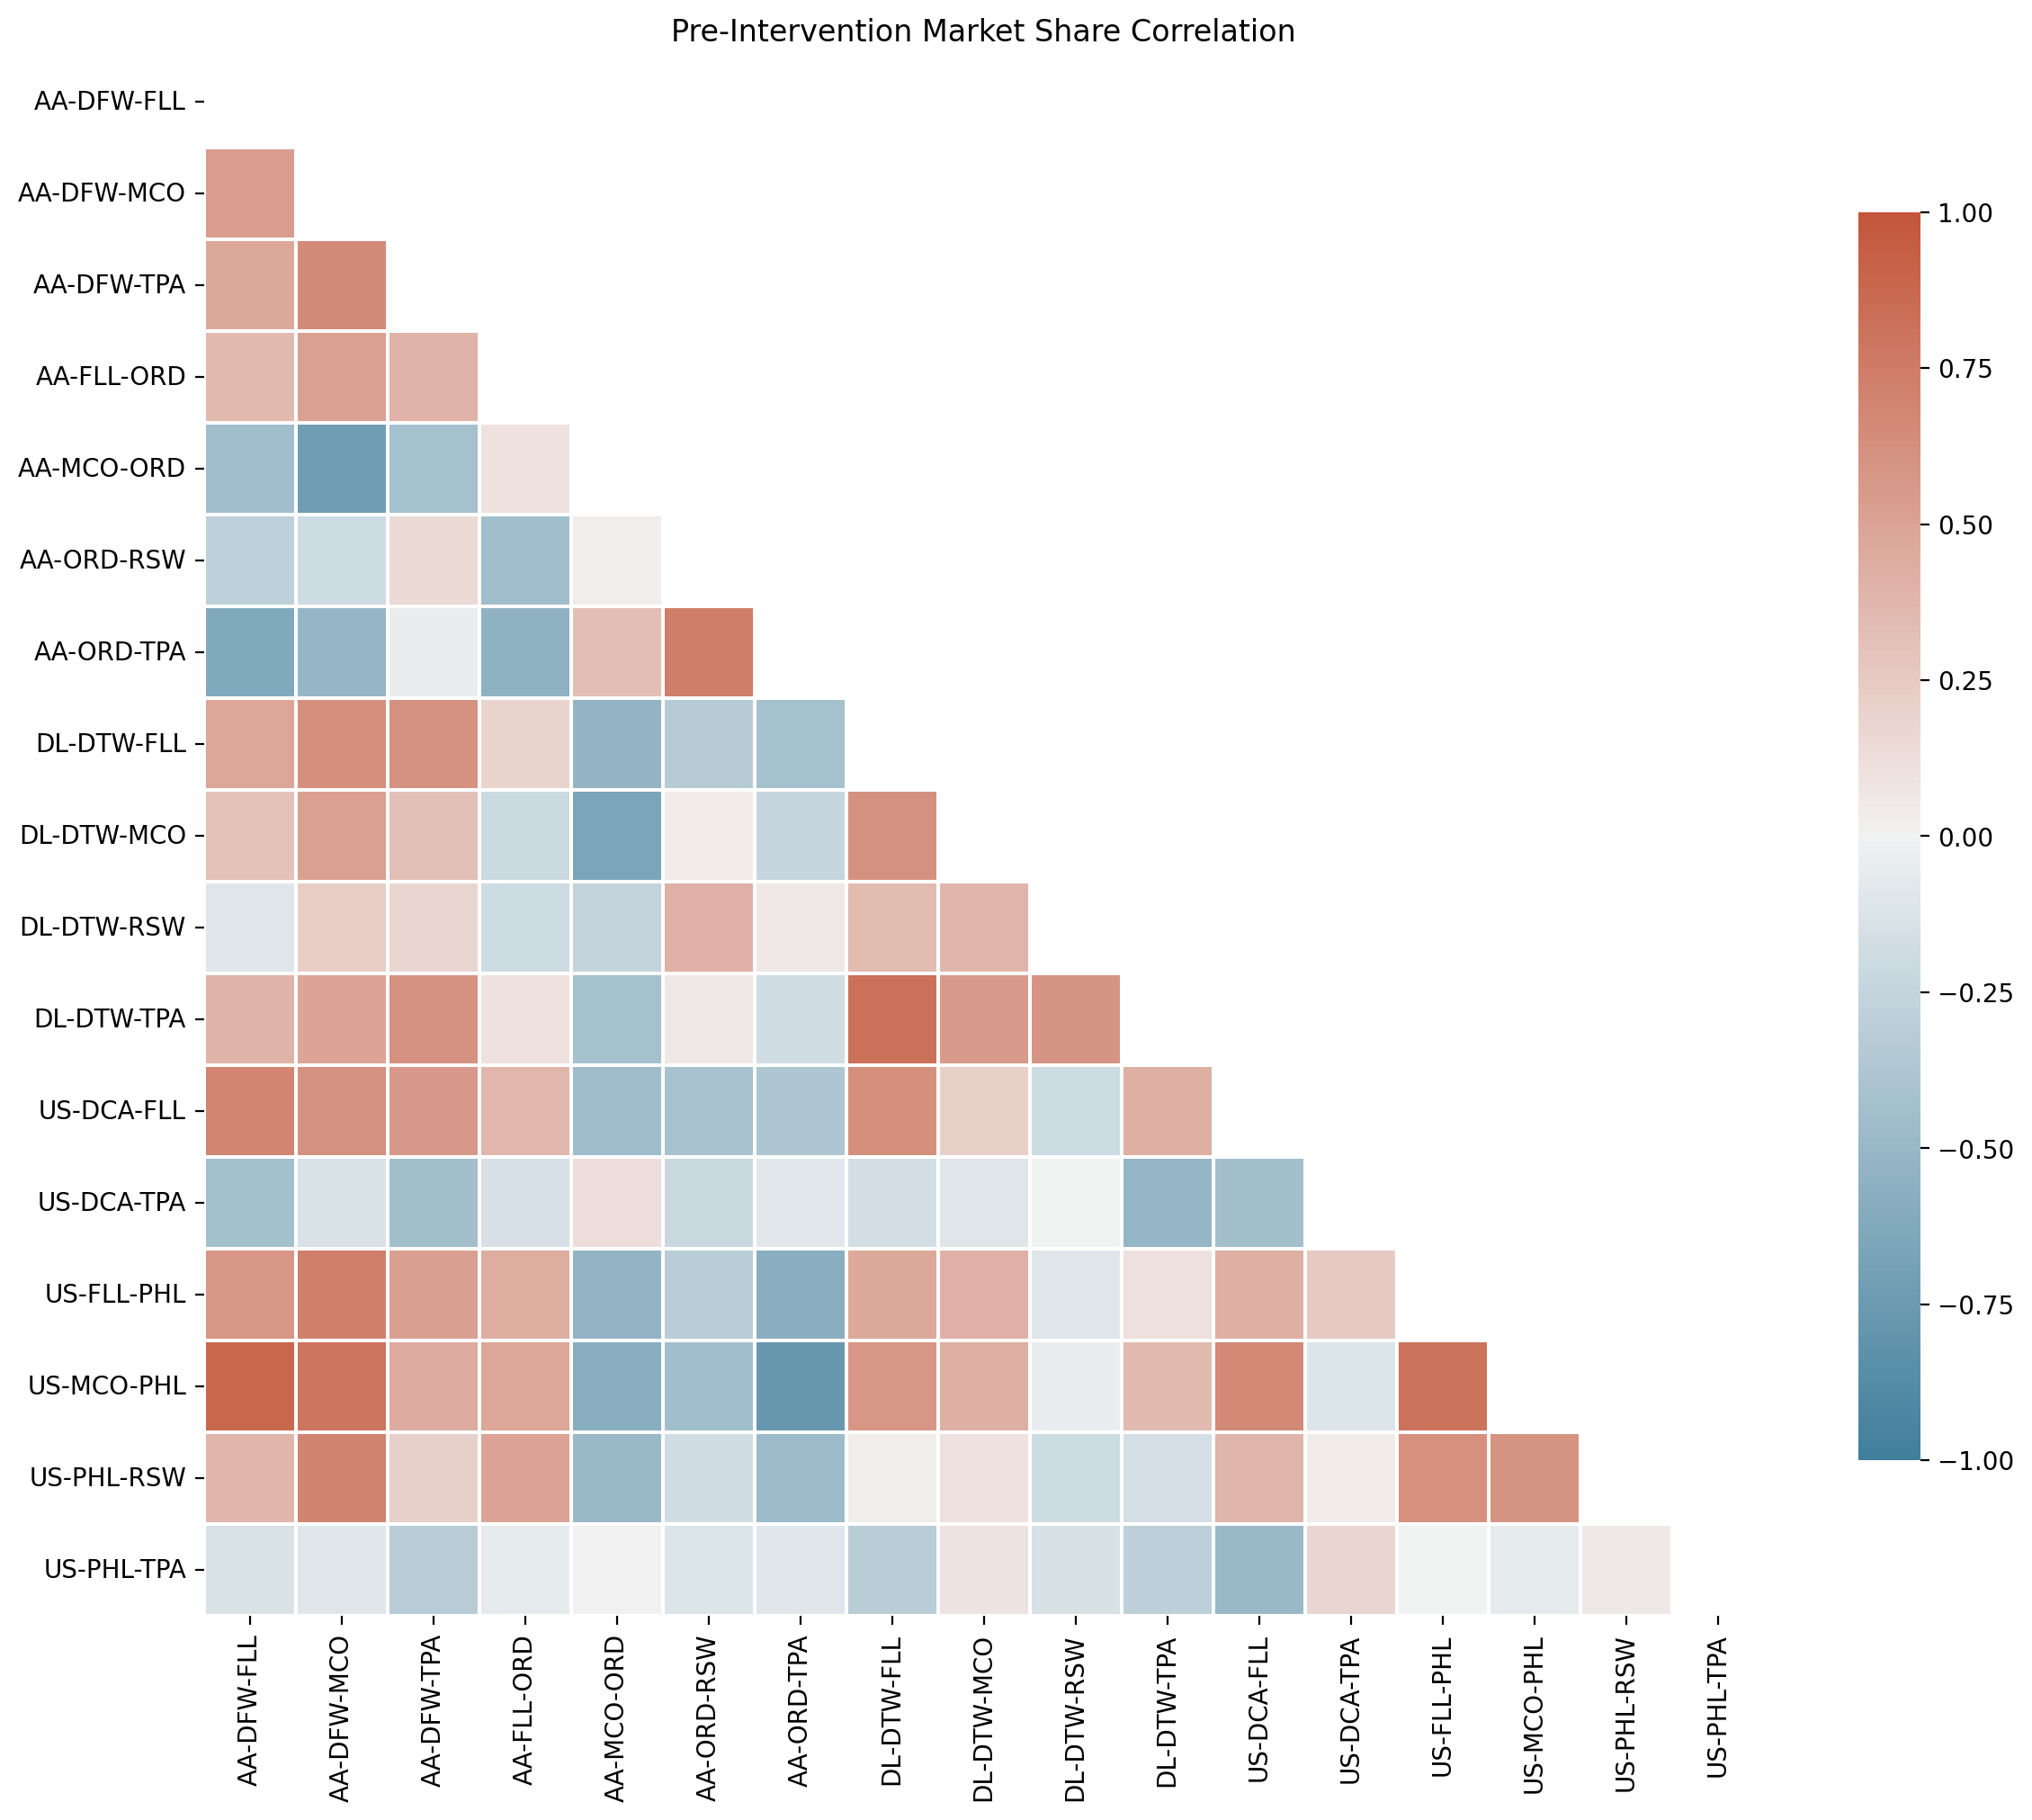


--- Plot 3: Yield Time Series ---
Saved plot to: /content/drive/MyDrive/AirlineData/scm_plots/Normalized_Yield_Time_Series.png


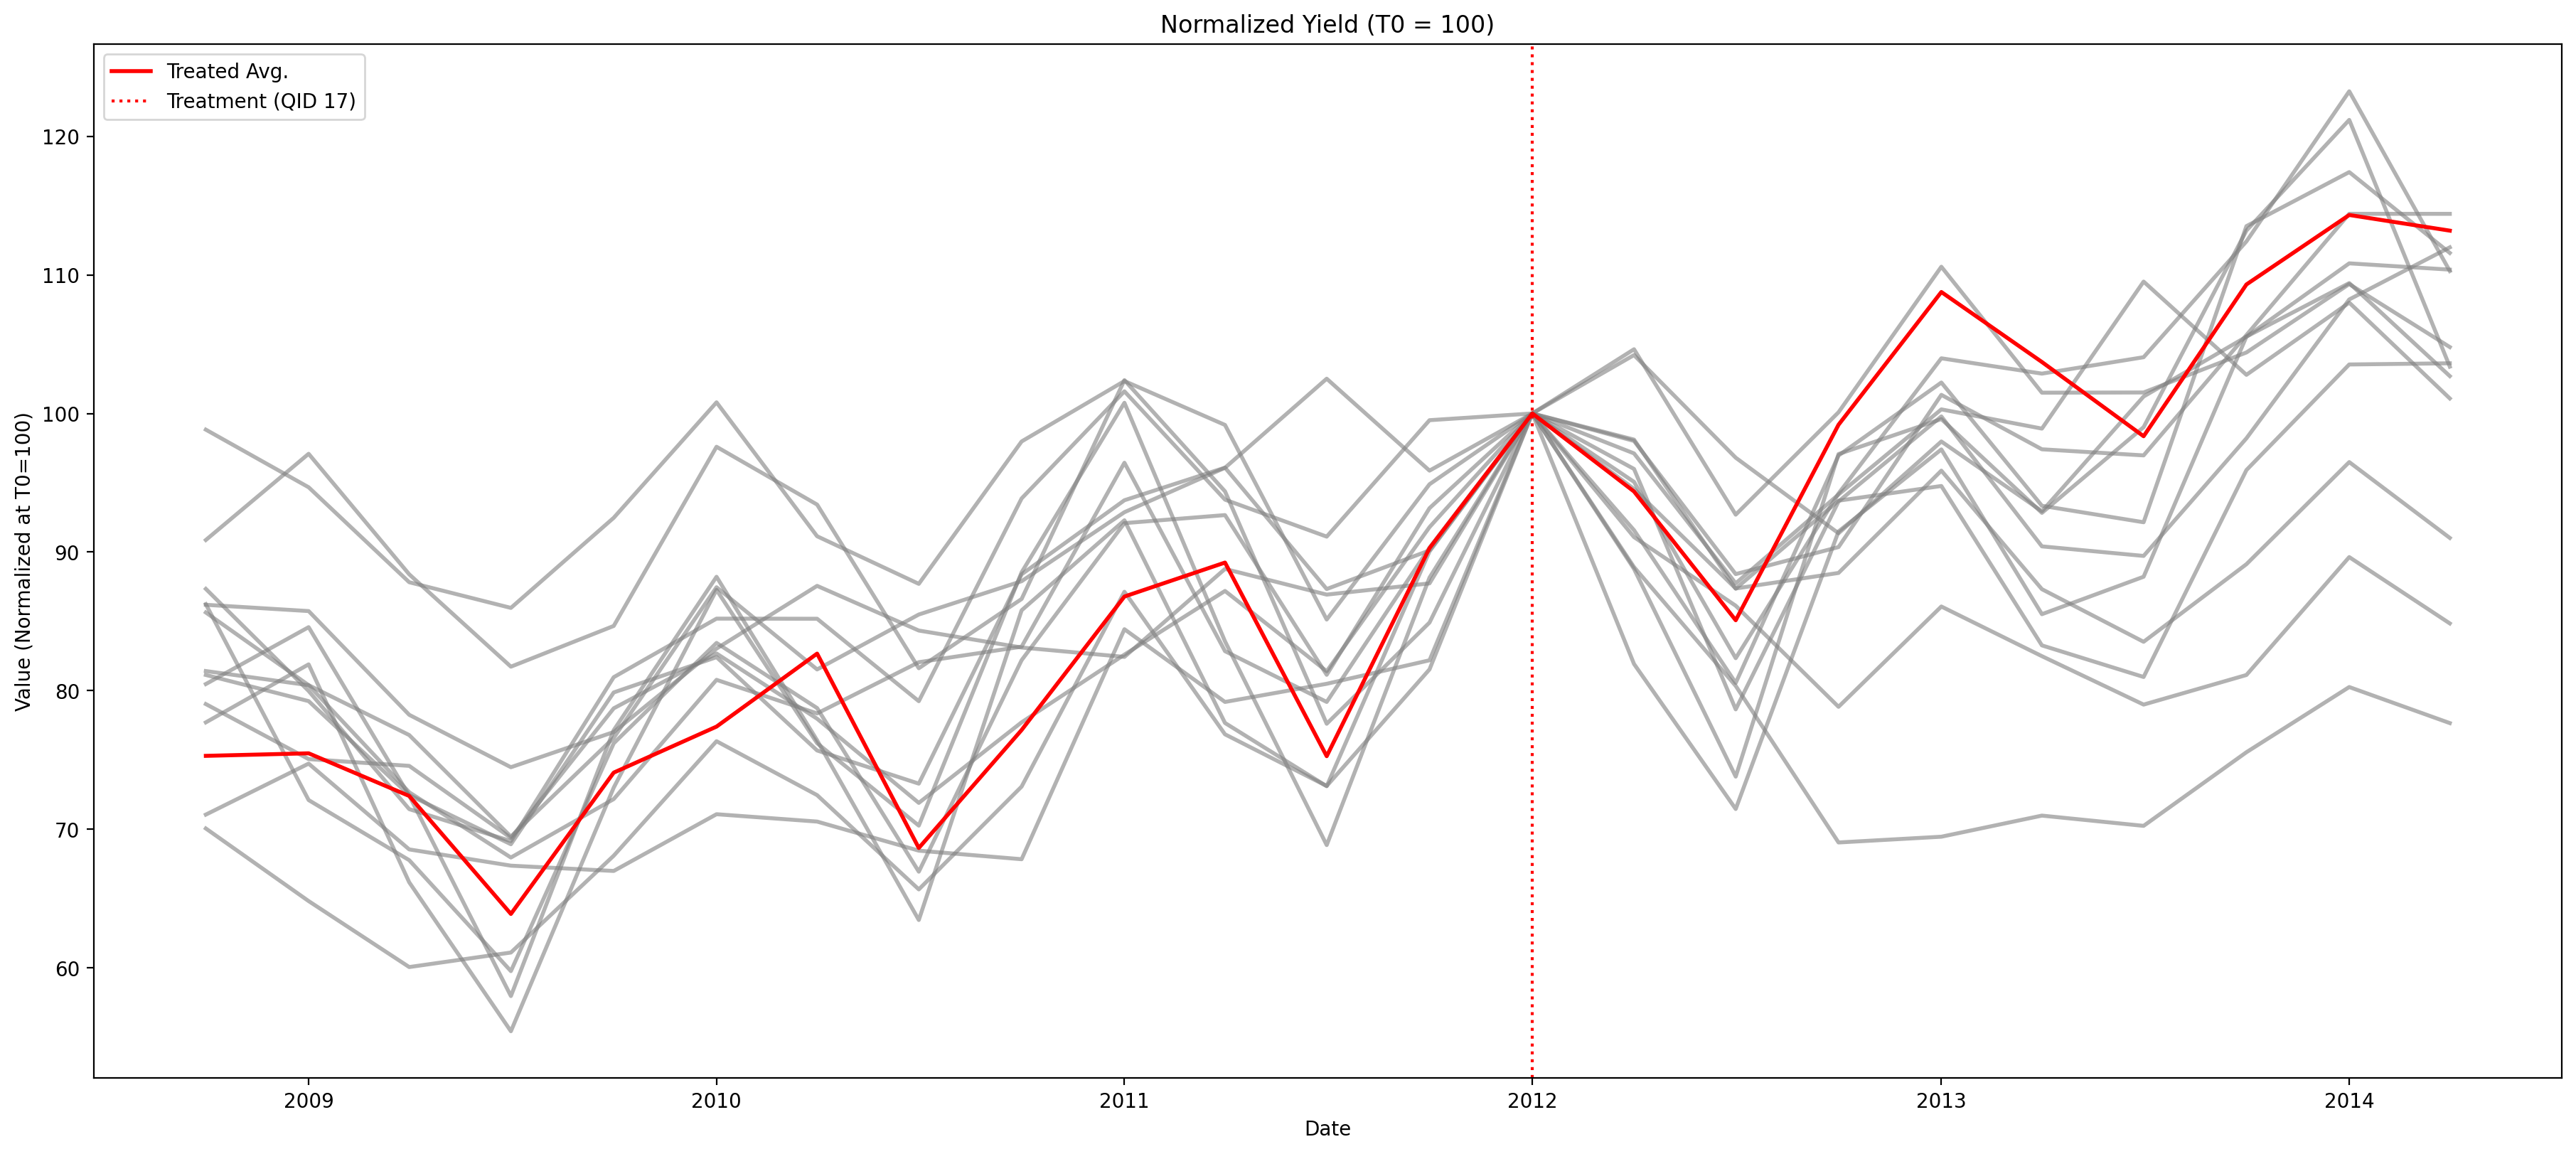


--- Plot 4: Market Share Time Series ---
Saved plot to: /content/drive/MyDrive/AirlineData/scm_plots/Normalized_Share_Time_Series.png


In [16]:
plot_donor_pool_diagnostics(
    units_df = units_df,
    treatment_time = treatment_time,
    treated_carrier = dl_treated_carrier,
    treated_carrier_routes = dl_treated_carrier_routes,
    all_control_routes = all_control_routes_aa_us
)

## Modeling

Kept 13 of 13 control units with complete data for *both* KPIs.
--- Sampling with JAX (Numpyro) ---


  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

--- Sampling Complete ---
--- Model Diagnostic Summary ---
                           mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
beta_y[0]                 0.016  0.020   0.000    0.050      0.000    0.000   
beta_y[1]                 0.014  0.017   0.000    0.044      0.000    0.000   
beta_y[2]                 0.011  0.013   0.000    0.033      0.000    0.000   
beta_y[3]                 0.178  0.270   0.000    0.742      0.005    0.004   
beta_y[4]                 0.021  0.035   0.000    0.072      0.000    0.001   
beta_y[5]                 0.613  0.307   0.000    0.916      0.006    0.004   
beta_y[6]                 0.030  0.080   0.000    0.095      0.001    0.005   
beta_y[7]                 0.019  0.028   0.000    0.065      0.000    0.000   
beta_y[8]                 0.009  0.010   0.000    0.027      0.000    0.000   
beta_y[9]                 0.026  0.042   0.000    0.095      0.000    0.001   
beta_y[10]                0.018  0.025   0.000    0.061      0.000    0.

Output()

Output()

/usr/local/lib/python3.12/dist-packages/arviz/plots/hdiplot.py:166: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)
/usr/local/lib/python3.12/dist-packages/arviz/plots/hdiplot.py:166: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)
/usr/local/lib/python3.12/dist-packages/arviz/plots/hdiplot.py:166: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)
/usr/local/lib/python3.12/dist-packages/arviz/plots/

Saved plot to: /content/drive/MyDrive/AirlineData/scm_plots/scm_results.png


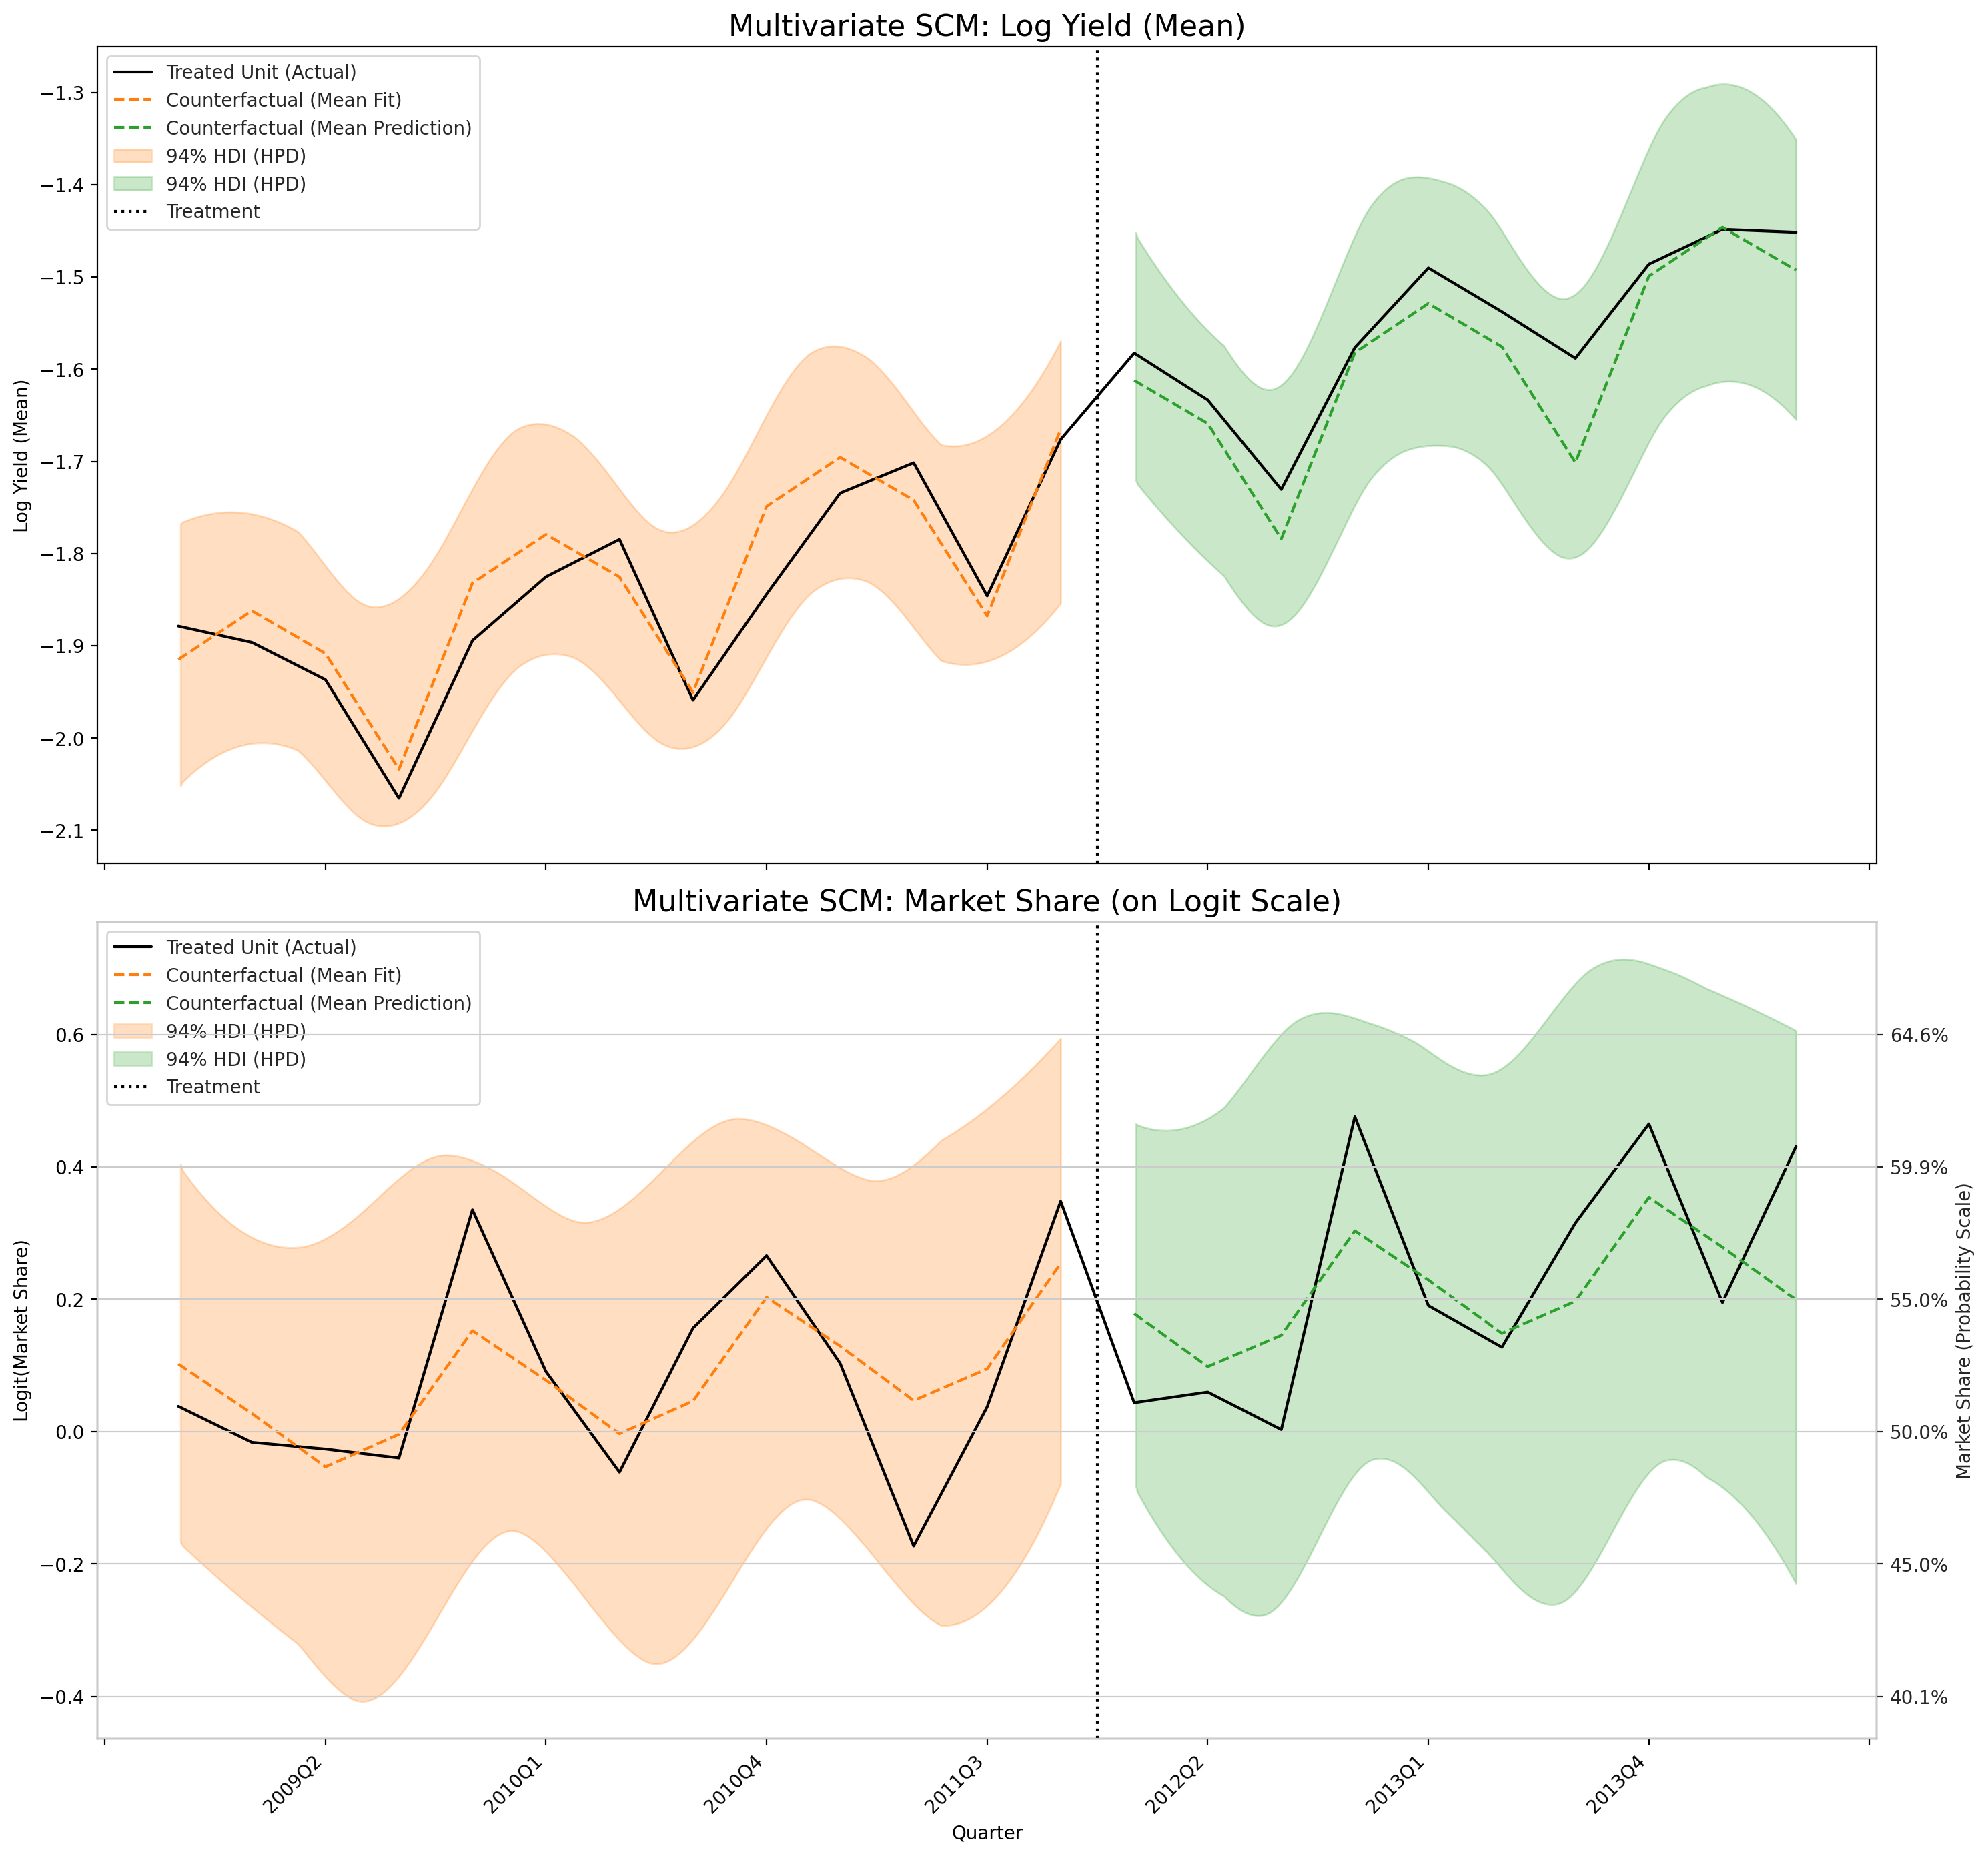

--- Analyzing Control Unit Weights (Log Yield) ---


/tmp/ipython-input-2000004980.py:161: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_weights = az.hdi(beta_samps.T.values, hdi_prob=hdi_prob)


Saved plot to: /content/drive/MyDrive/AirlineData/scm_plots/yield_control_weights.png


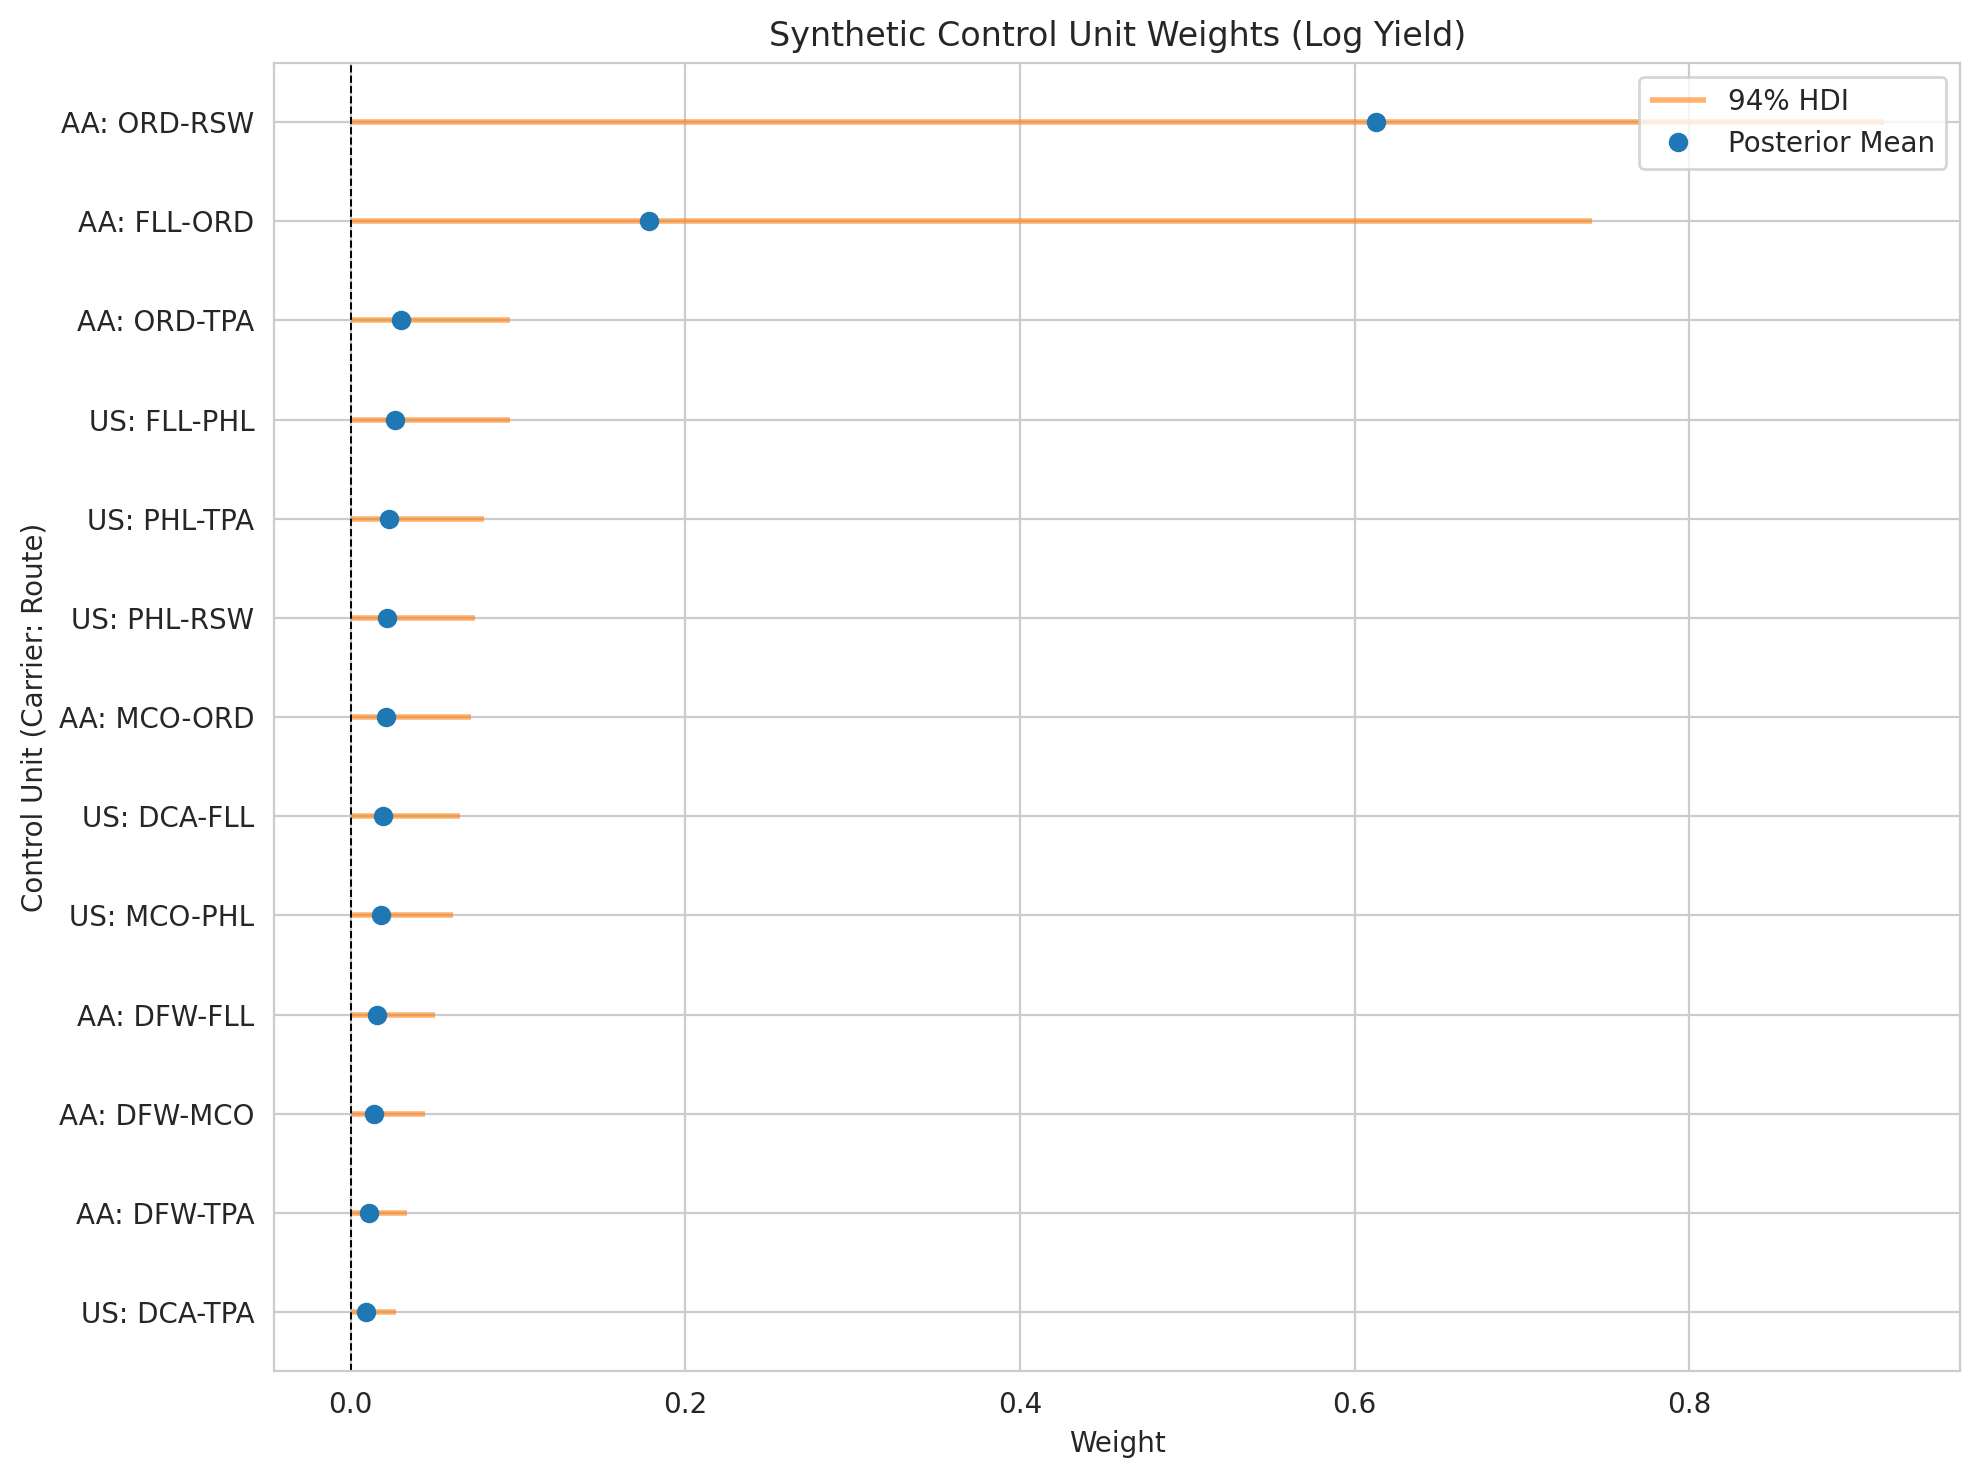

--- Analyzing Control Unit Weights (Logit Market Share) ---


/tmp/ipython-input-2000004980.py:161: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_weights = az.hdi(beta_samps.T.values, hdi_prob=hdi_prob)


Saved plot to: /content/drive/MyDrive/AirlineData/scm_plots/share_control_weights.png


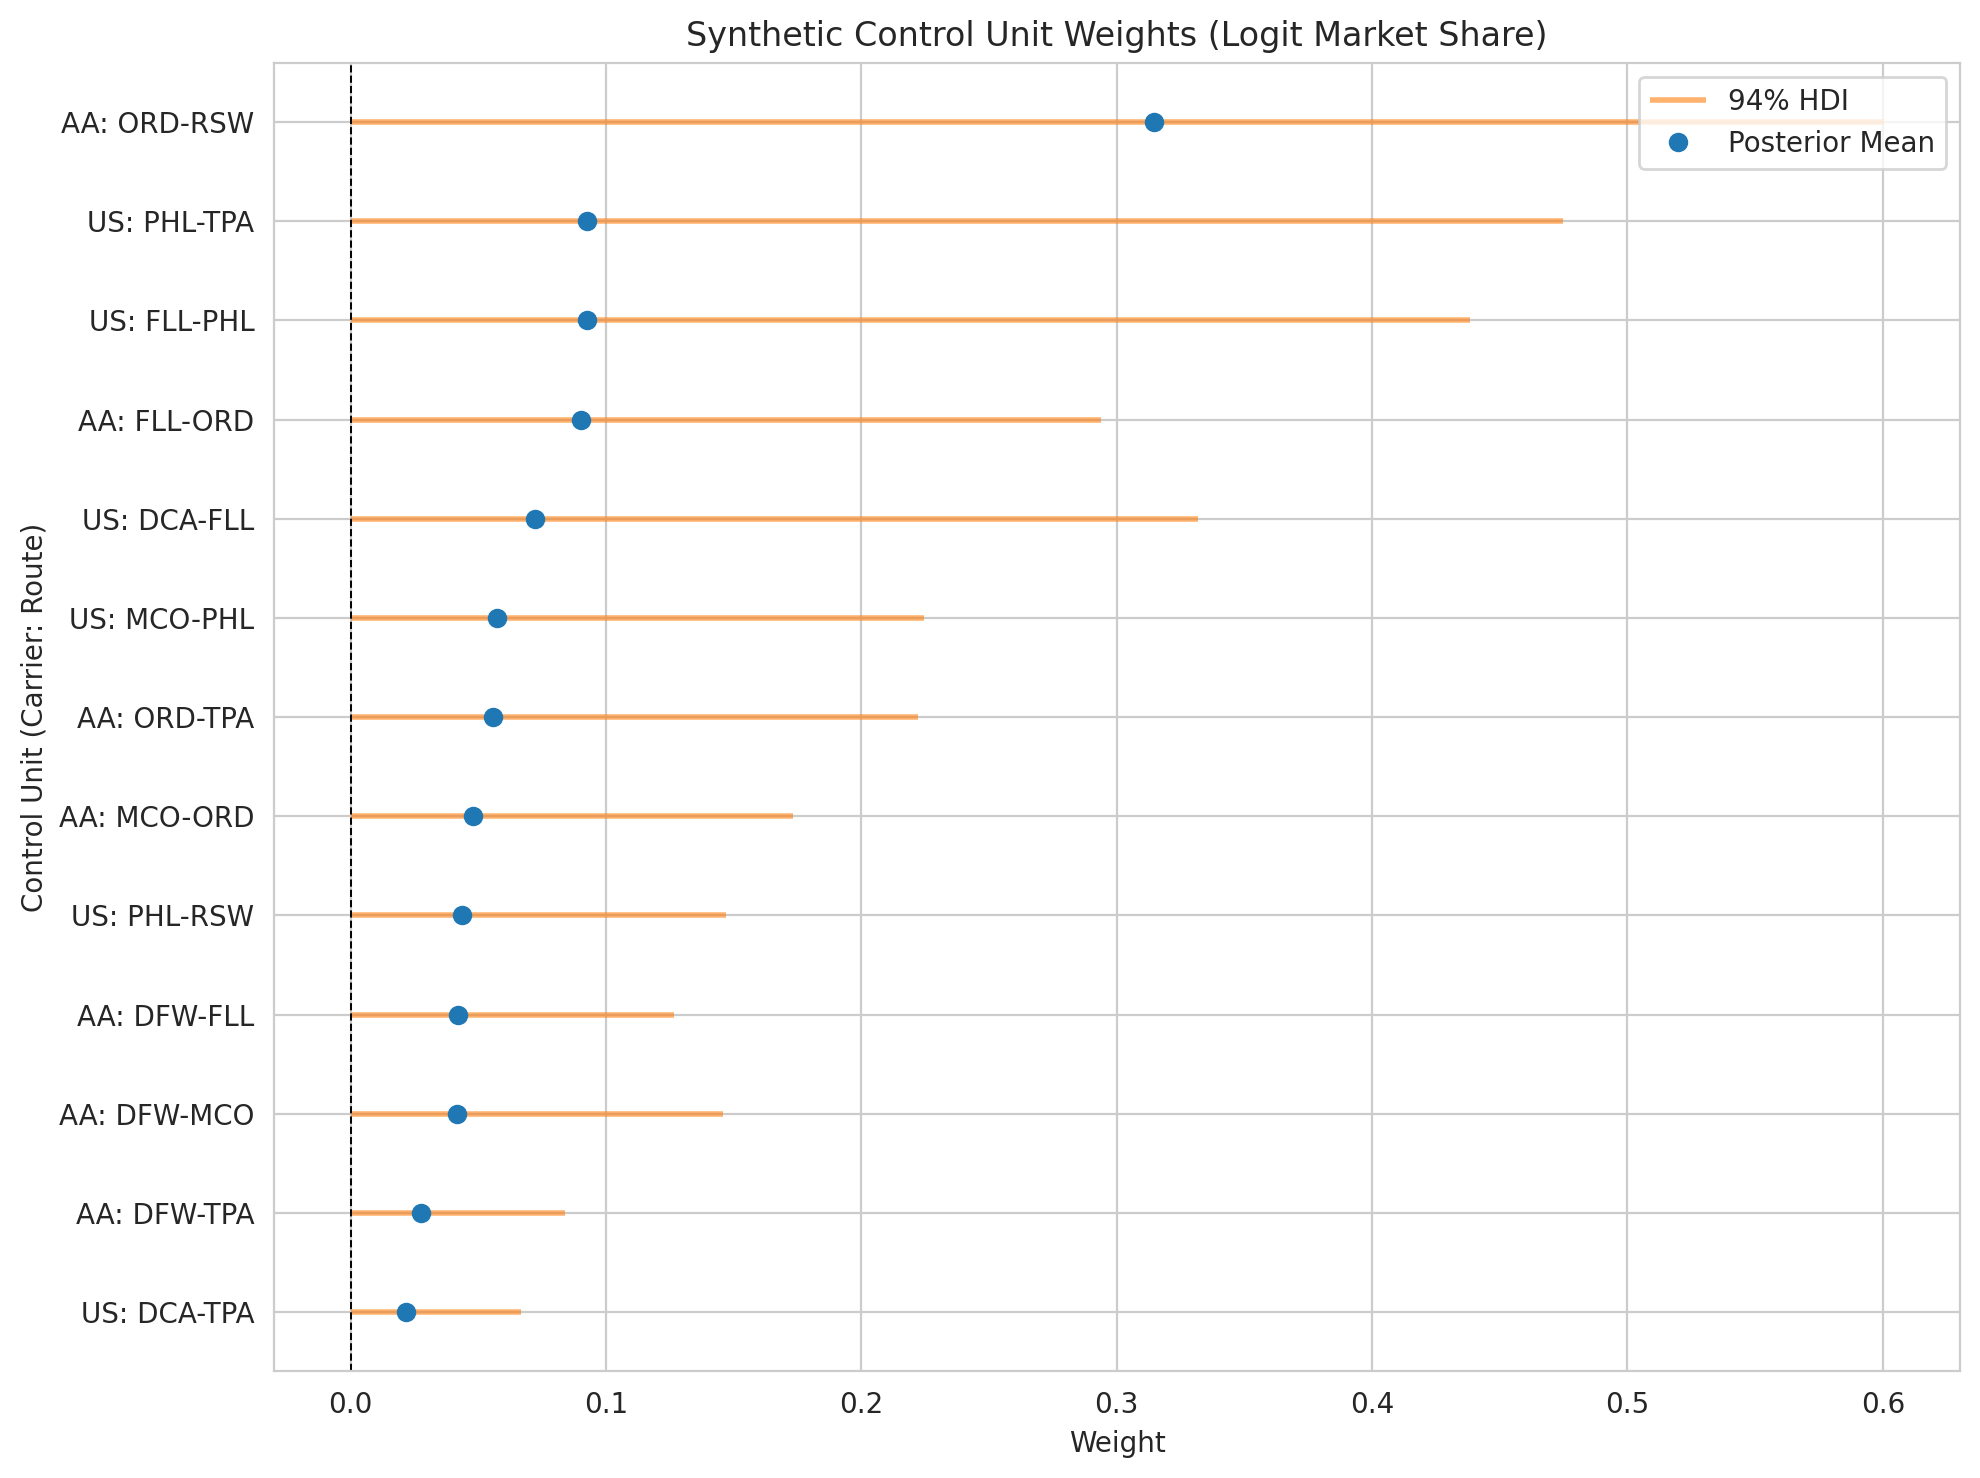

--- Calculating Causal Impact Distributions ---

--- Average Treatment Effect (ATT) Summary ---
  Log Yield:
    Mean Effect: 0.0356
    94% HDI:     [-0.05362907  0.12394561]

  Market Share (Percentage Points):
    Mean Effect: 0.44%
    94% HDI:     [-0.05487274  0.06348455]
------------------------------------------------



/usr/local/lib/python3.12/dist-packages/arviz/plots/hdiplot.py:166: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)
/usr/local/lib/python3.12/dist-packages/arviz/plots/hdiplot.py:166: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)


Saved plot to: /content/drive/MyDrive/AirlineData/scm_plots/causal_impact.png


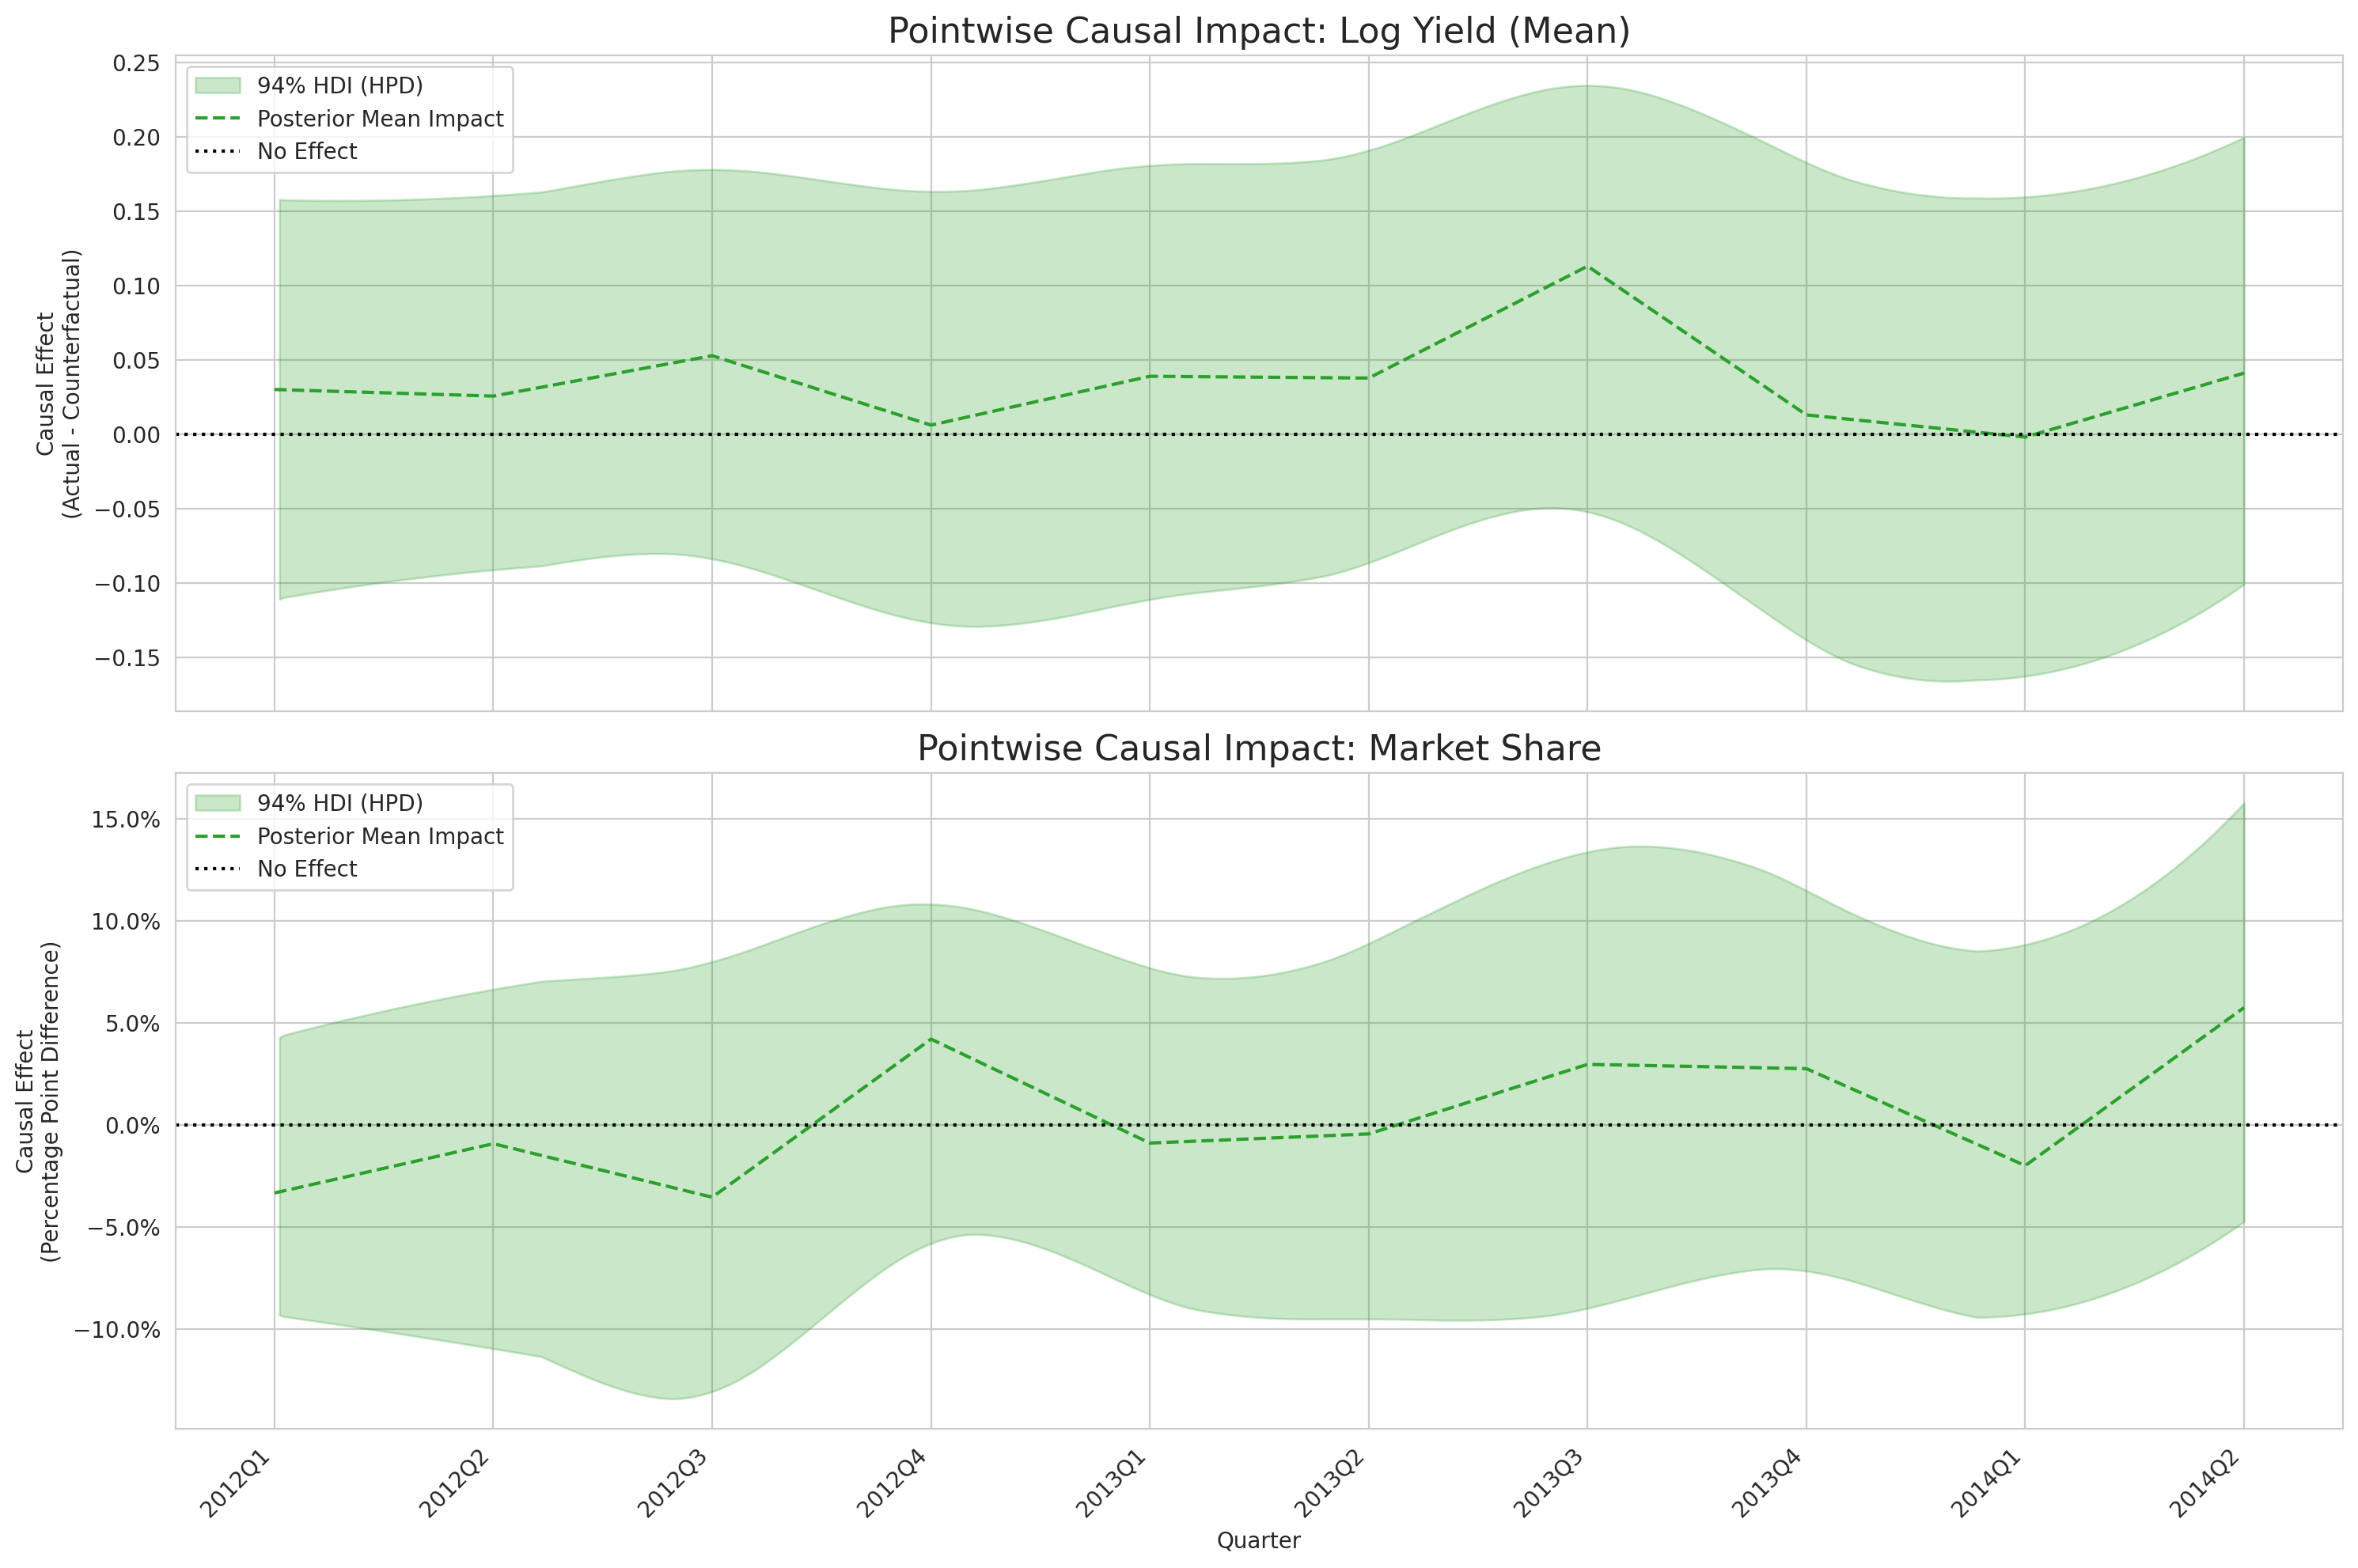

In [17]:
try:
    model_data, plot_data = prepare_data_for_generative_scm(
        units_df,
        dl_treated_carrier_routes,
        all_control_routes_aa_us,
        treatment_time,
        dl_treated_carrier
    )

    generative_model = build_generative_scm_model(**model_data)

    if generative_model is not None:

        sample_kwargs = {
            "tune": 4000,
            "draws": 4000,
            "target_accept": 0.99,
            "random_seed": 42,
            "chains": 8,
            "nuts_kwargs": {
                "max_tree_depth": 12
            }
        }

        print("--- Sampling with JAX (Numpyro) ---")
        with generative_model:
            idata = pymc.sampling.jax.sample_numpyro_nuts(**sample_kwargs)

        print("--- Sampling Complete ---")

        print("--- Model Diagnostic Summary ---")

        # Define the parameters we care most about.
        # We want the top-level parameters the sampler is fitting.
        # 'beta' is our SCM weights.
        # The '_offset' variables are the non-centered
        # hyperparameters for all our groups.
        # Problems here will cascade down to everything else.
        # Check the  hierarchical weight parameters
        vars_to_check = [
            'beta_y',
            'beta_s',
            'beta_raw_base',
            'beta_raw_offset_y',
            'beta_raw_offset_s',
            'trend_slope_y_offset',
            'trend_slope_s_offset'
        ]

        summary_stats = az.summary(idata, var_names=vars_to_check, round_to=3)

        with pd.option_context('display.max_rows', None):
            print(summary_stats)

        plot_generative_scm_results(
            model_data,
            plot_data,
            idata,
            generative_model,
            save_path=os.path.join(scm_plots_folder, 'scm_results.png')
        )

        plot_control_weights(
            idata,
            plot_data,
            beta_var_name="beta_y",
            title_suffix="Log Yield",
            save_path=os.path.join(scm_plots_folder, 'yield_control_weights.png')
        )

        plot_control_weights(
            idata,
            plot_data,
            beta_var_name="beta_s",
            title_suffix="Logit Market Share",
            save_path=os.path.join(scm_plots_folder, 'share_control_weights.png')
        )

        calculate_and_plot_impact(
            model_data,
            plot_data,
            idata,
            save_path=os.path.join(scm_plots_folder, 'causal_impact.png')
        )

except ValueError as e:
    print(f"Data preparation failed: {e}")
except Exception as e:
    print(f"An error occurred during model execution: {e}")

In [18]:
idata.to_netcdf("/content/drive/MyDrive/AirlineData/scm_models/generative_scm_model.nc")

'/content/drive/MyDrive/AirlineData/scm_models/generative_scm_model.nc'

In [19]:
scm_model_graph = pm.model_to_graphviz(generative_model)
scm_model_graph.render(filename='/content/drive/MyDrive/AirlineData/scm_models/scm_model_graph', format='png', view=False)

'/content/drive/MyDrive/AirlineData/scm_models/scm_model_graph.png'

Here we adjust the model to sample faster and achieve similar results.

Kept 13 of 13 control units with complete data for *both* KPIs.
--- Sampling with JAX (Numpyro) ---


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

ERROR:pymc.stats.convergence:There were 69 divergences after tuning. Increase `target_accept` or reparameterize.


--- Sampling Complete ---
--- Model Diagnostic Summary ---


Output()

                           mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
beta_y[0]                 0.017  0.020   0.000    0.052      0.000    0.001   
beta_y[1]                 0.014  0.018   0.000    0.045      0.000    0.000   
beta_y[2]                 0.012  0.014   0.000    0.036      0.000    0.000   
beta_y[3]                 0.210  0.290   0.000    0.762      0.016    0.008   
beta_y[4]                 0.021  0.032   0.000    0.073      0.000    0.001   
beta_y[5]                 0.577  0.325   0.000    0.911      0.017    0.008   
beta_y[6]                 0.032  0.085   0.000    0.101      0.002    0.010   
beta_y[7]                 0.020  0.029   0.000    0.069      0.000    0.001   
beta_y[8]                 0.009  0.010   0.000    0.027      0.000    0.000   
beta_y[9]                 0.025  0.040   0.000    0.091      0.001    0.001   
beta_y[10]                0.019  0.025   0.000    0.062      0.000    0.001   
beta_y[11]                0.022  0.039   0.000    0.

Output()

/usr/local/lib/python3.12/dist-packages/arviz/plots/hdiplot.py:166: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)
/usr/local/lib/python3.12/dist-packages/arviz/plots/hdiplot.py:166: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)
/usr/local/lib/python3.12/dist-packages/arviz/plots/hdiplot.py:166: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)
/usr/local/lib/python3.12/dist-packages/arviz/plots/

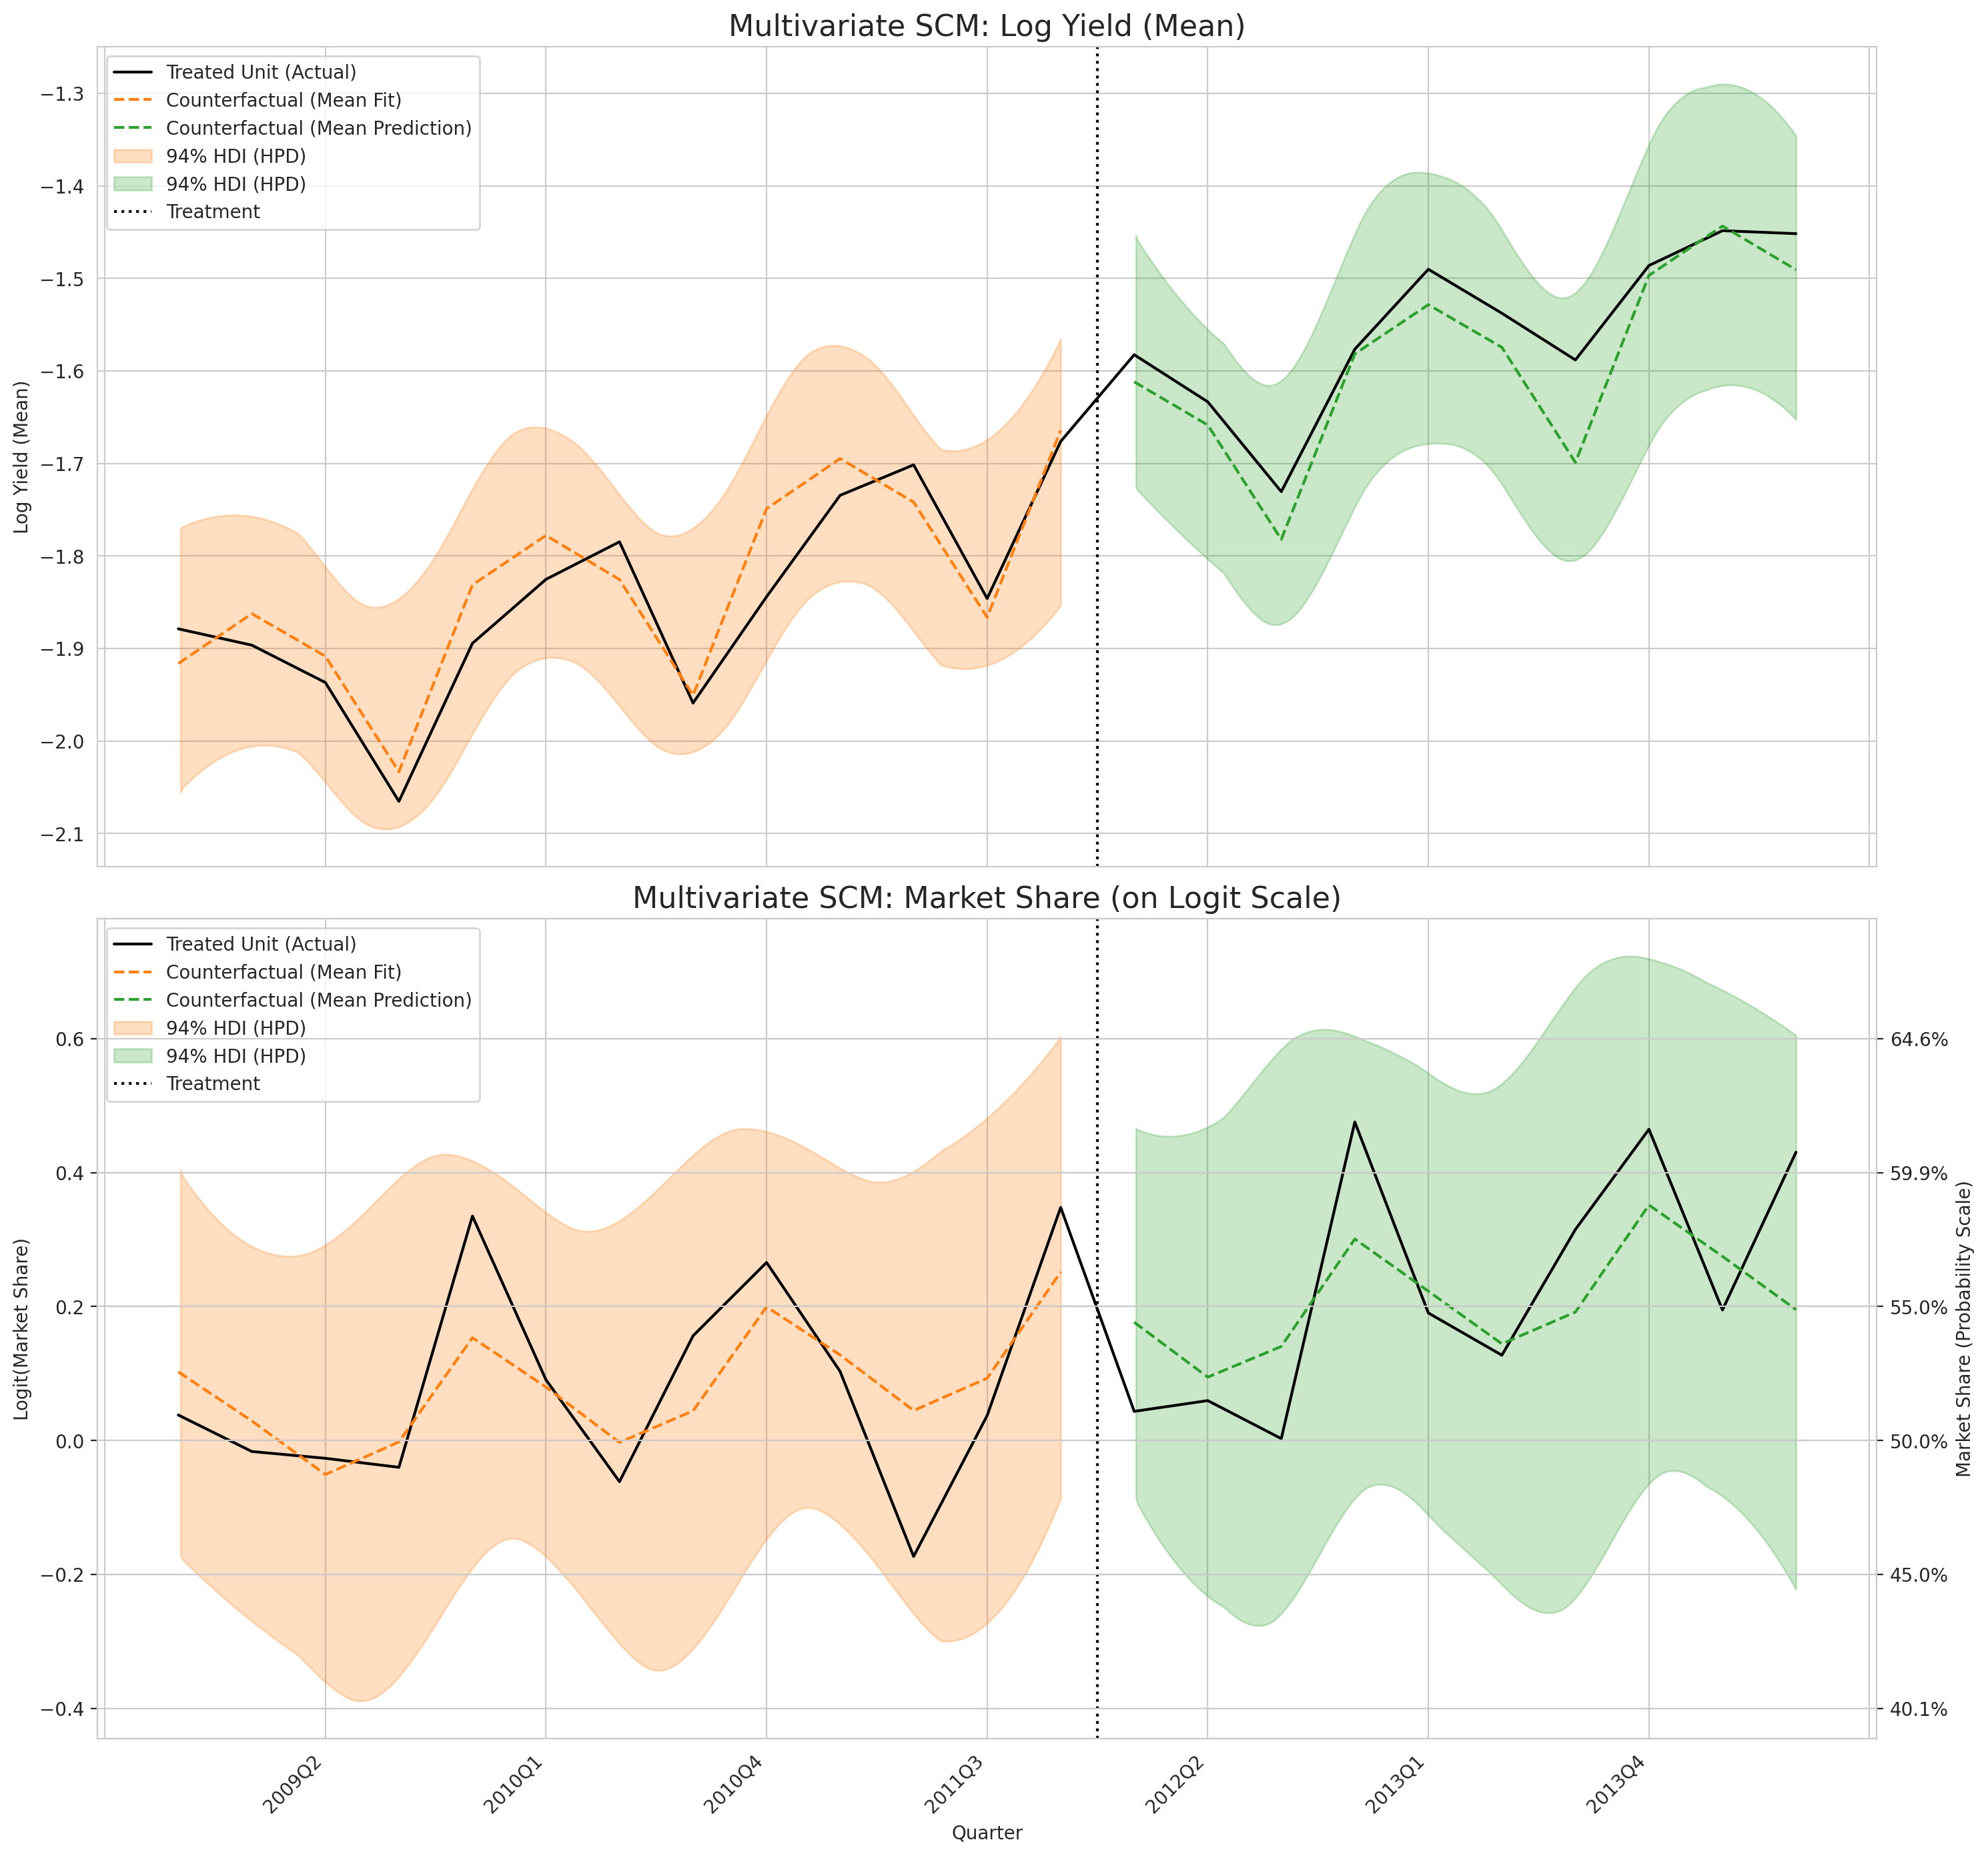

--- Analyzing Control Unit Weights (Log Yield) ---


/tmp/ipython-input-2000004980.py:161: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_weights = az.hdi(beta_samps.T.values, hdi_prob=hdi_prob)


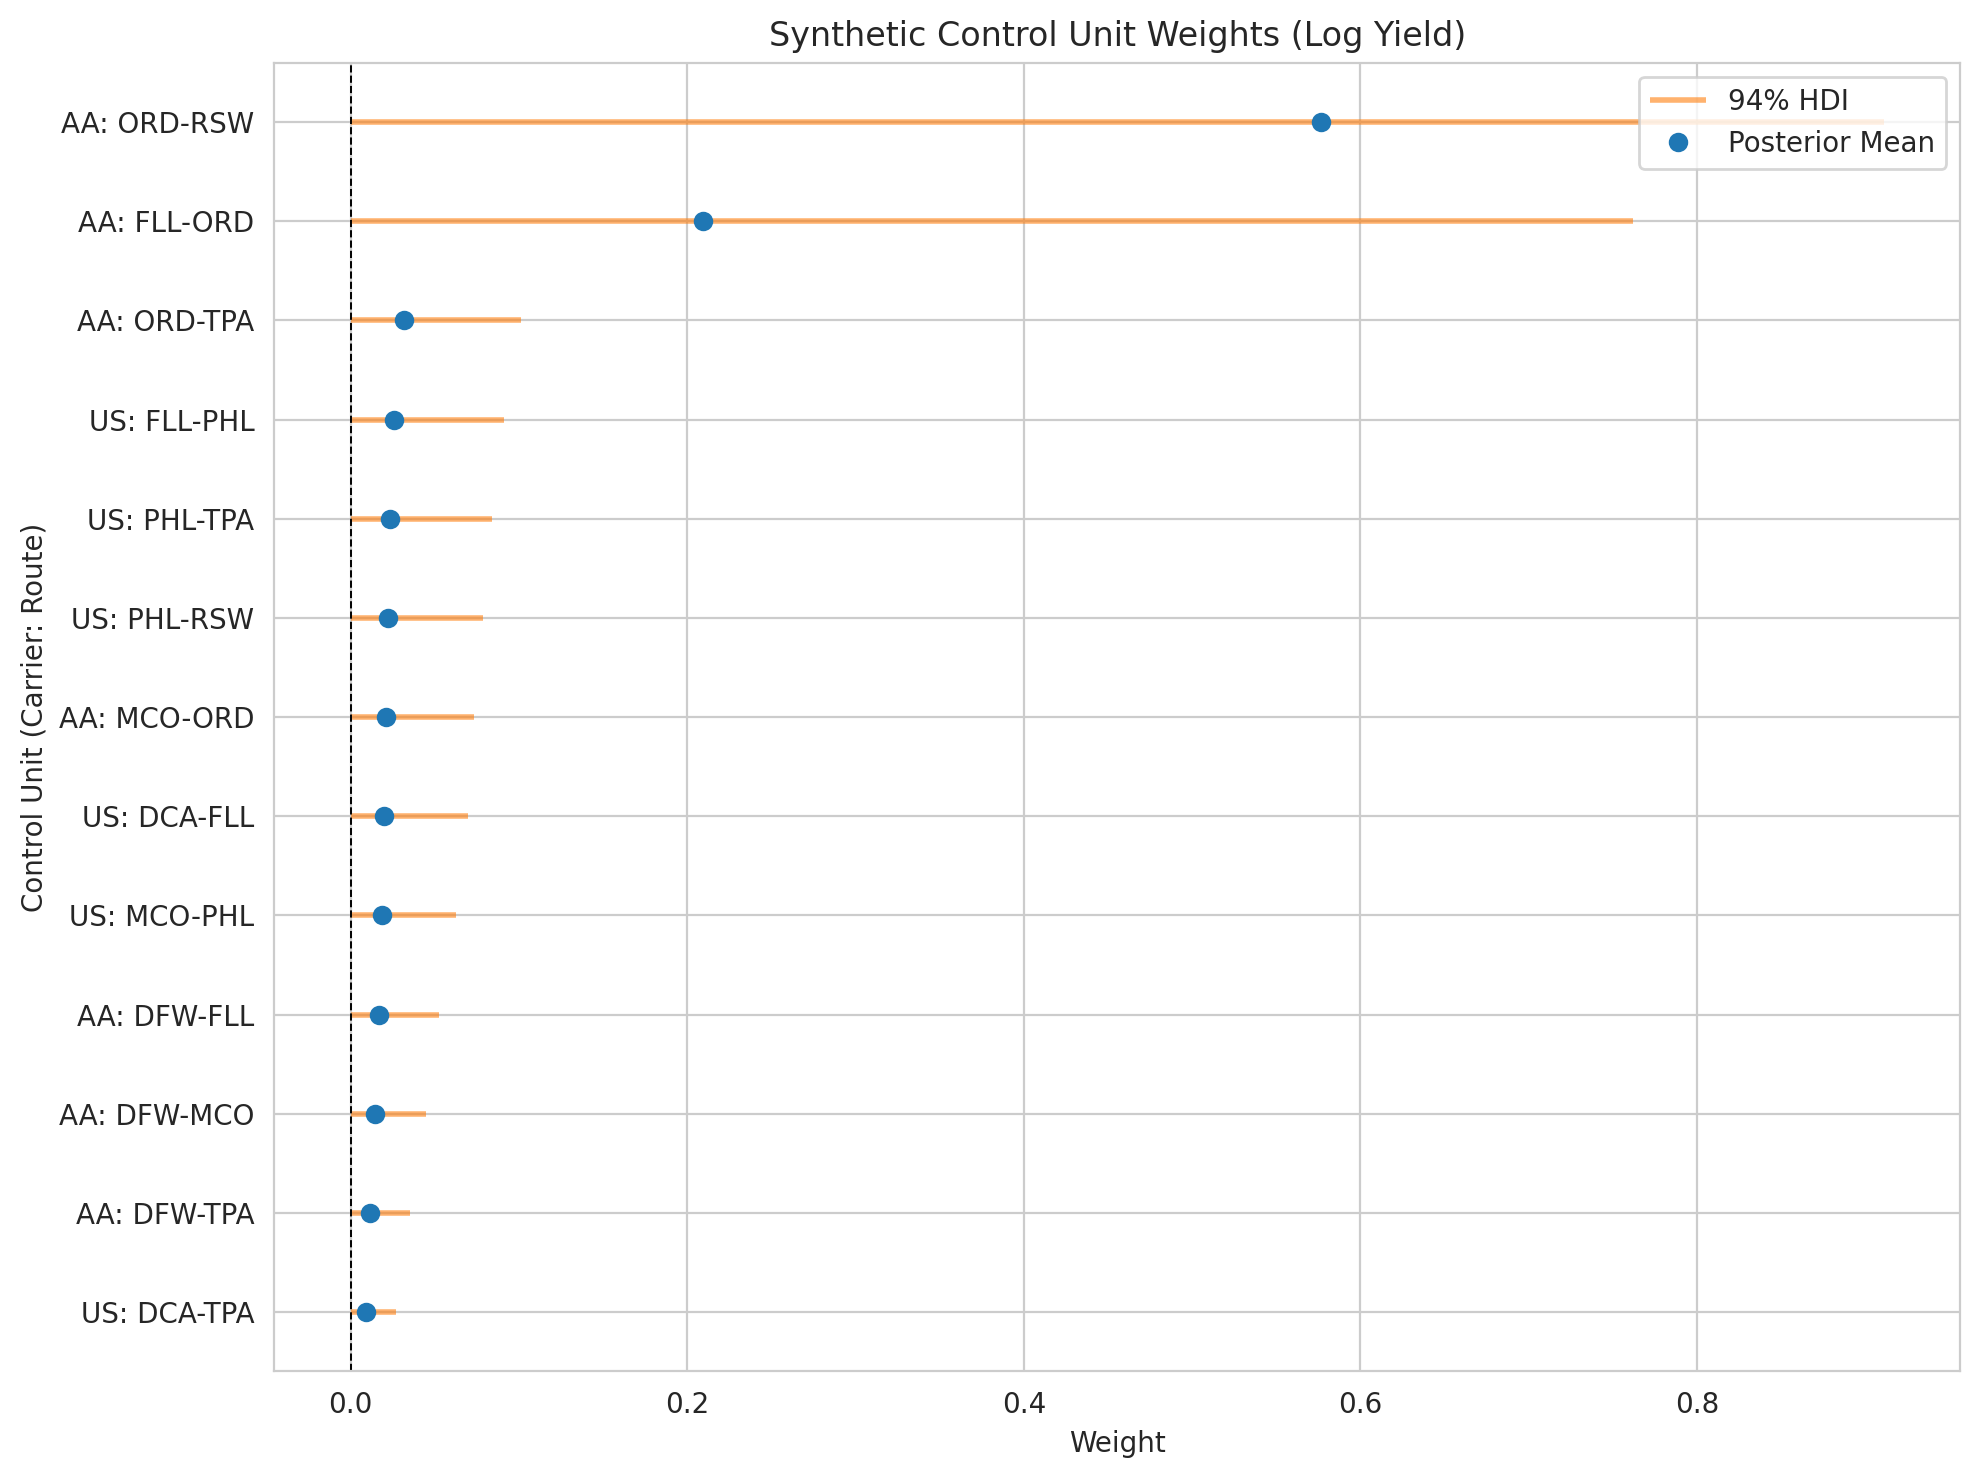

--- Analyzing Control Unit Weights (Logit Market Share) ---


/tmp/ipython-input-2000004980.py:161: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_weights = az.hdi(beta_samps.T.values, hdi_prob=hdi_prob)


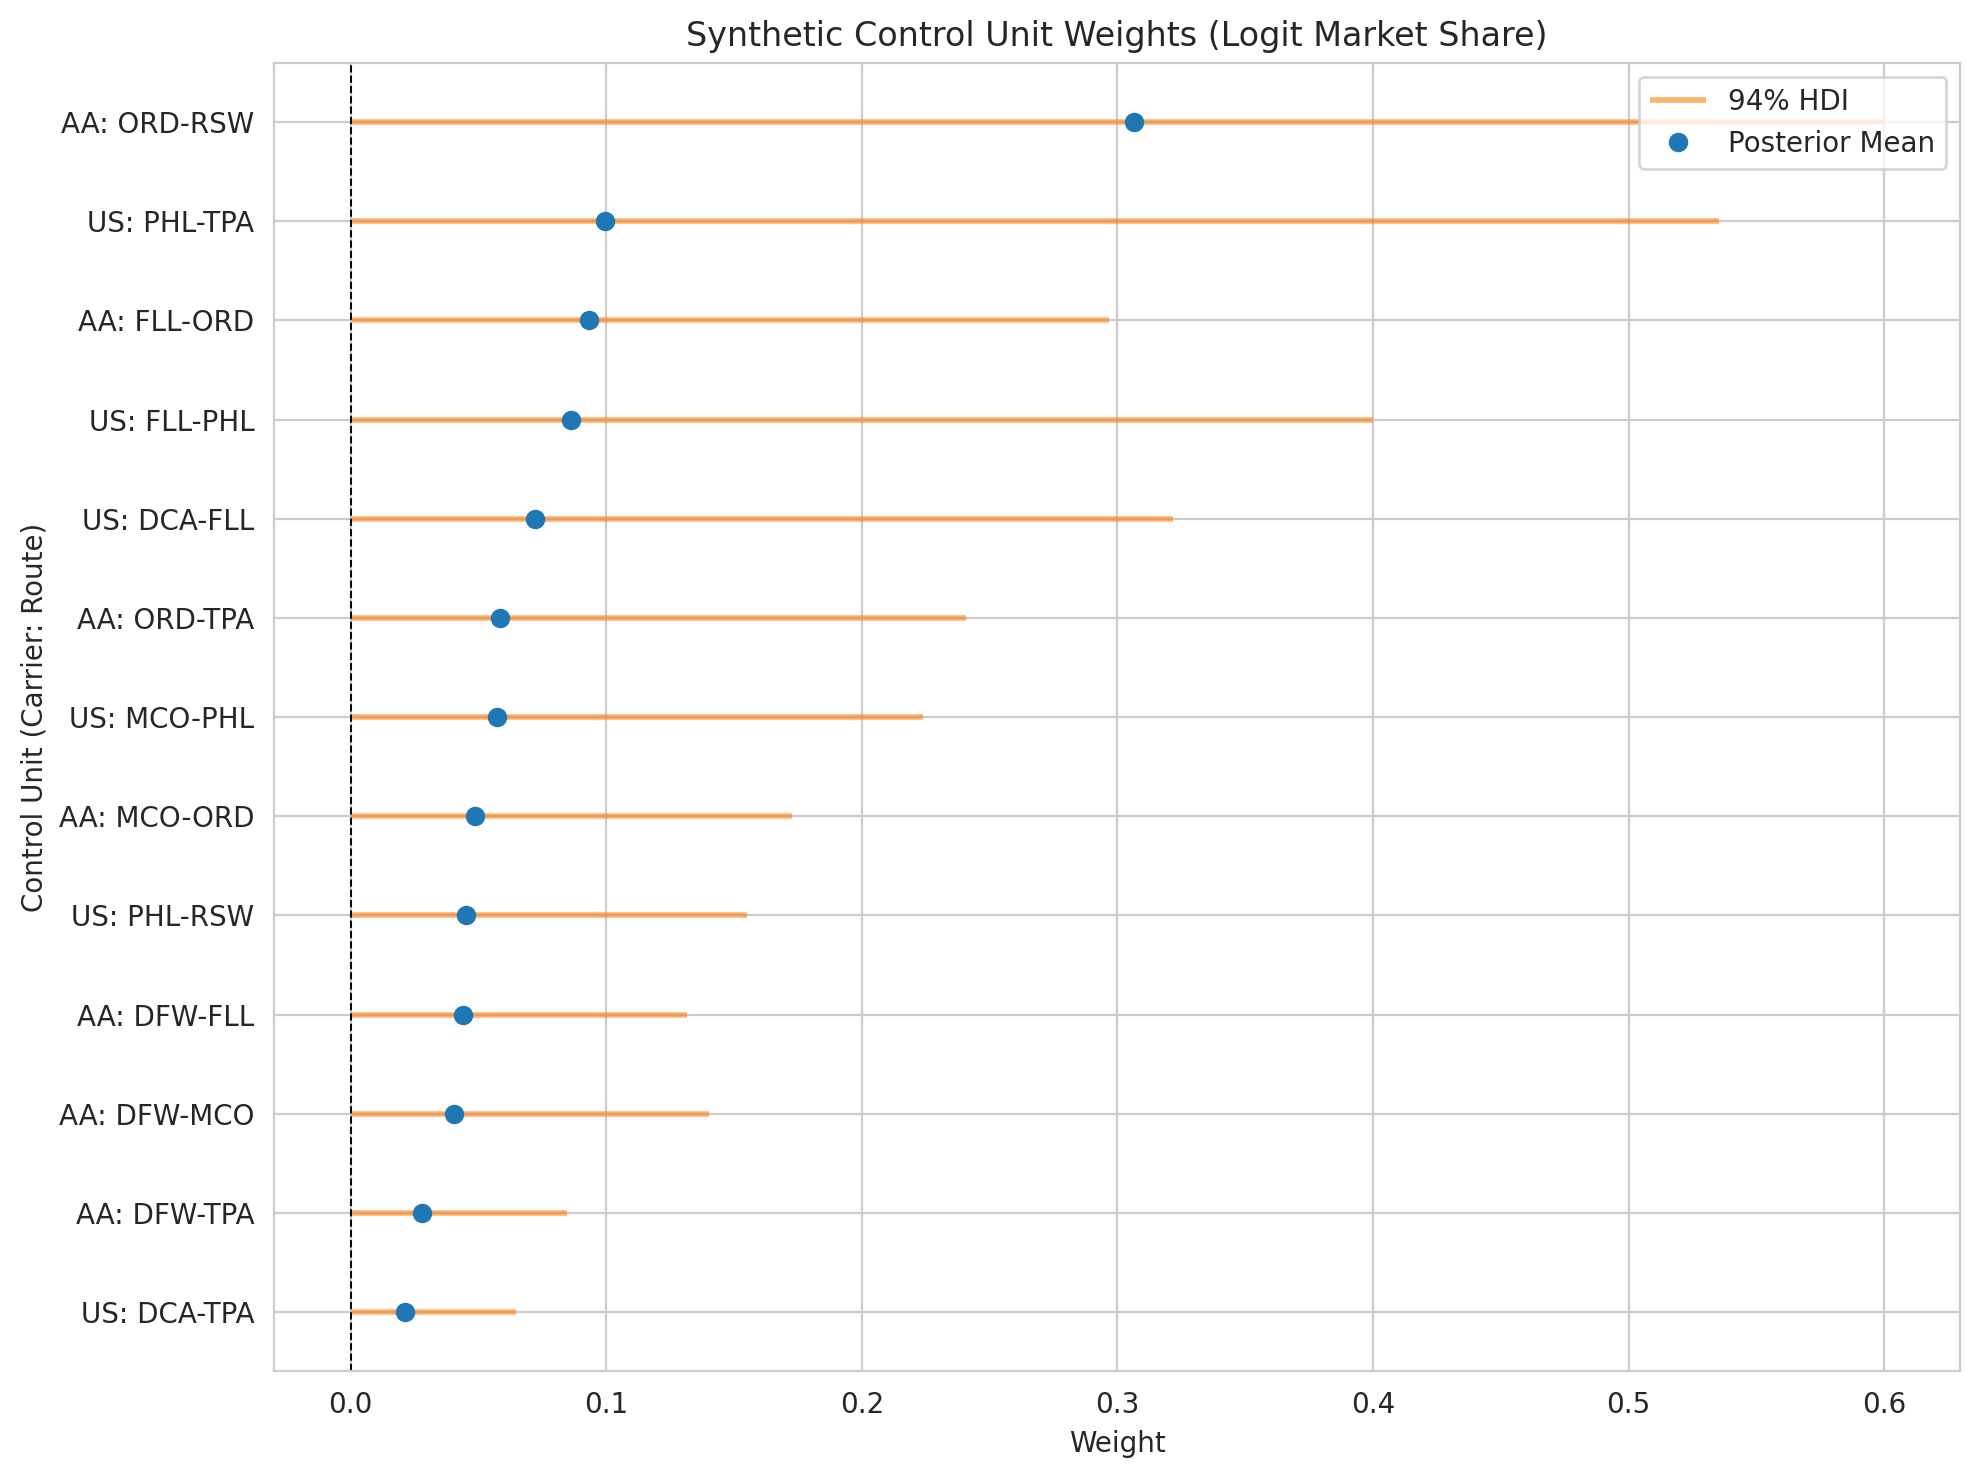

--- Calculating Causal Impact Distributions ---

--- Average Treatment Effect (ATT) Summary ---
  Log Yield:
    Mean Effect: 0.0339
    94% HDI:     [-0.06040092  0.1165817 ]

  Market Share (Percentage Points):
    Mean Effect: 0.54%
    94% HDI:     [-0.05680324  0.06281603]
------------------------------------------------



/usr/local/lib/python3.12/dist-packages/arviz/plots/hdiplot.py:166: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)
/usr/local/lib/python3.12/dist-packages/arviz/plots/hdiplot.py:166: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)


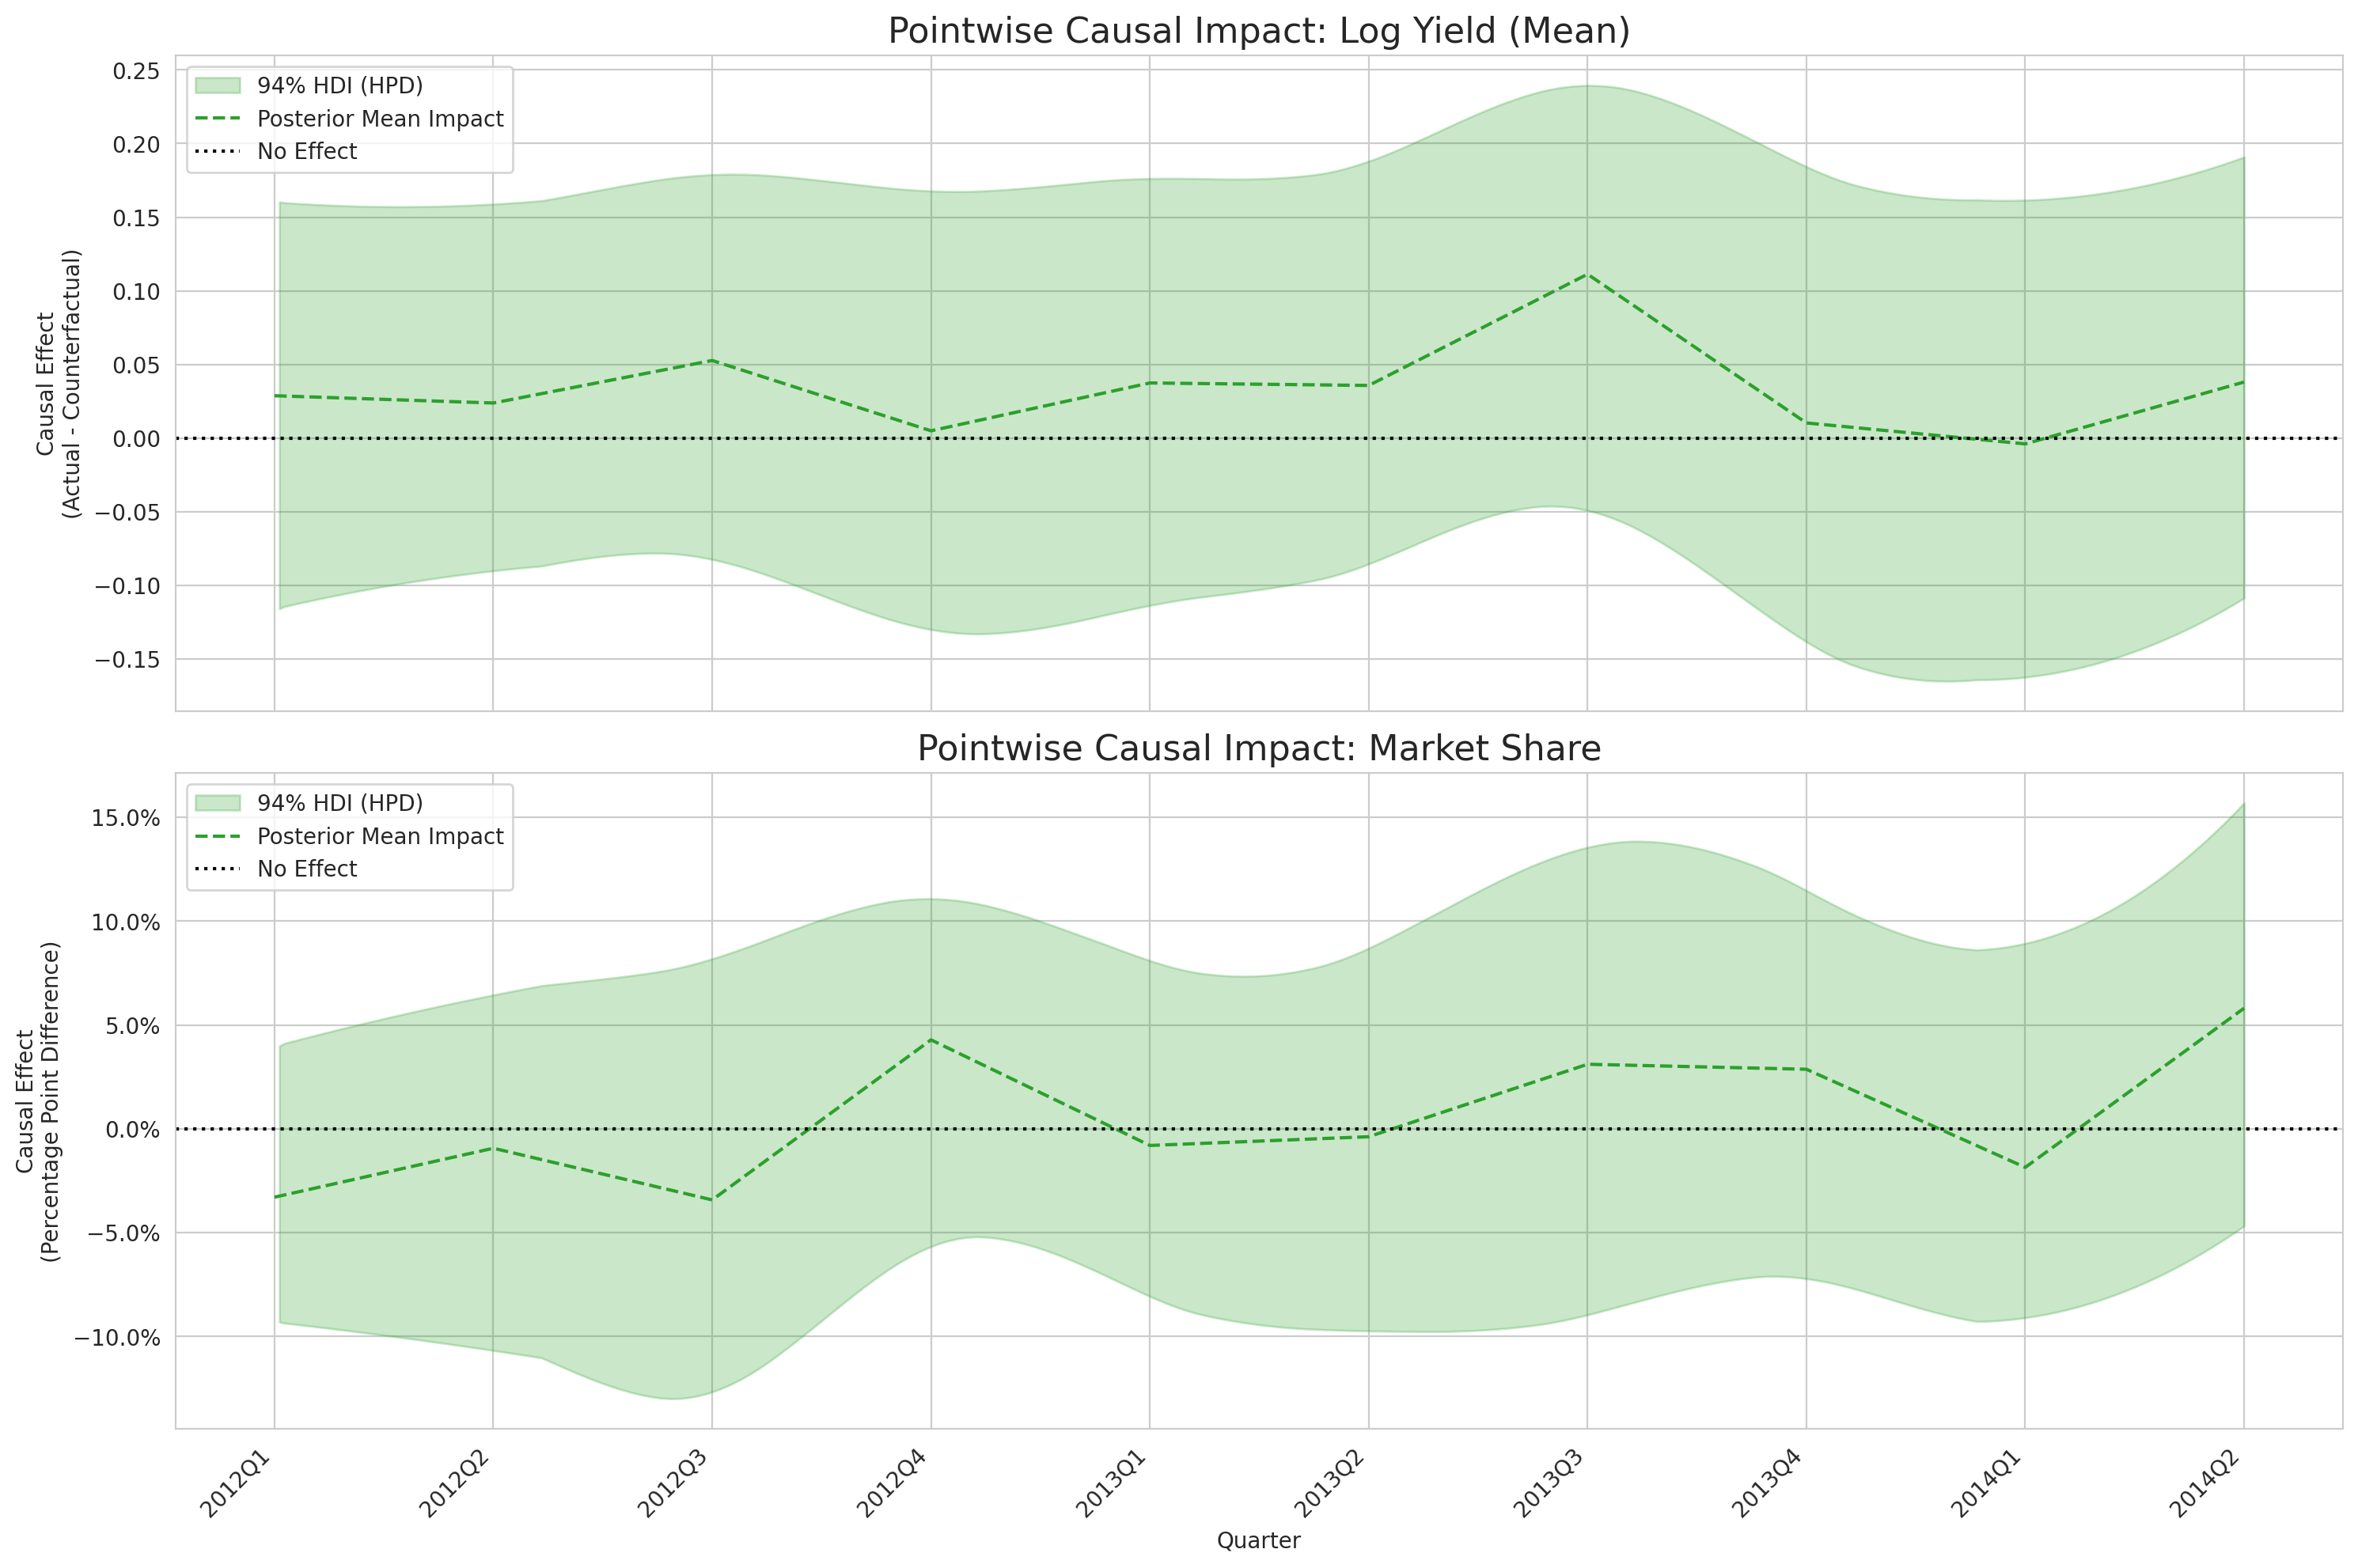

In [20]:
try:
    model_data, plot_data = prepare_data_for_generative_scm(
        units_df,
        dl_treated_carrier_routes,
        all_control_routes_aa_us,
        treatment_time,
        dl_treated_carrier
    )

    generative_model = build_generative_scm_model(**model_data)

    if generative_model is not None:

        sample_kwargs = {
            "tune": 2000,
            "draws": 2000,
            "target_accept": 0.80,
            "random_seed": 42,
            "chains": 4,
            "nuts_kwargs": {
                "max_tree_depth": 10
            }
        }

        print("--- Sampling with JAX (Numpyro) ---")
        with generative_model:
            idata = pymc.sampling.jax.sample_numpyro_nuts(**sample_kwargs)

        print("--- Sampling Complete ---")

        print("--- Model Diagnostic Summary ---")
        # Define the parameters we care most about.
        # We want the top-level parameters the sampler is fitting.
        # 'beta' is our SCM weights.
        # The '_offset' variables are the non-centered
        # hyperparameters for all our groups.
        # Problems here will cascade down to everything else.
        # Check the hierarchical weight parameters
        vars_to_check = [
            'beta_y',
            'beta_s',
            'beta_raw_base',
            'beta_raw_offset_y',
            'beta_raw_offset_s',
            'trend_slope_y_offset',
            'trend_slope_s_offset'
        ]

        summary_stats = az.summary(idata, var_names=vars_to_check, round_to=3)

        with pd.option_context('display.max_rows', None):
            print(summary_stats)

        plot_generative_scm_results(model_data, plot_data, idata, generative_model)

        plot_control_weights(idata, plot_data,
                            beta_var_name="beta_y",
                            title_suffix="Log Yield")

        plot_control_weights(idata, plot_data,
                            beta_var_name="beta_s",
                            title_suffix="Logit Market Share")

        calculate_and_plot_impact(model_data, plot_data, idata)

except ValueError as e:
    print(f"Data preparation failed: {e}")
except Exception as e:
    print(f"An error occurred during model execution: {e}")

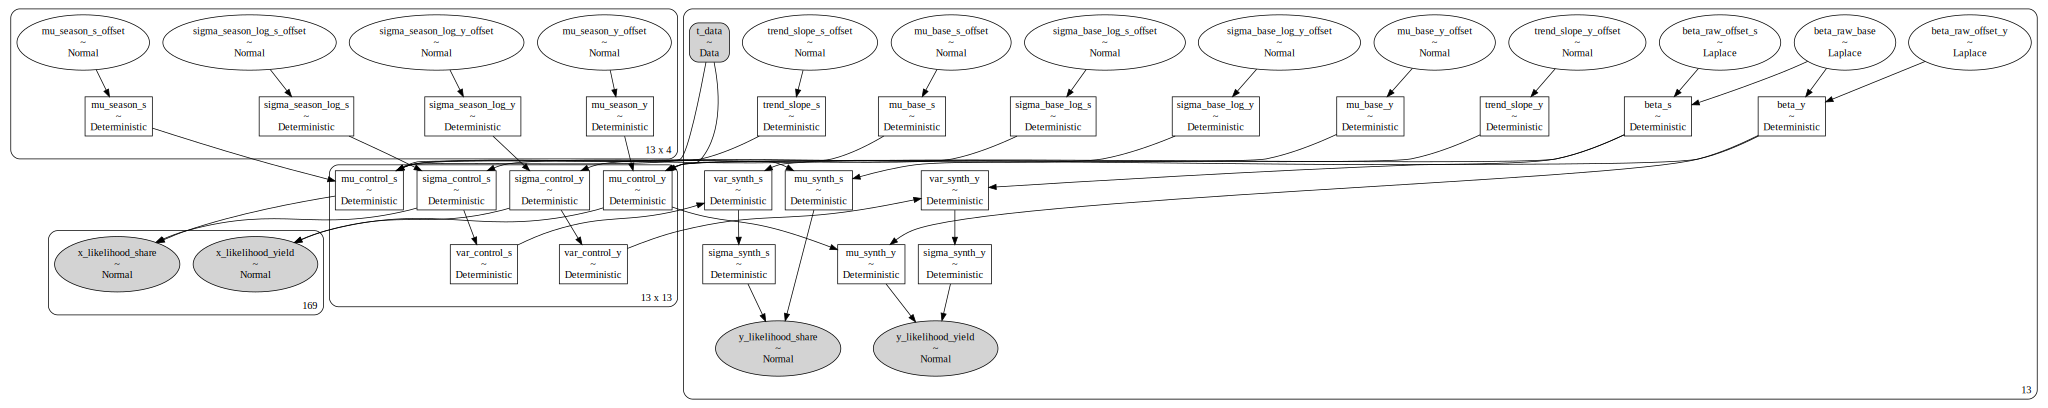

In [21]:
pm.model_to_graphviz(generative_model)